In [30]:
# load data
import os
from tqdm import tqdm, tqdm_notebook
import numpy as np
import pandas as pd
from scipy.misc import imread
import matplotlib.pyplot as plt

from math import *
import cv2
import keras.backend as K

import tensorflow as tf
from tensorflow.python.ops import control_flow_ops
tf.python.control_flow_ops = control_flow_ops

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Input, InputLayer, Lambda
from keras.layers import Convolution2D, MaxPooling2D, Flatten, SpatialDropout2D, Cropping2D
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing import image

from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.normalization import BatchNormalization
from sklearn.model_selection import train_test_split
from keras.models import model_from_json

%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

print('All Packages Loaded')

driving_train_Log = pd.read_csv('C:/Users/Sharath/Desktop/test/data/driving_log.csv',names=['Center','Left','Right','Steering Angle','Throttle','Break','Speed'],header=None)
driving_test_Log = pd.read_csv('C:/Users/Sharath/Desktop/driving_log.csv',names=['Center','Left','Right','Steering Angle','Throttle','Break','Speed'],header=None)

print("All Data Loaded")

All Packages Loaded
All Data Loaded


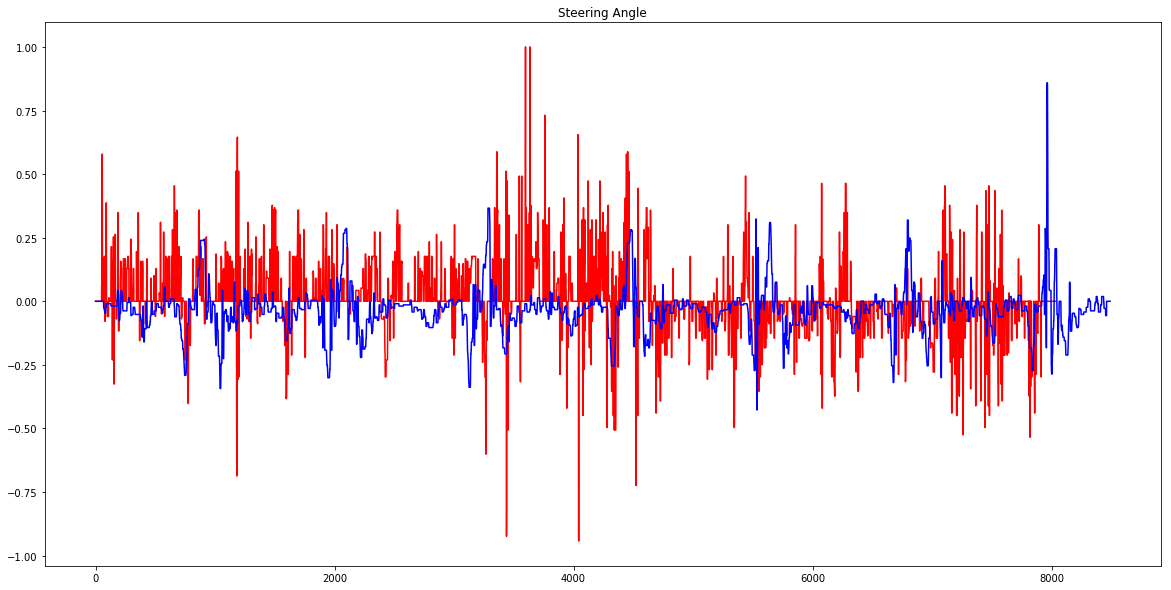

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(20,10))
driving_train_Log['Steering Angle'].plot(ax=axes,color='red'); axes.set_title('Steering Angle');
driving_test_Log['Steering Angle'].plot(ax=axes,color='blue'); axes.set_title('Steering Angle');


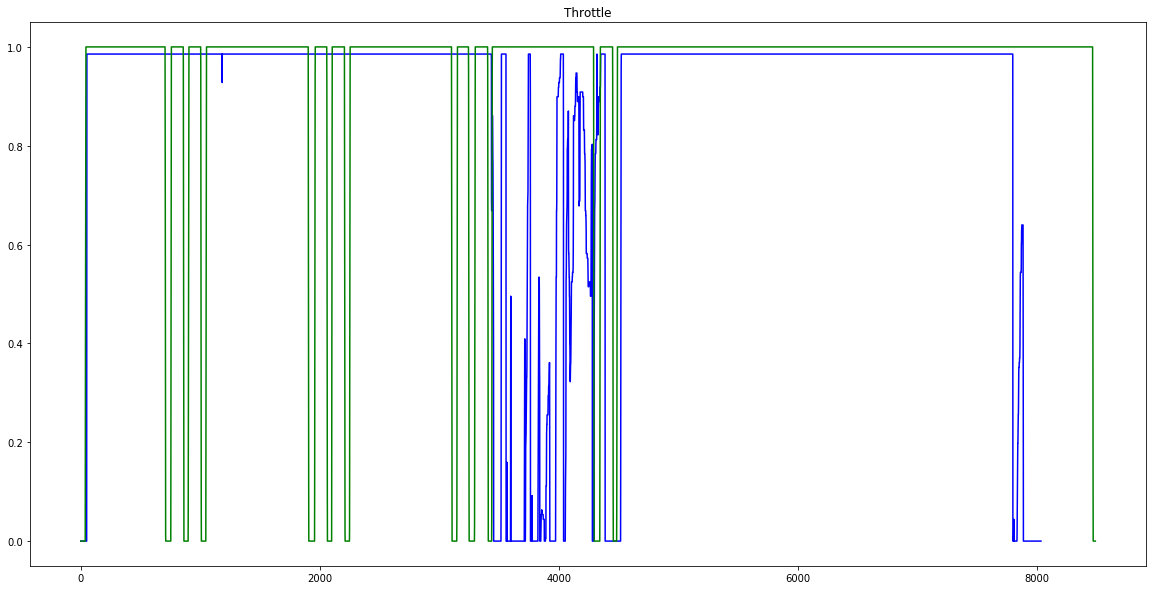

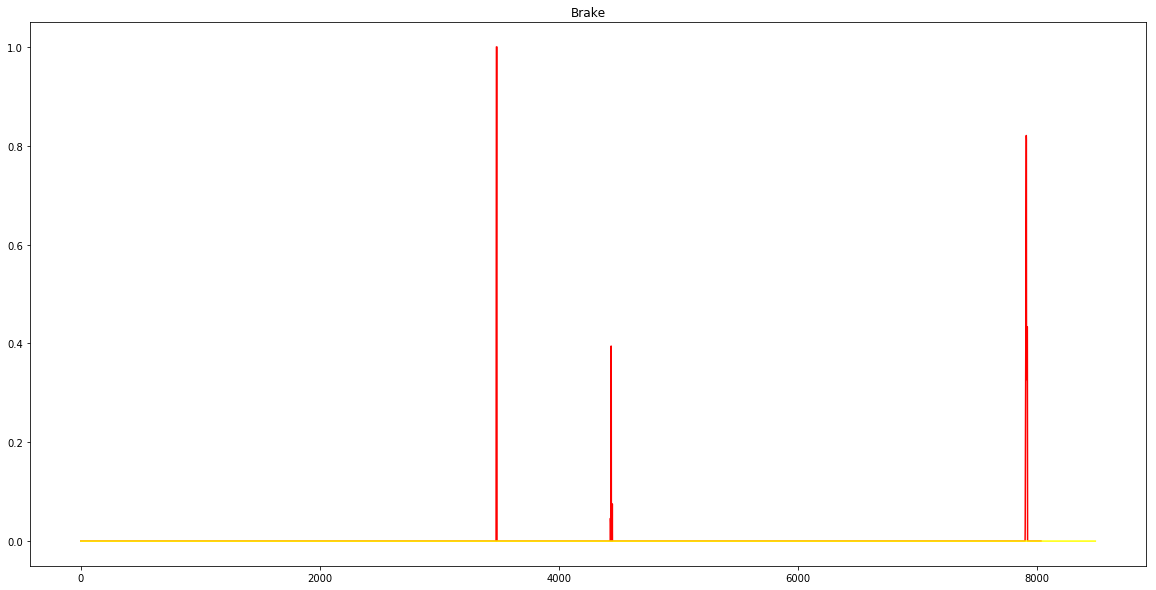

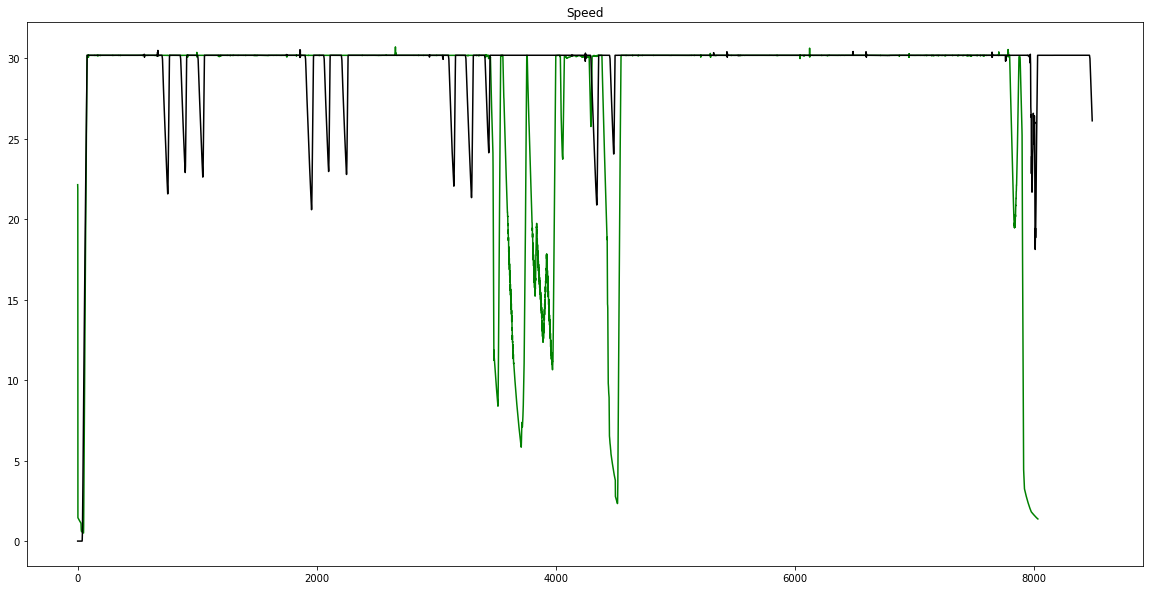

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(20,10))
driving_train_Log['Throttle'].plot(ax=axes,color='blue'); axes.set_title('Throttle');
driving_test_Log['Throttle'].plot(ax=axes,color='green'); axes.set_title('Throttle');

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(20,10))
driving_train_Log['Break'].plot(ax=axes,color='red'); axes.set_title('Brake');
driving_test_Log['Break'].plot(ax=axes,color='yellow'); axes.set_title('Brake');

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(20,10))
driving_train_Log['Speed'].plot(ax=axes,color='green'); axes.set_title('Speed');
driving_test_Log['Speed'].plot(ax=axes,color='black'); axes.set_title('Speed');

In [33]:
def region_of_interest(img):
    image = img[60:140,40:280]
    return cv2.resize(image, (200, 66))

def image_generator(driving_log, data_path, normalizer=255.0, steering_shift=3.0, steering_max=25.):
    driving_log = driving_log.sample(frac=1).reset_index(drop=True)

    for index, row in driving_log.iterrows():
        file_name  = os.path.basename(row['center'])
        file_name1 = os.path.basename(row['left'])
        file_name2 = os.path.basename(row['right'])

        image = load_img(data_path+'IMG/'+file_name)
        image1 = load_img(data_path+'IMG/'+file_name1)
        image2 = load_img(data_path+'IMG/'+file_name2)
        
        img  = region_of_interest(cv2.cvtColor(img_to_array(image), cv2.COLOR_RGB2YUV))
        img1 = region_of_interest(cv2.cvtColor(img_to_array(image1), cv2.COLOR_RGB2YUV))
        img2 = region_of_interest(cv2.cvtColor(img_to_array(image2), cv2.COLOR_RGB2YUV))
        
        yield img, np.float32(row['steering'])
        yield img1, np.float32(row['steering'])+steering_shift/steering_max
        yield img2, np.float32(row['steering'])-steering_shift/steering_max
        
#         if abs(np.float32(row['steering'])) >= 1/25.:
#             yield np.fliplr(img), -np.float32(row['steering'])
        
def batch_generator(driving_log, data_path, batch_size=32, *args, **kwargs):
    num_rows = len(driving_log.index)
    train_images = np.zeros((batch_size, img_rows, img_cols, 3))
    train_steering = np.zeros(batch_size)
    ctr = None
    while 1:        
        for j in range(batch_size):
            # Reset generator if over bounds
            if ctr is None or ctr >= num_rows:
                ctr = 0
                images = image_generator(driving_log, data_path, *args, **kwargs)
            train_images[j], train_steering[j] = next(images)
            ctr += 1
        yield train_images, train_steering

In [42]:
data_train_path = 'C:/Users/Sharath/Desktop/test/data/IMG/'
data_test_path = 'C:/Users/Sharath/Desktop/IMG/'

#img_rows, img_cols = 160, 320
img_rows, img_cols = 66, 200

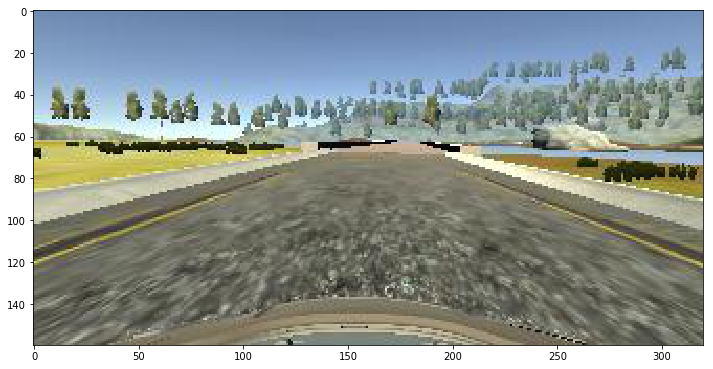

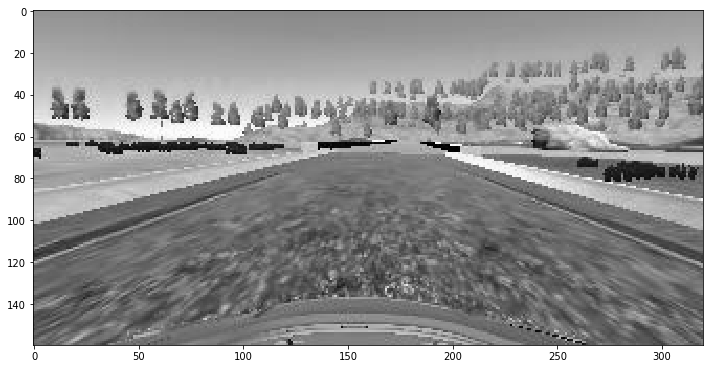

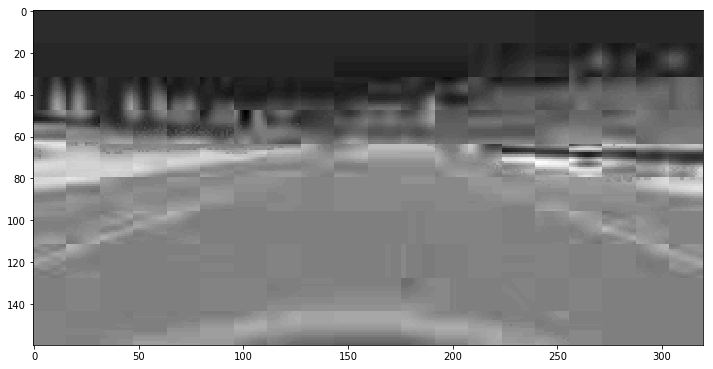

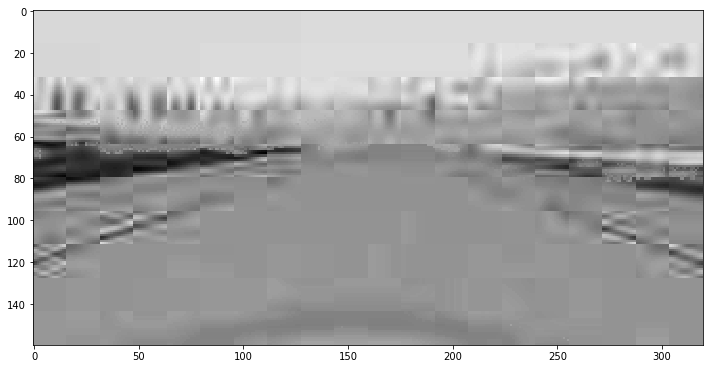

In [43]:
file_name = 'center_2016_12_01_13_32_45_074.jpg'
import matplotlib.image as mpimg
im1 = mpimg.imread(data_train_path+file_name)
# im = img_to_array(im)
plt.figure()
plt.imshow(im1)
im = cv2.cvtColor(im1, cv2.COLOR_RGB2YUV)

plt.figure()
plt.rcParams['figure.figsize'] = (12,10)


plt.imshow(im[:,:,0]/255., cmap='gray')
plt.figure()

plt.imshow(im[:,:,1]/255., cmap='gray')
plt.figure()

plt.imshow(im[:,:,2]/255., cmap='gray')
plt.show()

In [44]:
data_train_path = 'C:/Users/Sharath/Desktop/test/data/'
data_test_path = 'C:/Users/Sharath/Desktop/'

In [45]:
labels = ['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']
driving_log = pd.read_csv(data_train_path+'driving_log.csv', names=labels)
driving_log = driving_log.sample(frac=1).reset_index(drop=True) # Shuffle

test_log = pd.read_csv(data_test_path+'driving_log.csv', names=labels)
test_log = test_log.sample(frac=1).reset_index(drop=True) # Shuffle

train_data = batch_generator(driving_log, data_train_path, batch_size=32)
val_data = batch_generator(test_log.sample(frac=0.1), data_test_path, batch_size=32)
test_data = batch_generator(test_log.sample(frac=0.9), data_test_path, batch_size=32)
print("The number of Observations in Training Set:",len(driving_log))
print("The number of Observations in Test Set:",len(test_log))

The number of Observations in Training Set: 8036
The number of Observations in Test Set: 8491


In [46]:
model = Sequential()
model.add(Lambda(lambda x: x/127.5 - 1., input_shape=(img_rows, img_cols, 3), name='Normalization'))  # Normalization courtesy of John Chen
model.add(Convolution2D(24, 5, 5, subsample=(2,2), activation='relu', name='Conv1'))
model.add(Convolution2D(36, 5, 5, subsample=(2,2), activation='relu', name='Conv2'))
model.add(Convolution2D(48, 5, 5, subsample=(2,2), activation='relu', name='Conv3'))
model.add(Convolution2D(64, 3, 3, activation='relu', name='Conv4'))
model.add(Convolution2D(64, 3, 3, activation='relu', name='Conv5'))
model.add(Flatten())
model.add(Dense(1164, activation='relu', name='FC1'))
model.add(Dense(100, activation='relu', name='FC2'))
model.add(Dense(50, activation='relu', name='FC3'))
model.add(Dense(10, activation='relu', name='FC4'))
model.add(Dense(1, name='output'))
model.summary()

C:\Users\Sharath\A\envs\CarND\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), activation="relu", name="Conv1", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Sharath\A\envs\CarND\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="relu", name="Conv2", strides=(2, 2))`
  after removing the cwd from sys.path.
C:\Users\Sharath\A\envs\CarND\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="relu", name="Conv3", strides=(2, 2))`
  """
C:\Users\Sharath\A\envs\CarND\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="Conv4")`
  
C:\Users\Sharath\A\envs\CarND\lib\site-packages\ipykernel_launcher.py:7: User

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Normalization (Lambda)       (None, 66, 200, 3)        0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 31, 98, 24)        1824      
_________________________________________________________________
Conv2 (Conv2D)               (None, 14, 47, 36)        21636     
_________________________________________________________________
Conv3 (Conv2D)               (None, 5, 22, 48)         43248     
_________________________________________________________________
Conv4 (Conv2D)               (None, 3, 20, 64)         27712     
_________________________________________________________________
Conv5 (Conv2D)               (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_4 (Flatten)          (None, 1152)              0         
__________

In [50]:
opt = Adam(lr=0.0001)
model.compile(optimizer=opt, loss='mse', metrics=[])

In [51]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        print('BEGIN TRAINING')
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [53]:
from keras.callbacks import ModelCheckpoint

In [54]:
checkpoint = ModelCheckpoint('model-{epoch:03d}.h5',
                                 monitor='val_loss',
                                 verbose=0,
                                 save_best_only=True,
                                 mode='auto')


In [57]:
batch_history = LossHistory()
h = model.fit_generator(train_data, validation_data = val_data,
                        samples_per_epoch = 28000,
                        nb_val_samples = 960,
                        nb_epoch=2, verbose=1, callbacks=[batch_history])

C:\Users\Sharath\A\envs\CarND\lib\site-packages\ipykernel_launcher.py:5: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  """
C:\Users\Sharath\A\envs\CarND\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_steps=960, callbacks=[<__main__..., steps_per_epoch=28000, epochs=2, verbose=1, validation_data=<generator...)`
  """


BEGIN TRAINING
Epoch 1/2


  291/28000 [..............................] - ETA: 2:30:40 - loss: 0.00 - ETA: 2:21:13 - loss: 0.00 - ETA: 2:17:17 - loss: 0.00 - ETA: 2:17:25 - loss: 0.00 - ETA: 2:16:15 - loss: 0.00 - ETA: 2:15:07 - loss: 0.00 - ETA: 2:14:14 - loss: 0.00 - ETA: 2:12:59 - loss: 0.00 - ETA: 2:12:22 - loss: 0.00 - ETA: 2:12:19 - loss: 0.00 - ETA: 2:11:57 - loss: 0.00 - ETA: 2:11:48 - loss: 0.00 - ETA: 2:11:00 - loss: 0.00 - ETA: 2:10:43 - loss: 0.00 - ETA: 2:10:15 - loss: 0.00 - ETA: 2:10:01 - loss: 0.00 - ETA: 2:09:59 - loss: 0.00 - ETA: 2:10:04 - loss: 0.00 - ETA: 2:10:08 - loss: 0.00 - ETA: 2:10:16 - loss: 0.00 - ETA: 2:10:11 - loss: 0.00 - ETA: 2:10:26 - loss: 0.00 - ETA: 2:10:36 - loss: 0.00 - ETA: 2:10:48 - loss: 0.00 - ETA: 2:10:48 - loss: 0.00 - ETA: 2:10:43 - loss: 0.00 - ETA: 2:10:42 - loss: 0.00 - ETA: 2:10:34 - loss: 0.00 - ETA: 2:10:17 - loss: 0.00 - ETA: 2:10:22 - loss: 0.00 - ETA: 2:10:02 - loss: 0.00 - ETA: 2:10:09 - loss: 0.00 - ETA: 2:10:10 - loss: 0.00 - ETA: 2:10:03 - loss: 0.00 - E

  582/28000 [..............................] - ETA: 2:06:06 - loss: 0.00 - ETA: 2:06:04 - loss: 0.00 - ETA: 2:06:04 - loss: 0.00 - ETA: 2:06:03 - loss: 0.00 - ETA: 2:06:03 - loss: 0.00 - ETA: 2:06:02 - loss: 0.00 - ETA: 2:06:01 - loss: 0.00 - ETA: 2:06:01 - loss: 0.00 - ETA: 2:06:00 - loss: 0.00 - ETA: 2:05:59 - loss: 0.00 - ETA: 2:05:57 - loss: 0.00 - ETA: 2:05:58 - loss: 0.00 - ETA: 2:05:57 - loss: 0.00 - ETA: 2:05:56 - loss: 0.00 - ETA: 2:05:55 - loss: 0.00 - ETA: 2:05:55 - loss: 0.00 - ETA: 2:05:54 - loss: 0.00 - ETA: 2:05:54 - loss: 0.00 - ETA: 2:05:53 - loss: 0.00 - ETA: 2:05:52 - loss: 0.00 - ETA: 2:05:51 - loss: 0.00 - ETA: 2:05:50 - loss: 0.00 - ETA: 2:05:50 - loss: 0.00 - ETA: 2:05:49 - loss: 0.00 - ETA: 2:05:48 - loss: 0.00 - ETA: 2:05:48 - loss: 0.00 - ETA: 2:05:47 - loss: 0.00 - ETA: 2:05:45 - loss: 0.00 - ETA: 2:05:45 - loss: 0.00 - ETA: 2:05:45 - loss: 0.00 - ETA: 2:05:44 - loss: 0.00 - ETA: 2:05:43 - loss: 0.00 - ETA: 2:05:43 - loss: 0.00 - ETA: 2:05:42 - loss: 0.00 - E

  873/28000 [..............................] - ETA: 2:03:50 - loss: 0.00 - ETA: 2:03:51 - loss: 0.00 - ETA: 2:03:50 - loss: 0.00 - ETA: 2:03:49 - loss: 0.00 - ETA: 2:03:49 - loss: 0.00 - ETA: 2:03:48 - loss: 0.00 - ETA: 2:03:48 - loss: 0.00 - ETA: 2:03:47 - loss: 0.00 - ETA: 2:03:48 - loss: 0.00 - ETA: 2:03:47 - loss: 0.00 - ETA: 2:03:47 - loss: 0.00 - ETA: 2:03:46 - loss: 0.00 - ETA: 2:03:46 - loss: 0.00 - ETA: 2:03:45 - loss: 0.00 - ETA: 2:03:45 - loss: 0.00 - ETA: 2:03:44 - loss: 0.00 - ETA: 2:03:44 - loss: 0.00 - ETA: 2:03:44 - loss: 0.00 - ETA: 2:03:43 - loss: 0.00 - ETA: 2:03:42 - loss: 0.00 - ETA: 2:03:42 - loss: 0.00 - ETA: 2:03:41 - loss: 0.00 - ETA: 2:03:41 - loss: 0.00 - ETA: 2:03:40 - loss: 0.00 - ETA: 2:03:40 - loss: 0.00 - ETA: 2:03:39 - loss: 0.00 - ETA: 2:03:39 - loss: 0.00 - ETA: 2:03:39 - loss: 0.00 - ETA: 2:03:39 - loss: 0.00 - ETA: 2:03:38 - loss: 0.00 - ETA: 2:03:38 - loss: 0.00 - ETA: 2:03:38 - loss: 0.00 - ETA: 2:03:38 - loss: 0.00 - ETA: 2:03:37 - loss: 0.00 - E

 1164/28000 [>.............................] - ETA: 2:02:09 - loss: 0.00 - ETA: 2:02:09 - loss: 0.00 - ETA: 2:02:09 - loss: 0.00 - ETA: 2:02:08 - loss: 0.00 - ETA: 2:02:08 - loss: 0.00 - ETA: 2:02:08 - loss: 0.00 - ETA: 2:02:07 - loss: 0.00 - ETA: 2:02:07 - loss: 0.00 - ETA: 2:02:07 - loss: 0.00 - ETA: 2:02:07 - loss: 0.00 - ETA: 2:02:06 - loss: 0.00 - ETA: 2:02:06 - loss: 0.00 - ETA: 2:02:06 - loss: 0.00 - ETA: 2:02:05 - loss: 0.00 - ETA: 2:02:05 - loss: 0.00 - ETA: 2:02:04 - loss: 0.00 - ETA: 2:02:04 - loss: 0.00 - ETA: 2:02:03 - loss: 0.00 - ETA: 2:02:03 - loss: 0.00 - ETA: 2:02:03 - loss: 0.00 - ETA: 2:02:03 - loss: 0.00 - ETA: 2:02:02 - loss: 0.00 - ETA: 2:02:02 - loss: 0.00 - ETA: 2:02:01 - loss: 0.00 - ETA: 2:02:01 - loss: 0.00 - ETA: 2:02:01 - loss: 0.00 - ETA: 2:02:01 - loss: 0.00 - ETA: 2:02:00 - loss: 0.00 - ETA: 2:02:00 - loss: 0.00 - ETA: 2:01:59 - loss: 0.00 - ETA: 2:01:59 - loss: 0.00 - ETA: 2:01:58 - loss: 0.00 - ETA: 2:01:58 - loss: 0.00 - ETA: 2:01:57 - loss: 0.00 - E

 1455/28000 [>.............................] - ETA: 2:00:54 - loss: 0.00 - ETA: 2:00:54 - loss: 0.00 - ETA: 2:00:53 - loss: 0.00 - ETA: 2:00:53 - loss: 0.00 - ETA: 2:00:53 - loss: 0.00 - ETA: 2:00:53 - loss: 0.00 - ETA: 2:00:52 - loss: 0.00 - ETA: 2:00:52 - loss: 0.00 - ETA: 2:00:52 - loss: 0.00 - ETA: 2:00:52 - loss: 0.00 - ETA: 2:00:52 - loss: 0.00 - ETA: 2:00:51 - loss: 0.00 - ETA: 2:00:51 - loss: 0.00 - ETA: 2:00:51 - loss: 0.00 - ETA: 2:00:51 - loss: 0.00 - ETA: 2:00:50 - loss: 0.00 - ETA: 2:00:50 - loss: 0.00 - ETA: 2:00:50 - loss: 0.00 - ETA: 2:00:49 - loss: 0.00 - ETA: 2:00:49 - loss: 0.00 - ETA: 2:00:49 - loss: 0.00 - ETA: 2:00:49 - loss: 0.00 - ETA: 2:00:48 - loss: 0.00 - ETA: 2:00:48 - loss: 0.00 - ETA: 2:00:48 - loss: 0.00 - ETA: 2:00:48 - loss: 0.00 - ETA: 2:00:48 - loss: 0.00 - ETA: 2:00:47 - loss: 0.00 - ETA: 2:00:47 - loss: 0.00 - ETA: 2:00:47 - loss: 0.00 - ETA: 2:00:46 - loss: 0.00 - ETA: 2:00:46 - loss: 0.00 - ETA: 2:00:46 - loss: 0.00 - ETA: 2:00:46 - loss: 0.00 - E

 1746/28000 [>.............................] - ETA: 1:59:28 - loss: 0.00 - ETA: 1:59:28 - loss: 0.00 - ETA: 1:59:27 - loss: 0.00 - ETA: 1:59:27 - loss: 0.00 - ETA: 1:59:26 - loss: 0.00 - ETA: 1:59:27 - loss: 0.00 - ETA: 1:59:26 - loss: 0.00 - ETA: 1:59:26 - loss: 0.00 - ETA: 1:59:26 - loss: 0.00 - ETA: 1:59:25 - loss: 0.00 - ETA: 1:59:25 - loss: 0.00 - ETA: 1:59:25 - loss: 0.00 - ETA: 1:59:24 - loss: 0.00 - ETA: 1:59:24 - loss: 0.00 - ETA: 1:59:23 - loss: 0.00 - ETA: 1:59:23 - loss: 0.00 - ETA: 1:59:23 - loss: 0.00 - ETA: 1:59:23 - loss: 0.00 - ETA: 1:59:22 - loss: 0.00 - ETA: 1:59:22 - loss: 0.00 - ETA: 1:59:22 - loss: 0.00 - ETA: 1:59:22 - loss: 0.00 - ETA: 1:59:21 - loss: 0.00 - ETA: 1:59:21 - loss: 0.00 - ETA: 1:59:21 - loss: 0.00 - ETA: 1:59:20 - loss: 0.00 - ETA: 1:59:20 - loss: 0.00 - ETA: 1:59:20 - loss: 0.00 - ETA: 1:59:19 - loss: 0.00 - ETA: 1:59:19 - loss: 0.00 - ETA: 1:59:19 - loss: 0.00 - ETA: 1:59:18 - loss: 0.00 - ETA: 1:59:18 - loss: 0.00 - ETA: 1:59:18 - loss: 0.00 - E

 2037/28000 [=>............................] - ETA: 1:57:58 - loss: 0.00 - ETA: 1:57:58 - loss: 0.00 - ETA: 1:57:58 - loss: 0.00 - ETA: 1:57:57 - loss: 0.00 - ETA: 1:57:57 - loss: 0.00 - ETA: 1:57:57 - loss: 0.00 - ETA: 1:57:57 - loss: 0.00 - ETA: 1:57:57 - loss: 0.00 - ETA: 1:57:57 - loss: 0.00 - ETA: 1:57:56 - loss: 0.00 - ETA: 1:57:56 - loss: 0.00 - ETA: 1:57:56 - loss: 0.00 - ETA: 1:57:55 - loss: 0.00 - ETA: 1:57:55 - loss: 0.00 - ETA: 1:57:55 - loss: 0.00 - ETA: 1:57:55 - loss: 0.00 - ETA: 1:57:55 - loss: 0.00 - ETA: 1:57:54 - loss: 0.00 - ETA: 1:57:54 - loss: 0.00 - ETA: 1:57:54 - loss: 0.00 - ETA: 1:57:53 - loss: 0.00 - ETA: 1:57:53 - loss: 0.00 - ETA: 1:57:53 - loss: 0.00 - ETA: 1:57:52 - loss: 0.00 - ETA: 1:57:52 - loss: 0.00 - ETA: 1:57:52 - loss: 0.00 - ETA: 1:57:51 - loss: 0.00 - ETA: 1:57:51 - loss: 0.00 - ETA: 1:57:51 - loss: 0.00 - ETA: 1:57:50 - loss: 0.00 - ETA: 1:57:50 - loss: 0.00 - ETA: 1:57:50 - loss: 0.00 - ETA: 1:57:50 - loss: 0.00 - ETA: 1:57:49 - loss: 0.00 - E

 2328/28000 [=>............................] - ETA: 1:56:34 - loss: 0.00 - ETA: 1:56:34 - loss: 0.00 - ETA: 1:56:34 - loss: 0.00 - ETA: 1:56:33 - loss: 0.00 - ETA: 1:56:33 - loss: 0.00 - ETA: 1:56:33 - loss: 0.00 - ETA: 1:56:32 - loss: 0.00 - ETA: 1:56:32 - loss: 0.00 - ETA: 1:56:32 - loss: 0.00 - ETA: 1:56:31 - loss: 0.00 - ETA: 1:56:31 - loss: 0.00 - ETA: 1:56:30 - loss: 0.00 - ETA: 1:56:30 - loss: 0.00 - ETA: 1:56:30 - loss: 0.00 - ETA: 1:56:29 - loss: 0.00 - ETA: 1:56:29 - loss: 0.00 - ETA: 1:56:29 - loss: 0.00 - ETA: 1:56:28 - loss: 0.00 - ETA: 1:56:28 - loss: 0.00 - ETA: 1:56:28 - loss: 0.00 - ETA: 1:56:28 - loss: 0.00 - ETA: 1:56:27 - loss: 0.00 - ETA: 1:56:27 - loss: 0.00 - ETA: 1:56:26 - loss: 0.00 - ETA: 1:56:26 - loss: 0.00 - ETA: 1:56:26 - loss: 0.00 - ETA: 1:56:26 - loss: 0.00 - ETA: 1:56:25 - loss: 0.00 - ETA: 1:56:25 - loss: 0.00 - ETA: 1:56:25 - loss: 0.00 - ETA: 1:56:25 - loss: 0.00 - ETA: 1:56:24 - loss: 0.00 - ETA: 1:56:24 - loss: 0.00 - ETA: 1:56:24 - loss: 0.00 - E

 2619/28000 [=>............................] - ETA: 1:55:09 - loss: 0.00 - ETA: 1:55:09 - loss: 0.00 - ETA: 1:55:09 - loss: 0.00 - ETA: 1:55:08 - loss: 0.00 - ETA: 1:55:08 - loss: 0.00 - ETA: 1:55:08 - loss: 0.00 - ETA: 1:55:07 - loss: 0.00 - ETA: 1:55:07 - loss: 0.00 - ETA: 1:55:07 - loss: 0.00 - ETA: 1:55:07 - loss: 0.00 - ETA: 1:55:06 - loss: 0.00 - ETA: 1:55:06 - loss: 0.00 - ETA: 1:55:06 - loss: 0.00 - ETA: 1:55:06 - loss: 0.00 - ETA: 1:55:06 - loss: 0.00 - ETA: 1:55:05 - loss: 0.00 - ETA: 1:55:05 - loss: 0.00 - ETA: 1:55:04 - loss: 0.00 - ETA: 1:55:05 - loss: 0.00 - ETA: 1:55:04 - loss: 0.00 - ETA: 1:55:04 - loss: 0.00 - ETA: 1:55:04 - loss: 0.00 - ETA: 1:55:03 - loss: 0.00 - ETA: 1:55:03 - loss: 0.00 - ETA: 1:55:03 - loss: 0.00 - ETA: 1:55:03 - loss: 0.00 - ETA: 1:55:02 - loss: 0.00 - ETA: 1:55:02 - loss: 0.00 - ETA: 1:55:02 - loss: 0.00 - ETA: 1:55:01 - loss: 0.00 - ETA: 1:55:01 - loss: 0.00 - ETA: 1:55:01 - loss: 0.00 - ETA: 1:55:00 - loss: 0.00 - ETA: 1:55:00 - loss: 0.00 - E

 2910/28000 [==>...........................] - ETA: 1:53:49 - loss: 0.00 - ETA: 1:53:49 - loss: 0.00 - ETA: 1:53:48 - loss: 0.00 - ETA: 1:53:48 - loss: 0.00 - ETA: 1:53:48 - loss: 0.00 - ETA: 1:53:48 - loss: 0.00 - ETA: 1:53:47 - loss: 0.00 - ETA: 1:53:47 - loss: 0.00 - ETA: 1:53:47 - loss: 0.00 - ETA: 1:53:47 - loss: 0.00 - ETA: 1:53:46 - loss: 0.00 - ETA: 1:53:46 - loss: 0.00 - ETA: 1:53:46 - loss: 0.00 - ETA: 1:53:45 - loss: 0.00 - ETA: 1:53:45 - loss: 0.00 - ETA: 1:53:45 - loss: 0.00 - ETA: 1:53:44 - loss: 0.00 - ETA: 1:53:44 - loss: 0.00 - ETA: 1:53:44 - loss: 0.00 - ETA: 1:53:43 - loss: 0.00 - ETA: 1:53:43 - loss: 0.00 - ETA: 1:53:43 - loss: 0.00 - ETA: 1:53:42 - loss: 0.00 - ETA: 1:53:42 - loss: 0.00 - ETA: 1:53:42 - loss: 0.00 - ETA: 1:53:42 - loss: 0.00 - ETA: 1:53:42 - loss: 0.00 - ETA: 1:53:41 - loss: 0.00 - ETA: 1:53:41 - loss: 0.00 - ETA: 1:53:41 - loss: 0.00 - ETA: 1:53:41 - loss: 0.00 - ETA: 1:53:40 - loss: 0.00 - ETA: 1:53:40 - loss: 0.00 - ETA: 1:53:40 - loss: 0.00 - E

 3201/28000 [==>...........................] - ETA: 1:52:22 - loss: 0.00 - ETA: 1:52:22 - loss: 0.00 - ETA: 1:52:21 - loss: 0.00 - ETA: 1:52:21 - loss: 0.00 - ETA: 1:52:21 - loss: 0.00 - ETA: 1:52:21 - loss: 0.00 - ETA: 1:52:20 - loss: 0.00 - ETA: 1:52:20 - loss: 0.00 - ETA: 1:52:20 - loss: 0.00 - ETA: 1:52:19 - loss: 0.00 - ETA: 1:52:19 - loss: 0.00 - ETA: 1:52:19 - loss: 0.00 - ETA: 1:52:18 - loss: 0.00 - ETA: 1:52:18 - loss: 0.00 - ETA: 1:52:18 - loss: 0.00 - ETA: 1:52:17 - loss: 0.00 - ETA: 1:52:17 - loss: 0.00 - ETA: 1:52:17 - loss: 0.00 - ETA: 1:52:16 - loss: 0.00 - ETA: 1:52:16 - loss: 0.00 - ETA: 1:52:16 - loss: 0.00 - ETA: 1:52:15 - loss: 0.00 - ETA: 1:52:15 - loss: 0.00 - ETA: 1:52:15 - loss: 0.00 - ETA: 1:52:15 - loss: 0.00 - ETA: 1:52:14 - loss: 0.00 - ETA: 1:52:14 - loss: 0.00 - ETA: 1:52:14 - loss: 0.00 - ETA: 1:52:13 - loss: 0.00 - ETA: 1:52:13 - loss: 0.00 - ETA: 1:52:13 - loss: 0.00 - ETA: 1:52:12 - loss: 0.00 - ETA: 1:52:12 - loss: 0.00 - ETA: 1:52:12 - loss: 0.00 - E

 3492/28000 [==>...........................] - ETA: 1:50:53 - loss: 0.00 - ETA: 1:50:53 - loss: 0.00 - ETA: 1:50:53 - loss: 0.00 - ETA: 1:50:52 - loss: 0.00 - ETA: 1:50:52 - loss: 0.00 - ETA: 1:50:52 - loss: 0.00 - ETA: 1:50:51 - loss: 0.00 - ETA: 1:50:51 - loss: 0.00 - ETA: 1:50:51 - loss: 0.00 - ETA: 1:50:51 - loss: 0.00 - ETA: 1:50:50 - loss: 0.00 - ETA: 1:50:50 - loss: 0.00 - ETA: 1:50:50 - loss: 0.00 - ETA: 1:50:50 - loss: 0.00 - ETA: 1:50:50 - loss: 0.00 - ETA: 1:50:49 - loss: 0.00 - ETA: 1:50:49 - loss: 0.00 - ETA: 1:50:49 - loss: 0.00 - ETA: 1:50:49 - loss: 0.00 - ETA: 1:50:49 - loss: 0.00 - ETA: 1:50:49 - loss: 0.00 - ETA: 1:50:48 - loss: 0.00 - ETA: 1:50:48 - loss: 0.00 - ETA: 1:50:48 - loss: 0.00 - ETA: 1:50:48 - loss: 0.00 - ETA: 1:50:47 - loss: 0.00 - ETA: 1:50:47 - loss: 0.00 - ETA: 1:50:47 - loss: 0.00 - ETA: 1:50:47 - loss: 0.00 - ETA: 1:50:47 - loss: 0.00 - ETA: 1:50:46 - loss: 0.00 - ETA: 1:50:46 - loss: 0.00 - ETA: 1:50:46 - loss: 0.00 - ETA: 1:50:46 - loss: 0.00 - E

 3783/28000 [===>..........................] - ETA: 1:49:33 - loss: 0.00 - ETA: 1:49:33 - loss: 0.00 - ETA: 1:49:33 - loss: 0.00 - ETA: 1:49:33 - loss: 0.00 - ETA: 1:49:32 - loss: 0.00 - ETA: 1:49:32 - loss: 0.00 - ETA: 1:49:32 - loss: 0.00 - ETA: 1:49:31 - loss: 0.00 - ETA: 1:49:31 - loss: 0.00 - ETA: 1:49:31 - loss: 0.00 - ETA: 1:49:31 - loss: 0.00 - ETA: 1:49:30 - loss: 0.00 - ETA: 1:49:30 - loss: 0.00 - ETA: 1:49:30 - loss: 0.00 - ETA: 1:49:29 - loss: 0.00 - ETA: 1:49:29 - loss: 0.00 - ETA: 1:49:29 - loss: 0.00 - ETA: 1:49:29 - loss: 0.00 - ETA: 1:49:28 - loss: 0.00 - ETA: 1:49:28 - loss: 0.00 - ETA: 1:49:28 - loss: 0.00 - ETA: 1:49:28 - loss: 0.00 - ETA: 1:49:27 - loss: 0.00 - ETA: 1:49:27 - loss: 0.00 - ETA: 1:49:27 - loss: 0.00 - ETA: 1:49:26 - loss: 0.00 - ETA: 1:49:26 - loss: 0.00 - ETA: 1:49:26 - loss: 0.00 - ETA: 1:49:26 - loss: 0.00 - ETA: 1:49:25 - loss: 0.00 - ETA: 1:49:25 - loss: 0.00 - ETA: 1:49:25 - loss: 0.00 - ETA: 1:49:24 - loss: 0.00 - ETA: 1:49:24 - loss: 0.00 - E

 4074/28000 [===>..........................] - ETA: 1:48:12 - loss: 0.00 - ETA: 1:48:12 - loss: 0.00 - ETA: 1:48:12 - loss: 0.00 - ETA: 1:48:11 - loss: 0.00 - ETA: 1:48:11 - loss: 0.00 - ETA: 1:48:11 - loss: 0.00 - ETA: 1:48:11 - loss: 0.00 - ETA: 1:48:10 - loss: 0.00 - ETA: 1:48:10 - loss: 0.00 - ETA: 1:48:10 - loss: 0.00 - ETA: 1:48:09 - loss: 0.00 - ETA: 1:48:09 - loss: 0.00 - ETA: 1:48:09 - loss: 0.00 - ETA: 1:48:08 - loss: 0.00 - ETA: 1:48:08 - loss: 0.00 - ETA: 1:48:08 - loss: 0.00 - ETA: 1:48:08 - loss: 0.00 - ETA: 1:48:07 - loss: 0.00 - ETA: 1:48:07 - loss: 0.00 - ETA: 1:48:07 - loss: 0.00 - ETA: 1:48:06 - loss: 0.00 - ETA: 1:48:06 - loss: 0.00 - ETA: 1:48:06 - loss: 0.00 - ETA: 1:48:06 - loss: 0.00 - ETA: 1:48:05 - loss: 0.00 - ETA: 1:48:05 - loss: 0.00 - ETA: 1:48:05 - loss: 0.00 - ETA: 1:48:04 - loss: 0.00 - ETA: 1:48:04 - loss: 0.00 - ETA: 1:48:04 - loss: 0.00 - ETA: 1:48:04 - loss: 0.00 - ETA: 1:48:03 - loss: 0.00 - ETA: 1:48:03 - loss: 0.00 - ETA: 1:48:03 - loss: 0.00 - E

 4365/28000 [===>..........................] - ETA: 1:46:53 - loss: 0.00 - ETA: 1:46:52 - loss: 0.00 - ETA: 1:46:52 - loss: 0.00 - ETA: 1:46:52 - loss: 0.00 - ETA: 1:46:52 - loss: 0.00 - ETA: 1:46:51 - loss: 0.00 - ETA: 1:46:51 - loss: 0.00 - ETA: 1:46:51 - loss: 0.00 - ETA: 1:46:50 - loss: 0.00 - ETA: 1:46:50 - loss: 0.00 - ETA: 1:46:50 - loss: 0.00 - ETA: 1:46:50 - loss: 0.00 - ETA: 1:46:49 - loss: 0.00 - ETA: 1:46:49 - loss: 0.00 - ETA: 1:46:49 - loss: 0.00 - ETA: 1:46:49 - loss: 0.00 - ETA: 1:46:48 - loss: 0.00 - ETA: 1:46:48 - loss: 0.00 - ETA: 1:46:48 - loss: 0.00 - ETA: 1:46:47 - loss: 0.00 - ETA: 1:46:47 - loss: 0.00 - ETA: 1:46:47 - loss: 0.00 - ETA: 1:46:47 - loss: 0.00 - ETA: 1:46:46 - loss: 0.00 - ETA: 1:46:46 - loss: 0.00 - ETA: 1:46:46 - loss: 0.00 - ETA: 1:46:46 - loss: 0.00 - ETA: 1:46:45 - loss: 0.00 - ETA: 1:46:45 - loss: 0.00 - ETA: 1:46:45 - loss: 0.00 - ETA: 1:46:44 - loss: 0.00 - ETA: 1:46:44 - loss: 0.00 - ETA: 1:46:44 - loss: 0.00 - ETA: 1:46:43 - loss: 0.00 - E

 4656/28000 [===>..........................] - ETA: 1:45:33 - loss: 0.00 - ETA: 1:45:33 - loss: 0.00 - ETA: 1:45:33 - loss: 0.00 - ETA: 1:45:32 - loss: 0.00 - ETA: 1:45:32 - loss: 0.00 - ETA: 1:45:32 - loss: 0.00 - ETA: 1:45:32 - loss: 0.00 - ETA: 1:45:31 - loss: 0.00 - ETA: 1:45:31 - loss: 0.00 - ETA: 1:45:31 - loss: 0.00 - ETA: 1:45:30 - loss: 0.00 - ETA: 1:45:30 - loss: 0.00 - ETA: 1:45:30 - loss: 0.00 - ETA: 1:45:30 - loss: 0.00 - ETA: 1:45:29 - loss: 0.00 - ETA: 1:45:29 - loss: 0.00 - ETA: 1:45:29 - loss: 0.00 - ETA: 1:45:29 - loss: 0.00 - ETA: 1:45:28 - loss: 0.00 - ETA: 1:45:28 - loss: 0.00 - ETA: 1:45:28 - loss: 0.00 - ETA: 1:45:27 - loss: 0.00 - ETA: 1:45:27 - loss: 0.00 - ETA: 1:45:27 - loss: 0.00 - ETA: 1:45:27 - loss: 0.00 - ETA: 1:45:26 - loss: 0.00 - ETA: 1:45:26 - loss: 0.00 - ETA: 1:45:26 - loss: 0.00 - ETA: 1:45:25 - loss: 0.00 - ETA: 1:45:25 - loss: 0.00 - ETA: 1:45:25 - loss: 0.00 - ETA: 1:45:25 - loss: 0.00 - ETA: 1:45:24 - loss: 0.00 - ETA: 1:45:24 - loss: 0.00 - E

 4947/28000 [====>.........................] - ETA: 1:44:14 - loss: 0.00 - ETA: 1:44:14 - loss: 0.00 - ETA: 1:44:14 - loss: 0.00 - ETA: 1:44:13 - loss: 0.00 - ETA: 1:44:13 - loss: 0.00 - ETA: 1:44:13 - loss: 0.00 - ETA: 1:44:13 - loss: 0.00 - ETA: 1:44:12 - loss: 0.00 - ETA: 1:44:12 - loss: 0.00 - ETA: 1:44:12 - loss: 0.00 - ETA: 1:44:12 - loss: 0.00 - ETA: 1:44:11 - loss: 0.00 - ETA: 1:44:11 - loss: 0.00 - ETA: 1:44:11 - loss: 0.00 - ETA: 1:44:11 - loss: 0.00 - ETA: 1:44:11 - loss: 0.00 - ETA: 1:44:10 - loss: 0.00 - ETA: 1:44:10 - loss: 0.00 - ETA: 1:44:10 - loss: 0.00 - ETA: 1:44:10 - loss: 0.00 - ETA: 1:44:10 - loss: 0.00 - ETA: 1:44:09 - loss: 0.00 - ETA: 1:44:09 - loss: 0.00 - ETA: 1:44:09 - loss: 0.00 - ETA: 1:44:09 - loss: 0.00 - ETA: 1:44:08 - loss: 0.00 - ETA: 1:44:08 - loss: 0.00 - ETA: 1:44:08 - loss: 0.00 - ETA: 1:44:08 - loss: 0.00 - ETA: 1:44:07 - loss: 0.00 - ETA: 1:44:07 - loss: 0.00 - ETA: 1:44:07 - loss: 0.00 - ETA: 1:44:07 - loss: 0.00 - ETA: 1:44:06 - loss: 0.00 - E

 5238/28000 [====>.........................] - ETA: 1:43:04 - loss: 0.00 - ETA: 1:43:04 - loss: 0.00 - ETA: 1:43:04 - loss: 0.00 - ETA: 1:43:04 - loss: 0.00 - ETA: 1:43:03 - loss: 0.00 - ETA: 1:43:03 - loss: 0.00 - ETA: 1:43:03 - loss: 0.00 - ETA: 1:43:03 - loss: 0.00 - ETA: 1:43:02 - loss: 0.00 - ETA: 1:43:02 - loss: 0.00 - ETA: 1:43:02 - loss: 0.00 - ETA: 1:43:02 - loss: 0.00 - ETA: 1:43:02 - loss: 0.00 - ETA: 1:43:01 - loss: 0.00 - ETA: 1:43:01 - loss: 0.00 - ETA: 1:43:01 - loss: 0.00 - ETA: 1:43:00 - loss: 0.00 - ETA: 1:43:00 - loss: 0.00 - ETA: 1:43:00 - loss: 0.00 - ETA: 1:43:00 - loss: 0.00 - ETA: 1:43:00 - loss: 0.00 - ETA: 1:43:00 - loss: 0.00 - ETA: 1:43:00 - loss: 0.00 - ETA: 1:42:59 - loss: 0.00 - ETA: 1:42:59 - loss: 0.00 - ETA: 1:42:59 - loss: 0.00 - ETA: 1:42:59 - loss: 0.00 - ETA: 1:42:58 - loss: 0.00 - ETA: 1:42:58 - loss: 0.00 - ETA: 1:42:58 - loss: 0.00 - ETA: 1:42:58 - loss: 0.00 - ETA: 1:42:58 - loss: 0.00 - ETA: 1:42:57 - loss: 0.00 - ETA: 1:42:57 - loss: 0.00 - E

 5529/28000 [====>.........................] - ETA: 1:41:51 - loss: 0.00 - ETA: 1:41:50 - loss: 0.00 - ETA: 1:41:50 - loss: 0.00 - ETA: 1:41:50 - loss: 0.00 - ETA: 1:41:50 - loss: 0.00 - ETA: 1:41:49 - loss: 0.00 - ETA: 1:41:49 - loss: 0.00 - ETA: 1:41:49 - loss: 0.00 - ETA: 1:41:48 - loss: 0.00 - ETA: 1:41:48 - loss: 0.00 - ETA: 1:41:48 - loss: 0.00 - ETA: 1:41:48 - loss: 0.00 - ETA: 1:41:47 - loss: 0.00 - ETA: 1:41:47 - loss: 0.00 - ETA: 1:41:47 - loss: 0.00 - ETA: 1:41:47 - loss: 0.00 - ETA: 1:41:46 - loss: 0.00 - ETA: 1:41:46 - loss: 0.00 - ETA: 1:41:46 - loss: 0.00 - ETA: 1:41:46 - loss: 0.00 - ETA: 1:41:45 - loss: 0.00 - ETA: 1:41:45 - loss: 0.00 - ETA: 1:41:45 - loss: 0.00 - ETA: 1:41:44 - loss: 0.00 - ETA: 1:41:44 - loss: 0.00 - ETA: 1:41:44 - loss: 0.00 - ETA: 1:41:44 - loss: 0.00 - ETA: 1:41:43 - loss: 0.00 - ETA: 1:41:43 - loss: 0.00 - ETA: 1:41:43 - loss: 0.00 - ETA: 1:41:43 - loss: 0.00 - ETA: 1:41:42 - loss: 0.00 - ETA: 1:41:42 - loss: 0.00 - ETA: 1:41:42 - loss: 0.00 - E

 5820/28000 [=====>........................] - ETA: 1:40:32 - loss: 0.00 - ETA: 1:40:32 - loss: 0.00 - ETA: 1:40:31 - loss: 0.00 - ETA: 1:40:31 - loss: 0.00 - ETA: 1:40:31 - loss: 0.00 - ETA: 1:40:31 - loss: 0.00 - ETA: 1:40:30 - loss: 0.00 - ETA: 1:40:30 - loss: 0.00 - ETA: 1:40:30 - loss: 0.00 - ETA: 1:40:29 - loss: 0.00 - ETA: 1:40:29 - loss: 0.00 - ETA: 1:40:29 - loss: 0.00 - ETA: 1:40:29 - loss: 0.00 - ETA: 1:40:28 - loss: 0.00 - ETA: 1:40:28 - loss: 0.00 - ETA: 1:40:28 - loss: 0.00 - ETA: 1:40:28 - loss: 0.00 - ETA: 1:40:27 - loss: 0.00 - ETA: 1:40:27 - loss: 0.00 - ETA: 1:40:27 - loss: 0.00 - ETA: 1:40:26 - loss: 0.00 - ETA: 1:40:26 - loss: 0.00 - ETA: 1:40:26 - loss: 0.00 - ETA: 1:40:26 - loss: 0.00 - ETA: 1:40:25 - loss: 0.00 - ETA: 1:40:25 - loss: 0.00 - ETA: 1:40:25 - loss: 0.00 - ETA: 1:40:25 - loss: 0.00 - ETA: 1:40:24 - loss: 0.00 - ETA: 1:40:24 - loss: 0.00 - ETA: 1:40:24 - loss: 0.00 - ETA: 1:40:23 - loss: 0.00 - ETA: 1:40:23 - loss: 0.00 - ETA: 1:40:23 - loss: 0.00 - E

 6111/28000 [=====>........................] - ETA: 1:39:13 - loss: 0.00 - ETA: 1:39:13 - loss: 0.00 - ETA: 1:39:12 - loss: 0.00 - ETA: 1:39:12 - loss: 0.00 - ETA: 1:39:12 - loss: 0.00 - ETA: 1:39:11 - loss: 0.00 - ETA: 1:39:11 - loss: 0.00 - ETA: 1:39:11 - loss: 0.00 - ETA: 1:39:11 - loss: 0.00 - ETA: 1:39:10 - loss: 0.00 - ETA: 1:39:10 - loss: 0.00 - ETA: 1:39:10 - loss: 0.00 - ETA: 1:39:10 - loss: 0.00 - ETA: 1:39:09 - loss: 0.00 - ETA: 1:39:09 - loss: 0.00 - ETA: 1:39:09 - loss: 0.00 - ETA: 1:39:08 - loss: 0.00 - ETA: 1:39:08 - loss: 0.00 - ETA: 1:39:08 - loss: 0.00 - ETA: 1:39:08 - loss: 0.00 - ETA: 1:39:07 - loss: 0.00 - ETA: 1:39:07 - loss: 0.00 - ETA: 1:39:07 - loss: 0.00 - ETA: 1:39:06 - loss: 0.00 - ETA: 1:39:06 - loss: 0.00 - ETA: 1:39:06 - loss: 0.00 - ETA: 1:39:06 - loss: 0.00 - ETA: 1:39:05 - loss: 0.00 - ETA: 1:39:05 - loss: 0.00 - ETA: 1:39:05 - loss: 0.00 - ETA: 1:39:05 - loss: 0.00 - ETA: 1:39:04 - loss: 0.00 - ETA: 1:39:04 - loss: 0.00 - ETA: 1:39:04 - loss: 0.00 - E

 6402/28000 [=====>........................] - ETA: 1:37:54 - loss: 0.00 - ETA: 1:37:54 - loss: 0.00 - ETA: 1:37:54 - loss: 0.00 - ETA: 1:37:54 - loss: 0.00 - ETA: 1:37:53 - loss: 0.00 - ETA: 1:37:53 - loss: 0.00 - ETA: 1:37:53 - loss: 0.00 - ETA: 1:37:53 - loss: 0.00 - ETA: 1:37:52 - loss: 0.00 - ETA: 1:37:52 - loss: 0.00 - ETA: 1:37:52 - loss: 0.00 - ETA: 1:37:52 - loss: 0.00 - ETA: 1:37:51 - loss: 0.00 - ETA: 1:37:51 - loss: 0.00 - ETA: 1:37:51 - loss: 0.00 - ETA: 1:37:51 - loss: 0.00 - ETA: 1:37:50 - loss: 0.00 - ETA: 1:37:50 - loss: 0.00 - ETA: 1:37:50 - loss: 0.00 - ETA: 1:37:50 - loss: 0.00 - ETA: 1:37:49 - loss: 0.00 - ETA: 1:37:49 - loss: 0.00 - ETA: 1:37:49 - loss: 0.00 - ETA: 1:37:48 - loss: 0.00 - ETA: 1:37:48 - loss: 0.00 - ETA: 1:37:48 - loss: 0.00 - ETA: 1:37:48 - loss: 0.00 - ETA: 1:37:47 - loss: 0.00 - ETA: 1:37:47 - loss: 0.00 - ETA: 1:37:47 - loss: 0.00 - ETA: 1:37:47 - loss: 0.00 - ETA: 1:37:46 - loss: 0.00 - ETA: 1:37:46 - loss: 0.00 - ETA: 1:37:46 - loss: 0.00 - E

 6693/28000 [======>.......................] - ETA: 1:36:36 - loss: 0.00 - ETA: 1:36:36 - loss: 0.00 - ETA: 1:36:36 - loss: 0.00 - ETA: 1:36:36 - loss: 0.00 - ETA: 1:36:35 - loss: 0.00 - ETA: 1:36:35 - loss: 0.00 - ETA: 1:36:35 - loss: 0.00 - ETA: 1:36:34 - loss: 0.00 - ETA: 1:36:34 - loss: 0.00 - ETA: 1:36:34 - loss: 0.00 - ETA: 1:36:34 - loss: 0.00 - ETA: 1:36:33 - loss: 0.00 - ETA: 1:36:33 - loss: 0.00 - ETA: 1:36:33 - loss: 0.00 - ETA: 1:36:33 - loss: 0.00 - ETA: 1:36:32 - loss: 0.00 - ETA: 1:36:32 - loss: 0.00 - ETA: 1:36:32 - loss: 0.00 - ETA: 1:36:32 - loss: 0.00 - ETA: 1:36:31 - loss: 0.00 - ETA: 1:36:31 - loss: 0.00 - ETA: 1:36:31 - loss: 0.00 - ETA: 1:36:30 - loss: 0.00 - ETA: 1:36:30 - loss: 0.00 - ETA: 1:36:30 - loss: 0.00 - ETA: 1:36:30 - loss: 0.00 - ETA: 1:36:29 - loss: 0.00 - ETA: 1:36:29 - loss: 0.00 - ETA: 1:36:29 - loss: 0.00 - ETA: 1:36:28 - loss: 0.00 - ETA: 1:36:28 - loss: 0.00 - ETA: 1:36:28 - loss: 0.00 - ETA: 1:36:28 - loss: 0.00 - ETA: 1:36:27 - loss: 0.00 - E

 6984/28000 [======>.......................] - ETA: 1:35:19 - loss: 0.00 - ETA: 1:35:18 - loss: 0.00 - ETA: 1:35:18 - loss: 0.00 - ETA: 1:35:18 - loss: 0.00 - ETA: 1:35:18 - loss: 0.00 - ETA: 1:35:17 - loss: 0.00 - ETA: 1:35:17 - loss: 0.00 - ETA: 1:35:17 - loss: 0.00 - ETA: 1:35:16 - loss: 0.00 - ETA: 1:35:16 - loss: 0.00 - ETA: 1:35:16 - loss: 0.00 - ETA: 1:35:16 - loss: 0.00 - ETA: 1:35:15 - loss: 0.00 - ETA: 1:35:15 - loss: 0.00 - ETA: 1:35:15 - loss: 0.00 - ETA: 1:35:15 - loss: 0.00 - ETA: 1:35:14 - loss: 0.00 - ETA: 1:35:14 - loss: 0.00 - ETA: 1:35:14 - loss: 0.00 - ETA: 1:35:13 - loss: 0.00 - ETA: 1:35:13 - loss: 0.00 - ETA: 1:35:13 - loss: 0.00 - ETA: 1:35:13 - loss: 0.00 - ETA: 1:35:12 - loss: 0.00 - ETA: 1:35:12 - loss: 0.00 - ETA: 1:35:12 - loss: 0.00 - ETA: 1:35:12 - loss: 0.00 - ETA: 1:35:11 - loss: 0.00 - ETA: 1:35:11 - loss: 0.00 - ETA: 1:35:11 - loss: 0.00 - ETA: 1:35:11 - loss: 0.00 - ETA: 1:35:10 - loss: 0.00 - ETA: 1:35:10 - loss: 0.00 - ETA: 1:35:10 - loss: 0.00 - E

 7275/28000 [======>.......................] - ETA: 1:34:00 - loss: 0.00 - ETA: 1:34:00 - loss: 0.00 - ETA: 1:33:59 - loss: 0.00 - ETA: 1:33:59 - loss: 0.00 - ETA: 1:33:59 - loss: 0.00 - ETA: 1:33:59 - loss: 0.00 - ETA: 1:33:58 - loss: 0.00 - ETA: 1:33:58 - loss: 0.00 - ETA: 1:33:58 - loss: 0.00 - ETA: 1:33:57 - loss: 0.00 - ETA: 1:33:57 - loss: 0.00 - ETA: 1:33:57 - loss: 0.00 - ETA: 1:33:57 - loss: 0.00 - ETA: 1:33:56 - loss: 0.00 - ETA: 1:33:56 - loss: 0.00 - ETA: 1:33:56 - loss: 0.00 - ETA: 1:33:56 - loss: 0.00 - ETA: 1:33:55 - loss: 0.00 - ETA: 1:33:55 - loss: 0.00 - ETA: 1:33:55 - loss: 0.00 - ETA: 1:33:55 - loss: 0.00 - ETA: 1:33:54 - loss: 0.00 - ETA: 1:33:54 - loss: 0.00 - ETA: 1:33:54 - loss: 0.00 - ETA: 1:33:53 - loss: 0.00 - ETA: 1:33:53 - loss: 0.00 - ETA: 1:33:53 - loss: 0.00 - ETA: 1:33:53 - loss: 0.00 - ETA: 1:33:52 - loss: 0.00 - ETA: 1:33:52 - loss: 0.00 - ETA: 1:33:52 - loss: 0.00 - ETA: 1:33:52 - loss: 0.00 - ETA: 1:33:51 - loss: 0.00 - ETA: 1:33:51 - loss: 0.00 - E

 7566/28000 [=======>......................] - ETA: 1:32:42 - loss: 0.00 - ETA: 1:32:41 - loss: 0.00 - ETA: 1:32:41 - loss: 0.00 - ETA: 1:32:41 - loss: 0.00 - ETA: 1:32:40 - loss: 0.00 - ETA: 1:32:40 - loss: 0.00 - ETA: 1:32:40 - loss: 0.00 - ETA: 1:32:40 - loss: 0.00 - ETA: 1:32:39 - loss: 0.00 - ETA: 1:32:39 - loss: 0.00 - ETA: 1:32:39 - loss: 0.00 - ETA: 1:32:39 - loss: 0.00 - ETA: 1:32:38 - loss: 0.00 - ETA: 1:32:38 - loss: 0.00 - ETA: 1:32:38 - loss: 0.00 - ETA: 1:32:38 - loss: 0.00 - ETA: 1:32:37 - loss: 0.00 - ETA: 1:32:37 - loss: 0.00 - ETA: 1:32:37 - loss: 0.00 - ETA: 1:32:36 - loss: 0.00 - ETA: 1:32:36 - loss: 0.00 - ETA: 1:32:36 - loss: 0.00 - ETA: 1:32:36 - loss: 0.00 - ETA: 1:32:35 - loss: 0.00 - ETA: 1:32:35 - loss: 0.00 - ETA: 1:32:35 - loss: 0.00 - ETA: 1:32:35 - loss: 0.00 - ETA: 1:32:34 - loss: 0.00 - ETA: 1:32:34 - loss: 0.00 - ETA: 1:32:34 - loss: 0.00 - ETA: 1:32:34 - loss: 0.00 - ETA: 1:32:33 - loss: 0.00 - ETA: 1:32:33 - loss: 0.00 - ETA: 1:32:33 - loss: 0.00 - E

 7857/28000 [=======>......................] - ETA: 1:31:23 - loss: 0.00 - ETA: 1:31:23 - loss: 0.00 - ETA: 1:31:22 - loss: 0.00 - ETA: 1:31:22 - loss: 0.00 - ETA: 1:31:22 - loss: 0.00 - ETA: 1:31:22 - loss: 0.00 - ETA: 1:31:21 - loss: 0.00 - ETA: 1:31:21 - loss: 0.00 - ETA: 1:31:21 - loss: 0.00 - ETA: 1:31:21 - loss: 0.00 - ETA: 1:31:20 - loss: 0.00 - ETA: 1:31:20 - loss: 0.00 - ETA: 1:31:20 - loss: 0.00 - ETA: 1:31:19 - loss: 0.00 - ETA: 1:31:19 - loss: 0.00 - ETA: 1:31:19 - loss: 0.00 - ETA: 1:31:19 - loss: 0.00 - ETA: 1:31:18 - loss: 0.00 - ETA: 1:31:18 - loss: 0.00 - ETA: 1:31:18 - loss: 0.00 - ETA: 1:31:18 - loss: 0.00 - ETA: 1:31:17 - loss: 0.00 - ETA: 1:31:17 - loss: 0.00 - ETA: 1:31:17 - loss: 0.00 - ETA: 1:31:16 - loss: 0.00 - ETA: 1:31:16 - loss: 0.00 - ETA: 1:31:16 - loss: 0.00 - ETA: 1:31:16 - loss: 0.00 - ETA: 1:31:15 - loss: 0.00 - ETA: 1:31:15 - loss: 0.00 - ETA: 1:31:15 - loss: 0.00 - ETA: 1:31:15 - loss: 0.00 - ETA: 1:31:14 - loss: 0.00 - ETA: 1:31:14 - loss: 0.00 - E

 8148/28000 [=======>......................] - ETA: 1:30:05 - loss: 0.00 - ETA: 1:30:04 - loss: 0.00 - ETA: 1:30:04 - loss: 0.00 - ETA: 1:30:04 - loss: 0.00 - ETA: 1:30:04 - loss: 0.00 - ETA: 1:30:03 - loss: 0.00 - ETA: 1:30:03 - loss: 0.00 - ETA: 1:30:03 - loss: 0.00 - ETA: 1:30:03 - loss: 0.00 - ETA: 1:30:02 - loss: 0.00 - ETA: 1:30:02 - loss: 0.00 - ETA: 1:30:02 - loss: 0.00 - ETA: 1:30:01 - loss: 0.00 - ETA: 1:30:01 - loss: 0.00 - ETA: 1:30:01 - loss: 0.00 - ETA: 1:30:01 - loss: 0.00 - ETA: 1:30:00 - loss: 0.00 - ETA: 1:30:00 - loss: 0.00 - ETA: 1:30:00 - loss: 0.00 - ETA: 1:30:00 - loss: 0.00 - ETA: 1:29:59 - loss: 0.00 - ETA: 1:29:59 - loss: 0.00 - ETA: 1:29:59 - loss: 0.00 - ETA: 1:29:58 - loss: 0.00 - ETA: 1:29:58 - loss: 0.00 - ETA: 1:29:58 - loss: 0.00 - ETA: 1:29:58 - loss: 0.00 - ETA: 1:29:57 - loss: 0.00 - ETA: 1:29:57 - loss: 0.00 - ETA: 1:29:57 - loss: 0.00 - ETA: 1:29:57 - loss: 0.00 - ETA: 1:29:56 - loss: 0.00 - ETA: 1:29:56 - loss: 0.00 - ETA: 1:29:56 - loss: 0.00 - E

 8439/28000 [========>.....................] - ETA: 1:28:46 - loss: 0.00 - ETA: 1:28:46 - loss: 0.00 - ETA: 1:28:46 - loss: 0.00 - ETA: 1:28:45 - loss: 0.00 - ETA: 1:28:45 - loss: 0.00 - ETA: 1:28:45 - loss: 0.00 - ETA: 1:28:44 - loss: 0.00 - ETA: 1:28:44 - loss: 0.00 - ETA: 1:28:44 - loss: 0.00 - ETA: 1:28:44 - loss: 0.00 - ETA: 1:28:43 - loss: 0.00 - ETA: 1:28:43 - loss: 0.00 - ETA: 1:28:43 - loss: 0.00 - ETA: 1:28:43 - loss: 0.00 - ETA: 1:28:42 - loss: 0.00 - ETA: 1:28:42 - loss: 0.00 - ETA: 1:28:42 - loss: 0.00 - ETA: 1:28:42 - loss: 0.00 - ETA: 1:28:41 - loss: 0.00 - ETA: 1:28:41 - loss: 0.00 - ETA: 1:28:41 - loss: 0.00 - ETA: 1:28:41 - loss: 0.00 - ETA: 1:28:40 - loss: 0.00 - ETA: 1:28:40 - loss: 0.00 - ETA: 1:28:40 - loss: 0.00 - ETA: 1:28:39 - loss: 0.00 - ETA: 1:28:39 - loss: 0.00 - ETA: 1:28:39 - loss: 0.00 - ETA: 1:28:39 - loss: 0.00 - ETA: 1:28:38 - loss: 0.00 - ETA: 1:28:38 - loss: 0.00 - ETA: 1:28:38 - loss: 0.00 - ETA: 1:28:38 - loss: 0.00 - ETA: 1:28:37 - loss: 0.00 - E

 8730/28000 [========>.....................] - ETA: 1:27:28 - loss: 0.00 - ETA: 1:27:27 - loss: 0.00 - ETA: 1:27:27 - loss: 0.00 - ETA: 1:27:27 - loss: 0.00 - ETA: 1:27:27 - loss: 0.00 - ETA: 1:27:26 - loss: 0.00 - ETA: 1:27:26 - loss: 0.00 - ETA: 1:27:26 - loss: 0.00 - ETA: 1:27:25 - loss: 0.00 - ETA: 1:27:25 - loss: 0.00 - ETA: 1:27:25 - loss: 0.00 - ETA: 1:27:25 - loss: 0.00 - ETA: 1:27:24 - loss: 0.00 - ETA: 1:27:24 - loss: 0.00 - ETA: 1:27:24 - loss: 0.00 - ETA: 1:27:24 - loss: 0.00 - ETA: 1:27:23 - loss: 0.00 - ETA: 1:27:23 - loss: 0.00 - ETA: 1:27:23 - loss: 0.00 - ETA: 1:27:22 - loss: 0.00 - ETA: 1:27:22 - loss: 0.00 - ETA: 1:27:22 - loss: 0.00 - ETA: 1:27:22 - loss: 0.00 - ETA: 1:27:21 - loss: 0.00 - ETA: 1:27:21 - loss: 0.00 - ETA: 1:27:21 - loss: 0.00 - ETA: 1:27:21 - loss: 0.00 - ETA: 1:27:20 - loss: 0.00 - ETA: 1:27:20 - loss: 0.00 - ETA: 1:27:20 - loss: 0.00 - ETA: 1:27:20 - loss: 0.00 - ETA: 1:27:19 - loss: 0.00 - ETA: 1:27:19 - loss: 0.00 - ETA: 1:27:19 - loss: 0.00 - E

 9021/28000 [========>.....................] - ETA: 1:26:09 - loss: 0.00 - ETA: 1:26:09 - loss: 0.00 - ETA: 1:26:09 - loss: 0.00 - ETA: 1:26:08 - loss: 0.00 - ETA: 1:26:08 - loss: 0.00 - ETA: 1:26:08 - loss: 0.00 - ETA: 1:26:08 - loss: 0.00 - ETA: 1:26:07 - loss: 0.00 - ETA: 1:26:07 - loss: 0.00 - ETA: 1:26:07 - loss: 0.00 - ETA: 1:26:07 - loss: 0.00 - ETA: 1:26:06 - loss: 0.00 - ETA: 1:26:06 - loss: 0.00 - ETA: 1:26:06 - loss: 0.00 - ETA: 1:26:06 - loss: 0.00 - ETA: 1:26:05 - loss: 0.00 - ETA: 1:26:05 - loss: 0.00 - ETA: 1:26:05 - loss: 0.00 - ETA: 1:26:04 - loss: 0.00 - ETA: 1:26:04 - loss: 0.00 - ETA: 1:26:04 - loss: 0.00 - ETA: 1:26:04 - loss: 0.00 - ETA: 1:26:03 - loss: 0.00 - ETA: 1:26:03 - loss: 0.00 - ETA: 1:26:03 - loss: 0.00 - ETA: 1:26:03 - loss: 0.00 - ETA: 1:26:02 - loss: 0.00 - ETA: 1:26:02 - loss: 0.00 - ETA: 1:26:02 - loss: 0.00 - ETA: 1:26:02 - loss: 0.00 - ETA: 1:26:01 - loss: 0.00 - ETA: 1:26:01 - loss: 0.00 - ETA: 1:26:01 - loss: 0.00 - ETA: 1:26:00 - loss: 0.00 - E

 9312/28000 [========>.....................] - ETA: 1:24:51 - loss: 0.00 - ETA: 1:24:50 - loss: 0.00 - ETA: 1:24:50 - loss: 0.00 - ETA: 1:24:50 - loss: 0.00 - ETA: 1:24:50 - loss: 0.00 - ETA: 1:24:49 - loss: 0.00 - ETA: 1:24:49 - loss: 0.00 - ETA: 1:24:49 - loss: 0.00 - ETA: 1:24:48 - loss: 0.00 - ETA: 1:24:48 - loss: 0.00 - ETA: 1:24:48 - loss: 0.00 - ETA: 1:24:48 - loss: 0.00 - ETA: 1:24:47 - loss: 0.00 - ETA: 1:24:47 - loss: 0.00 - ETA: 1:24:47 - loss: 0.00 - ETA: 1:24:47 - loss: 0.00 - ETA: 1:24:46 - loss: 0.00 - ETA: 1:24:46 - loss: 0.00 - ETA: 1:24:46 - loss: 0.00 - ETA: 1:24:45 - loss: 0.00 - ETA: 1:24:45 - loss: 0.00 - ETA: 1:24:45 - loss: 0.00 - ETA: 1:24:45 - loss: 0.00 - ETA: 1:24:44 - loss: 0.00 - ETA: 1:24:44 - loss: 0.00 - ETA: 1:24:44 - loss: 0.00 - ETA: 1:24:44 - loss: 0.00 - ETA: 1:24:43 - loss: 0.00 - ETA: 1:24:43 - loss: 0.00 - ETA: 1:24:43 - loss: 0.00 - ETA: 1:24:42 - loss: 0.00 - ETA: 1:24:42 - loss: 0.00 - ETA: 1:24:42 - loss: 0.00 - ETA: 1:24:42 - loss: 0.00 - E

 9603/28000 [=========>....................] - ETA: 1:23:32 - loss: 0.00 - ETA: 1:23:32 - loss: 0.00 - ETA: 1:23:32 - loss: 0.00 - ETA: 1:23:31 - loss: 0.00 - ETA: 1:23:31 - loss: 0.00 - ETA: 1:23:31 - loss: 0.00 - ETA: 1:23:30 - loss: 0.00 - ETA: 1:23:30 - loss: 0.00 - ETA: 1:23:30 - loss: 0.00 - ETA: 1:23:30 - loss: 0.00 - ETA: 1:23:29 - loss: 0.00 - ETA: 1:23:29 - loss: 0.00 - ETA: 1:23:29 - loss: 0.00 - ETA: 1:23:29 - loss: 0.00 - ETA: 1:23:28 - loss: 0.00 - ETA: 1:23:28 - loss: 0.00 - ETA: 1:23:28 - loss: 0.00 - ETA: 1:23:28 - loss: 0.00 - ETA: 1:23:27 - loss: 0.00 - ETA: 1:23:27 - loss: 0.00 - ETA: 1:23:27 - loss: 0.00 - ETA: 1:23:26 - loss: 0.00 - ETA: 1:23:26 - loss: 0.00 - ETA: 1:23:26 - loss: 0.00 - ETA: 1:23:26 - loss: 0.00 - ETA: 1:23:25 - loss: 0.00 - ETA: 1:23:25 - loss: 0.00 - ETA: 1:23:25 - loss: 0.00 - ETA: 1:23:25 - loss: 0.00 - ETA: 1:23:24 - loss: 0.00 - ETA: 1:23:24 - loss: 0.00 - ETA: 1:23:24 - loss: 0.00 - ETA: 1:23:23 - loss: 0.00 - ETA: 1:23:23 - loss: 0.00 - E

 9894/28000 [=========>....................] - ETA: 1:22:14 - loss: 0.00 - ETA: 1:22:14 - loss: 0.00 - ETA: 1:22:13 - loss: 0.00 - ETA: 1:22:13 - loss: 0.00 - ETA: 1:22:13 - loss: 0.00 - ETA: 1:22:12 - loss: 0.00 - ETA: 1:22:12 - loss: 0.00 - ETA: 1:22:12 - loss: 0.00 - ETA: 1:22:12 - loss: 0.00 - ETA: 1:22:11 - loss: 0.00 - ETA: 1:22:11 - loss: 0.00 - ETA: 1:22:11 - loss: 0.00 - ETA: 1:22:11 - loss: 0.00 - ETA: 1:22:10 - loss: 0.00 - ETA: 1:22:10 - loss: 0.00 - ETA: 1:22:10 - loss: 0.00 - ETA: 1:22:09 - loss: 0.00 - ETA: 1:22:09 - loss: 0.00 - ETA: 1:22:09 - loss: 0.00 - ETA: 1:22:09 - loss: 0.00 - ETA: 1:22:08 - loss: 0.00 - ETA: 1:22:08 - loss: 0.00 - ETA: 1:22:08 - loss: 0.00 - ETA: 1:22:08 - loss: 0.00 - ETA: 1:22:07 - loss: 0.00 - ETA: 1:22:07 - loss: 0.00 - ETA: 1:22:07 - loss: 0.00 - ETA: 1:22:07 - loss: 0.00 - ETA: 1:22:06 - loss: 0.00 - ETA: 1:22:06 - loss: 0.00 - ETA: 1:22:06 - loss: 0.00 - ETA: 1:22:05 - loss: 0.00 - ETA: 1:22:05 - loss: 0.00 - ETA: 1:22:05 - loss: 0.00 - E

10185/28000 [=========>....................] - ETA: 1:20:55 - loss: 0.00 - ETA: 1:20:55 - loss: 0.00 - ETA: 1:20:55 - loss: 0.00 - ETA: 1:20:55 - loss: 0.00 - ETA: 1:20:54 - loss: 0.00 - ETA: 1:20:54 - loss: 0.00 - ETA: 1:20:54 - loss: 0.00 - ETA: 1:20:54 - loss: 0.00 - ETA: 1:20:53 - loss: 0.00 - ETA: 1:20:53 - loss: 0.00 - ETA: 1:20:53 - loss: 0.00 - ETA: 1:20:52 - loss: 0.00 - ETA: 1:20:52 - loss: 0.00 - ETA: 1:20:52 - loss: 0.00 - ETA: 1:20:52 - loss: 0.00 - ETA: 1:20:51 - loss: 0.00 - ETA: 1:20:51 - loss: 0.00 - ETA: 1:20:51 - loss: 0.00 - ETA: 1:20:51 - loss: 0.00 - ETA: 1:20:50 - loss: 0.00 - ETA: 1:20:50 - loss: 0.00 - ETA: 1:20:50 - loss: 0.00 - ETA: 1:20:50 - loss: 0.00 - ETA: 1:20:49 - loss: 0.00 - ETA: 1:20:49 - loss: 0.00 - ETA: 1:20:49 - loss: 0.00 - ETA: 1:20:48 - loss: 0.00 - ETA: 1:20:48 - loss: 0.00 - ETA: 1:20:48 - loss: 0.00 - ETA: 1:20:48 - loss: 0.00 - ETA: 1:20:47 - loss: 0.00 - ETA: 1:20:47 - loss: 0.00 - ETA: 1:20:47 - loss: 0.00 - ETA: 1:20:47 - loss: 0.00 - E

10476/28000 [==========>...................] - ETA: 1:19:38 - loss: 0.00 - ETA: 1:19:37 - loss: 0.00 - ETA: 1:19:37 - loss: 0.00 - ETA: 1:19:37 - loss: 0.00 - ETA: 1:19:37 - loss: 0.00 - ETA: 1:19:36 - loss: 0.00 - ETA: 1:19:36 - loss: 0.00 - ETA: 1:19:36 - loss: 0.00 - ETA: 1:19:36 - loss: 0.00 - ETA: 1:19:35 - loss: 0.00 - ETA: 1:19:35 - loss: 0.00 - ETA: 1:19:35 - loss: 0.00 - ETA: 1:19:34 - loss: 0.00 - ETA: 1:19:34 - loss: 0.00 - ETA: 1:19:34 - loss: 0.00 - ETA: 1:19:34 - loss: 0.00 - ETA: 1:19:33 - loss: 0.00 - ETA: 1:19:33 - loss: 0.00 - ETA: 1:19:33 - loss: 0.00 - ETA: 1:19:33 - loss: 0.00 - ETA: 1:19:32 - loss: 0.00 - ETA: 1:19:32 - loss: 0.00 - ETA: 1:19:32 - loss: 0.00 - ETA: 1:19:31 - loss: 0.00 - ETA: 1:19:31 - loss: 0.00 - ETA: 1:19:31 - loss: 0.00 - ETA: 1:19:31 - loss: 0.00 - ETA: 1:19:30 - loss: 0.00 - ETA: 1:19:30 - loss: 0.00 - ETA: 1:19:30 - loss: 0.00 - ETA: 1:19:30 - loss: 0.00 - ETA: 1:19:29 - loss: 0.00 - ETA: 1:19:29 - loss: 0.00 - ETA: 1:19:29 - loss: 0.00 - E

10767/28000 [==========>...................] - ETA: 1:18:19 - loss: 0.00 - ETA: 1:18:19 - loss: 0.00 - ETA: 1:18:19 - loss: 0.00 - ETA: 1:18:19 - loss: 0.00 - ETA: 1:18:18 - loss: 0.00 - ETA: 1:18:18 - loss: 0.00 - ETA: 1:18:18 - loss: 0.00 - ETA: 1:18:17 - loss: 0.00 - ETA: 1:18:17 - loss: 0.00 - ETA: 1:18:17 - loss: 0.00 - ETA: 1:18:17 - loss: 0.00 - ETA: 1:18:16 - loss: 0.00 - ETA: 1:18:16 - loss: 0.00 - ETA: 1:18:16 - loss: 0.00 - ETA: 1:18:16 - loss: 0.00 - ETA: 1:18:15 - loss: 0.00 - ETA: 1:18:15 - loss: 0.00 - ETA: 1:18:15 - loss: 0.00 - ETA: 1:18:14 - loss: 0.00 - ETA: 1:18:14 - loss: 0.00 - ETA: 1:18:14 - loss: 0.00 - ETA: 1:18:14 - loss: 0.00 - ETA: 1:18:13 - loss: 0.00 - ETA: 1:18:13 - loss: 0.00 - ETA: 1:18:13 - loss: 0.00 - ETA: 1:18:13 - loss: 0.00 - ETA: 1:18:12 - loss: 0.00 - ETA: 1:18:12 - loss: 0.00 - ETA: 1:18:12 - loss: 0.00 - ETA: 1:18:12 - loss: 0.00 - ETA: 1:18:11 - loss: 0.00 - ETA: 1:18:11 - loss: 0.00 - ETA: 1:18:11 - loss: 0.00 - ETA: 1:18:10 - loss: 0.00 - E

11058/28000 [==========>...................] - ETA: 1:17:01 - loss: 0.00 - ETA: 1:17:01 - loss: 0.00 - ETA: 1:17:01 - loss: 0.00 - ETA: 1:17:00 - loss: 0.00 - ETA: 1:17:00 - loss: 0.00 - ETA: 1:17:00 - loss: 0.00 - ETA: 1:17:00 - loss: 0.00 - ETA: 1:16:59 - loss: 0.00 - ETA: 1:16:59 - loss: 0.00 - ETA: 1:16:59 - loss: 0.00 - ETA: 1:16:59 - loss: 0.00 - ETA: 1:16:58 - loss: 0.00 - ETA: 1:16:58 - loss: 0.00 - ETA: 1:16:58 - loss: 0.00 - ETA: 1:16:57 - loss: 0.00 - ETA: 1:16:57 - loss: 0.00 - ETA: 1:16:57 - loss: 0.00 - ETA: 1:16:57 - loss: 0.00 - ETA: 1:16:56 - loss: 0.00 - ETA: 1:16:56 - loss: 0.00 - ETA: 1:16:56 - loss: 0.00 - ETA: 1:16:56 - loss: 0.00 - ETA: 1:16:55 - loss: 0.00 - ETA: 1:16:55 - loss: 0.00 - ETA: 1:16:55 - loss: 0.00 - ETA: 1:16:54 - loss: 0.00 - ETA: 1:16:54 - loss: 0.00 - ETA: 1:16:54 - loss: 0.00 - ETA: 1:16:54 - loss: 0.00 - ETA: 1:16:53 - loss: 0.00 - ETA: 1:16:53 - loss: 0.00 - ETA: 1:16:53 - loss: 0.00 - ETA: 1:16:53 - loss: 0.00 - ETA: 1:16:52 - loss: 0.00 - E

11349/28000 [===========>..................] - ETA: 1:15:43 - loss: 0.00 - ETA: 1:15:43 - loss: 0.00 - ETA: 1:15:42 - loss: 0.00 - ETA: 1:15:42 - loss: 0.00 - ETA: 1:15:42 - loss: 0.00 - ETA: 1:15:42 - loss: 0.00 - ETA: 1:15:41 - loss: 0.00 - ETA: 1:15:41 - loss: 0.00 - ETA: 1:15:41 - loss: 0.00 - ETA: 1:15:41 - loss: 0.00 - ETA: 1:15:40 - loss: 0.00 - ETA: 1:15:40 - loss: 0.00 - ETA: 1:15:40 - loss: 0.00 - ETA: 1:15:39 - loss: 0.00 - ETA: 1:15:39 - loss: 0.00 - ETA: 1:15:39 - loss: 0.00 - ETA: 1:15:39 - loss: 0.00 - ETA: 1:15:38 - loss: 0.00 - ETA: 1:15:38 - loss: 0.00 - ETA: 1:15:38 - loss: 0.00 - ETA: 1:15:38 - loss: 0.00 - ETA: 1:15:37 - loss: 0.00 - ETA: 1:15:37 - loss: 0.00 - ETA: 1:15:37 - loss: 0.00 - ETA: 1:15:36 - loss: 0.00 - ETA: 1:15:36 - loss: 0.00 - ETA: 1:15:36 - loss: 0.00 - ETA: 1:15:36 - loss: 0.00 - ETA: 1:15:35 - loss: 0.00 - ETA: 1:15:35 - loss: 0.00 - ETA: 1:15:35 - loss: 0.00 - ETA: 1:15:35 - loss: 0.00 - ETA: 1:15:34 - loss: 0.00 - ETA: 1:15:34 - loss: 0.00 - E

11640/28000 [===========>..................] - ETA: 1:14:25 - loss: 0.00 - ETA: 1:14:24 - loss: 0.00 - ETA: 1:14:24 - loss: 0.00 - ETA: 1:14:24 - loss: 0.00 - ETA: 1:14:24 - loss: 0.00 - ETA: 1:14:23 - loss: 0.00 - ETA: 1:14:23 - loss: 0.00 - ETA: 1:14:23 - loss: 0.00 - ETA: 1:14:23 - loss: 0.00 - ETA: 1:14:22 - loss: 0.00 - ETA: 1:14:22 - loss: 0.00 - ETA: 1:14:22 - loss: 0.00 - ETA: 1:14:22 - loss: 0.00 - ETA: 1:14:21 - loss: 0.00 - ETA: 1:14:21 - loss: 0.00 - ETA: 1:14:21 - loss: 0.00 - ETA: 1:14:20 - loss: 0.00 - ETA: 1:14:20 - loss: 0.00 - ETA: 1:14:20 - loss: 0.00 - ETA: 1:14:20 - loss: 0.00 - ETA: 1:14:19 - loss: 0.00 - ETA: 1:14:19 - loss: 0.00 - ETA: 1:14:19 - loss: 0.00 - ETA: 1:14:19 - loss: 0.00 - ETA: 1:14:18 - loss: 0.00 - ETA: 1:14:18 - loss: 0.00 - ETA: 1:14:18 - loss: 0.00 - ETA: 1:14:17 - loss: 0.00 - ETA: 1:14:17 - loss: 0.00 - ETA: 1:14:17 - loss: 0.00 - ETA: 1:14:17 - loss: 0.00 - ETA: 1:14:16 - loss: 0.00 - ETA: 1:14:16 - loss: 0.00 - ETA: 1:14:16 - loss: 0.00 - E

11931/28000 [===========>..................] - ETA: 1:13:06 - loss: 0.00 - ETA: 1:13:06 - loss: 0.00 - ETA: 1:13:06 - loss: 0.00 - ETA: 1:13:06 - loss: 0.00 - ETA: 1:13:05 - loss: 0.00 - ETA: 1:13:05 - loss: 0.00 - ETA: 1:13:05 - loss: 0.00 - ETA: 1:13:05 - loss: 0.00 - ETA: 1:13:04 - loss: 0.00 - ETA: 1:13:04 - loss: 0.00 - ETA: 1:13:04 - loss: 0.00 - ETA: 1:13:03 - loss: 0.00 - ETA: 1:13:03 - loss: 0.00 - ETA: 1:13:03 - loss: 0.00 - ETA: 1:13:03 - loss: 0.00 - ETA: 1:13:02 - loss: 0.00 - ETA: 1:13:02 - loss: 0.00 - ETA: 1:13:02 - loss: 0.00 - ETA: 1:13:02 - loss: 0.00 - ETA: 1:13:01 - loss: 0.00 - ETA: 1:13:01 - loss: 0.00 - ETA: 1:13:01 - loss: 0.00 - ETA: 1:13:00 - loss: 0.00 - ETA: 1:13:00 - loss: 0.00 - ETA: 1:13:00 - loss: 0.00 - ETA: 1:13:00 - loss: 0.00 - ETA: 1:12:59 - loss: 0.00 - ETA: 1:12:59 - loss: 0.00 - ETA: 1:12:59 - loss: 0.00 - ETA: 1:12:59 - loss: 0.00 - ETA: 1:12:58 - loss: 0.00 - ETA: 1:12:58 - loss: 0.00 - ETA: 1:12:58 - loss: 0.00 - ETA: 1:12:58 - loss: 0.00 - E

12222/28000 [============>.................] - ETA: 1:11:48 - loss: 0.00 - ETA: 1:11:48 - loss: 0.00 - ETA: 1:11:48 - loss: 0.00 - ETA: 1:11:47 - loss: 0.00 - ETA: 1:11:47 - loss: 0.00 - ETA: 1:11:47 - loss: 0.00 - ETA: 1:11:47 - loss: 0.00 - ETA: 1:11:46 - loss: 0.00 - ETA: 1:11:46 - loss: 0.00 - ETA: 1:11:46 - loss: 0.00 - ETA: 1:11:46 - loss: 0.00 - ETA: 1:11:45 - loss: 0.00 - ETA: 1:11:45 - loss: 0.00 - ETA: 1:11:45 - loss: 0.00 - ETA: 1:11:45 - loss: 0.00 - ETA: 1:11:44 - loss: 0.00 - ETA: 1:11:44 - loss: 0.00 - ETA: 1:11:44 - loss: 0.00 - ETA: 1:11:43 - loss: 0.00 - ETA: 1:11:43 - loss: 0.00 - ETA: 1:11:43 - loss: 0.00 - ETA: 1:11:43 - loss: 0.00 - ETA: 1:11:42 - loss: 0.00 - ETA: 1:11:42 - loss: 0.00 - ETA: 1:11:42 - loss: 0.00 - ETA: 1:11:42 - loss: 0.00 - ETA: 1:11:41 - loss: 0.00 - ETA: 1:11:41 - loss: 0.00 - ETA: 1:11:41 - loss: 0.00 - ETA: 1:11:40 - loss: 0.00 - ETA: 1:11:40 - loss: 0.00 - ETA: 1:11:40 - loss: 0.00 - ETA: 1:11:40 - loss: 0.00 - ETA: 1:11:39 - loss: 0.00 - E

12513/28000 [============>.................] - ETA: 1:10:30 - loss: 0.00 - ETA: 1:10:30 - loss: 0.00 - ETA: 1:10:30 - loss: 0.00 - ETA: 1:10:29 - loss: 0.00 - ETA: 1:10:29 - loss: 0.00 - ETA: 1:10:29 - loss: 0.00 - ETA: 1:10:28 - loss: 0.00 - ETA: 1:10:28 - loss: 0.00 - ETA: 1:10:28 - loss: 0.00 - ETA: 1:10:28 - loss: 0.00 - ETA: 1:10:27 - loss: 0.00 - ETA: 1:10:27 - loss: 0.00 - ETA: 1:10:27 - loss: 0.00 - ETA: 1:10:27 - loss: 0.00 - ETA: 1:10:26 - loss: 0.00 - ETA: 1:10:26 - loss: 0.00 - ETA: 1:10:26 - loss: 0.00 - ETA: 1:10:25 - loss: 0.00 - ETA: 1:10:25 - loss: 0.00 - ETA: 1:10:25 - loss: 0.00 - ETA: 1:10:25 - loss: 0.00 - ETA: 1:10:24 - loss: 0.00 - ETA: 1:10:24 - loss: 0.00 - ETA: 1:10:24 - loss: 0.00 - ETA: 1:10:24 - loss: 0.00 - ETA: 1:10:23 - loss: 0.00 - ETA: 1:10:23 - loss: 0.00 - ETA: 1:10:23 - loss: 0.00 - ETA: 1:10:23 - loss: 0.00 - ETA: 1:10:22 - loss: 0.00 - ETA: 1:10:22 - loss: 0.00 - ETA: 1:10:22 - loss: 0.00 - ETA: 1:10:21 - loss: 0.00 - ETA: 1:10:21 - loss: 0.00 - E

12804/28000 [============>.................] - ETA: 1:09:12 - loss: 0.00 - ETA: 1:09:12 - loss: 0.00 - ETA: 1:09:11 - loss: 0.00 - ETA: 1:09:11 - loss: 0.00 - ETA: 1:09:11 - loss: 0.00 - ETA: 1:09:10 - loss: 0.00 - ETA: 1:09:10 - loss: 0.00 - ETA: 1:09:10 - loss: 0.00 - ETA: 1:09:10 - loss: 0.00 - ETA: 1:09:09 - loss: 0.00 - ETA: 1:09:09 - loss: 0.00 - ETA: 1:09:09 - loss: 0.00 - ETA: 1:09:09 - loss: 0.00 - ETA: 1:09:08 - loss: 0.00 - ETA: 1:09:08 - loss: 0.00 - ETA: 1:09:08 - loss: 0.00 - ETA: 1:09:08 - loss: 0.00 - ETA: 1:09:07 - loss: 0.00 - ETA: 1:09:07 - loss: 0.00 - ETA: 1:09:07 - loss: 0.00 - ETA: 1:09:06 - loss: 0.00 - ETA: 1:09:06 - loss: 0.00 - ETA: 1:09:06 - loss: 0.00 - ETA: 1:09:06 - loss: 0.00 - ETA: 1:09:05 - loss: 0.00 - ETA: 1:09:05 - loss: 0.00 - ETA: 1:09:05 - loss: 0.00 - ETA: 1:09:05 - loss: 0.00 - ETA: 1:09:04 - loss: 0.00 - ETA: 1:09:04 - loss: 0.00 - ETA: 1:09:04 - loss: 0.00 - ETA: 1:09:03 - loss: 0.00 - ETA: 1:09:03 - loss: 0.00 - ETA: 1:09:03 - loss: 0.00 - E

13095/28000 [=============>................] - ETA: 1:07:54 - loss: 0.00 - ETA: 1:07:53 - loss: 0.00 - ETA: 1:07:53 - loss: 0.00 - ETA: 1:07:53 - loss: 0.00 - ETA: 1:07:53 - loss: 0.00 - ETA: 1:07:52 - loss: 0.00 - ETA: 1:07:52 - loss: 0.00 - ETA: 1:07:52 - loss: 0.00 - ETA: 1:07:51 - loss: 0.00 - ETA: 1:07:51 - loss: 0.00 - ETA: 1:07:51 - loss: 0.00 - ETA: 1:07:51 - loss: 0.00 - ETA: 1:07:50 - loss: 0.00 - ETA: 1:07:50 - loss: 0.00 - ETA: 1:07:50 - loss: 0.00 - ETA: 1:07:50 - loss: 0.00 - ETA: 1:07:49 - loss: 0.00 - ETA: 1:07:49 - loss: 0.00 - ETA: 1:07:49 - loss: 0.00 - ETA: 1:07:48 - loss: 0.00 - ETA: 1:07:48 - loss: 0.00 - ETA: 1:07:48 - loss: 0.00 - ETA: 1:07:48 - loss: 0.00 - ETA: 1:07:47 - loss: 0.00 - ETA: 1:07:47 - loss: 0.00 - ETA: 1:07:47 - loss: 0.00 - ETA: 1:07:47 - loss: 0.00 - ETA: 1:07:46 - loss: 0.00 - ETA: 1:07:46 - loss: 0.00 - ETA: 1:07:46 - loss: 0.00 - ETA: 1:07:46 - loss: 0.00 - ETA: 1:07:45 - loss: 0.00 - ETA: 1:07:45 - loss: 0.00 - ETA: 1:07:45 - loss: 0.00 - E

13386/28000 [=============>................] - ETA: 1:06:35 - loss: 0.00 - ETA: 1:06:35 - loss: 0.00 - ETA: 1:06:35 - loss: 0.00 - ETA: 1:06:35 - loss: 0.00 - ETA: 1:06:34 - loss: 0.00 - ETA: 1:06:34 - loss: 0.00 - ETA: 1:06:34 - loss: 0.00 - ETA: 1:06:34 - loss: 0.00 - ETA: 1:06:33 - loss: 0.00 - ETA: 1:06:33 - loss: 0.00 - ETA: 1:06:33 - loss: 0.00 - ETA: 1:06:32 - loss: 0.00 - ETA: 1:06:32 - loss: 0.00 - ETA: 1:06:32 - loss: 0.00 - ETA: 1:06:32 - loss: 0.00 - ETA: 1:06:31 - loss: 0.00 - ETA: 1:06:31 - loss: 0.00 - ETA: 1:06:31 - loss: 0.00 - ETA: 1:06:31 - loss: 0.00 - ETA: 1:06:30 - loss: 0.00 - ETA: 1:06:30 - loss: 0.00 - ETA: 1:06:30 - loss: 0.00 - ETA: 1:06:30 - loss: 0.00 - ETA: 1:06:29 - loss: 0.00 - ETA: 1:06:29 - loss: 0.00 - ETA: 1:06:29 - loss: 0.00 - ETA: 1:06:28 - loss: 0.00 - ETA: 1:06:28 - loss: 0.00 - ETA: 1:06:28 - loss: 0.00 - ETA: 1:06:28 - loss: 0.00 - ETA: 1:06:27 - loss: 0.00 - ETA: 1:06:27 - loss: 0.00 - ETA: 1:06:27 - loss: 0.00 - ETA: 1:06:27 - loss: 0.00 - E

13677/28000 [=============>................] - ETA: 1:05:17 - loss: 0.00 - ETA: 1:05:17 - loss: 0.00 - ETA: 1:05:17 - loss: 0.00 - ETA: 1:05:17 - loss: 0.00 - ETA: 1:05:16 - loss: 0.00 - ETA: 1:05:16 - loss: 0.00 - ETA: 1:05:16 - loss: 0.00 - ETA: 1:05:16 - loss: 0.00 - ETA: 1:05:15 - loss: 0.00 - ETA: 1:05:15 - loss: 0.00 - ETA: 1:05:15 - loss: 0.00 - ETA: 1:05:14 - loss: 0.00 - ETA: 1:05:14 - loss: 0.00 - ETA: 1:05:14 - loss: 0.00 - ETA: 1:05:14 - loss: 0.00 - ETA: 1:05:13 - loss: 0.00 - ETA: 1:05:13 - loss: 0.00 - ETA: 1:05:13 - loss: 0.00 - ETA: 1:05:13 - loss: 0.00 - ETA: 1:05:12 - loss: 0.00 - ETA: 1:05:12 - loss: 0.00 - ETA: 1:05:12 - loss: 0.00 - ETA: 1:05:11 - loss: 0.00 - ETA: 1:05:11 - loss: 0.00 - ETA: 1:05:11 - loss: 0.00 - ETA: 1:05:11 - loss: 0.00 - ETA: 1:05:10 - loss: 0.00 - ETA: 1:05:10 - loss: 0.00 - ETA: 1:05:10 - loss: 0.00 - ETA: 1:05:10 - loss: 0.00 - ETA: 1:05:09 - loss: 0.00 - ETA: 1:05:09 - loss: 0.00 - ETA: 1:05:09 - loss: 0.00 - ETA: 1:05:09 - loss: 0.00 - E

13968/28000 [=============>................] - ETA: 1:03:59 - loss: 0.00 - ETA: 1:03:59 - loss: 0.00 - ETA: 1:03:59 - loss: 0.00 - ETA: 1:03:58 - loss: 0.00 - ETA: 1:03:58 - loss: 0.00 - ETA: 1:03:58 - loss: 0.00 - ETA: 1:03:58 - loss: 0.00 - ETA: 1:03:57 - loss: 0.00 - ETA: 1:03:57 - loss: 0.00 - ETA: 1:03:57 - loss: 0.00 - ETA: 1:03:56 - loss: 0.00 - ETA: 1:03:56 - loss: 0.00 - ETA: 1:03:56 - loss: 0.00 - ETA: 1:03:56 - loss: 0.00 - ETA: 1:03:55 - loss: 0.00 - ETA: 1:03:55 - loss: 0.00 - ETA: 1:03:55 - loss: 0.00 - ETA: 1:03:55 - loss: 0.00 - ETA: 1:03:54 - loss: 0.00 - ETA: 1:03:54 - loss: 0.00 - ETA: 1:03:54 - loss: 0.00 - ETA: 1:03:54 - loss: 0.00 - ETA: 1:03:53 - loss: 0.00 - ETA: 1:03:53 - loss: 0.00 - ETA: 1:03:53 - loss: 0.00 - ETA: 1:03:52 - loss: 0.00 - ETA: 1:03:52 - loss: 0.00 - ETA: 1:03:52 - loss: 0.00 - ETA: 1:03:52 - loss: 0.00 - ETA: 1:03:51 - loss: 0.00 - ETA: 1:03:51 - loss: 0.00 - ETA: 1:03:51 - loss: 0.00 - ETA: 1:03:51 - loss: 0.00 - ETA: 1:03:50 - loss: 0.00 - E

14259/28000 [==============>...............] - ETA: 1:02:41 - loss: 0.00 - ETA: 1:02:41 - loss: 0.00 - ETA: 1:02:40 - loss: 0.00 - ETA: 1:02:40 - loss: 0.00 - ETA: 1:02:40 - loss: 0.00 - ETA: 1:02:40 - loss: 0.00 - ETA: 1:02:39 - loss: 0.00 - ETA: 1:02:39 - loss: 0.00 - ETA: 1:02:39 - loss: 0.00 - ETA: 1:02:39 - loss: 0.00 - ETA: 1:02:38 - loss: 0.00 - ETA: 1:02:38 - loss: 0.00 - ETA: 1:02:38 - loss: 0.00 - ETA: 1:02:37 - loss: 0.00 - ETA: 1:02:37 - loss: 0.00 - ETA: 1:02:37 - loss: 0.00 - ETA: 1:02:37 - loss: 0.00 - ETA: 1:02:36 - loss: 0.00 - ETA: 1:02:36 - loss: 0.00 - ETA: 1:02:36 - loss: 0.00 - ETA: 1:02:36 - loss: 0.00 - ETA: 1:02:35 - loss: 0.00 - ETA: 1:02:35 - loss: 0.00 - ETA: 1:02:35 - loss: 0.00 - ETA: 1:02:35 - loss: 0.00 - ETA: 1:02:34 - loss: 0.00 - ETA: 1:02:34 - loss: 0.00 - ETA: 1:02:34 - loss: 0.00 - ETA: 1:02:33 - loss: 0.00 - ETA: 1:02:33 - loss: 0.00 - ETA: 1:02:33 - loss: 0.00 - ETA: 1:02:33 - loss: 0.00 - ETA: 1:02:32 - loss: 0.00 - ETA: 1:02:32 - loss: 0.00 - E

14550/28000 [==============>...............] - ETA: 1:01:23 - loss: 0.00 - ETA: 1:01:23 - loss: 0.00 - ETA: 1:01:22 - loss: 0.00 - ETA: 1:01:22 - loss: 0.00 - ETA: 1:01:22 - loss: 0.00 - ETA: 1:01:22 - loss: 0.00 - ETA: 1:01:21 - loss: 0.00 - ETA: 1:01:21 - loss: 0.00 - ETA: 1:01:21 - loss: 0.00 - ETA: 1:01:20 - loss: 0.00 - ETA: 1:01:20 - loss: 0.00 - ETA: 1:01:20 - loss: 0.00 - ETA: 1:01:20 - loss: 0.00 - ETA: 1:01:19 - loss: 0.00 - ETA: 1:01:19 - loss: 0.00 - ETA: 1:01:19 - loss: 0.00 - ETA: 1:01:19 - loss: 0.00 - ETA: 1:01:18 - loss: 0.00 - ETA: 1:01:18 - loss: 0.00 - ETA: 1:01:18 - loss: 0.00 - ETA: 1:01:17 - loss: 0.00 - ETA: 1:01:17 - loss: 0.00 - ETA: 1:01:17 - loss: 0.00 - ETA: 1:01:17 - loss: 0.00 - ETA: 1:01:16 - loss: 0.00 - ETA: 1:01:16 - loss: 0.00 - ETA: 1:01:16 - loss: 0.00 - ETA: 1:01:16 - loss: 0.00 - ETA: 1:01:15 - loss: 0.00 - ETA: 1:01:15 - loss: 0.00 - ETA: 1:01:15 - loss: 0.00 - ETA: 1:01:15 - loss: 0.00 - ETA: 1:01:14 - loss: 0.00 - ETA: 1:01:14 - loss: 0.00 - E

14862/28000 [==============>...............] - ETA: 1:00:05 - loss: 0.00 - ETA: 1:00:05 - loss: 0.00 - ETA: 1:00:04 - loss: 0.00 - ETA: 1:00:04 - loss: 0.00 - ETA: 1:00:04 - loss: 0.00 - ETA: 1:00:04 - loss: 0.00 - ETA: 1:00:03 - loss: 0.00 - ETA: 1:00:03 - loss: 0.00 - ETA: 1:00:03 - loss: 0.00 - ETA: 1:00:02 - loss: 0.00 - ETA: 1:00:02 - loss: 0.00 - ETA: 1:00:02 - loss: 0.00 - ETA: 1:00:02 - loss: 0.00 - ETA: 1:00:01 - loss: 0.00 - ETA: 1:00:01 - loss: 0.00 - ETA: 1:00:01 - loss: 0.00 - ETA: 1:00:01 - loss: 0.00 - ETA: 1:00:00 - loss: 0.00 - ETA: 1:00:00 - loss: 0.00 - ETA: 1:00:00 - loss: 0.00 - ETA: 59:59 - loss: 0.0051 - ETA: 59:59 - loss: 0.00 - ETA: 59:59 - loss: 0.00 - ETA: 59:59 - loss: 0.00 - ETA: 59:58 - loss: 0.00 - ETA: 59:58 - loss: 0.00 - ETA: 59:58 - loss: 0.00 - ETA: 59:58 - loss: 0.00 - ETA: 59:57 - loss: 0.00 - ETA: 59:57 - loss: 0.00 - ETA: 59:57 - loss: 0.00 - ETA: 59:57 - loss: 0.00 - ETA: 59:56 - loss: 0.00 - ETA: 59:56 - loss: 0.00 - ETA: 59:56 - loss: 0.00 - E

15176/28000 [===============>..............] - ETA: 58:41 - loss: 0.00 - ETA: 58:41 - loss: 0.00 - ETA: 58:41 - loss: 0.00 - ETA: 58:40 - loss: 0.00 - ETA: 58:40 - loss: 0.00 - ETA: 58:40 - loss: 0.00 - ETA: 58:40 - loss: 0.00 - ETA: 58:39 - loss: 0.00 - ETA: 58:39 - loss: 0.00 - ETA: 58:39 - loss: 0.00 - ETA: 58:38 - loss: 0.00 - ETA: 58:38 - loss: 0.00 - ETA: 58:38 - loss: 0.00 - ETA: 58:38 - loss: 0.00 - ETA: 58:37 - loss: 0.00 - ETA: 58:37 - loss: 0.00 - ETA: 58:37 - loss: 0.00 - ETA: 58:37 - loss: 0.00 - ETA: 58:36 - loss: 0.00 - ETA: 58:36 - loss: 0.00 - ETA: 58:36 - loss: 0.00 - ETA: 58:35 - loss: 0.00 - ETA: 58:35 - loss: 0.00 - ETA: 58:35 - loss: 0.00 - ETA: 58:35 - loss: 0.00 - ETA: 58:34 - loss: 0.00 - ETA: 58:34 - loss: 0.00 - ETA: 58:34 - loss: 0.00 - ETA: 58:34 - loss: 0.00 - ETA: 58:33 - loss: 0.00 - ETA: 58:33 - loss: 0.00 - ETA: 58:33 - loss: 0.00 - ETA: 58:33 - loss: 0.00 - ETA: 58:32 - loss: 0.00 - ETA: 58:32 - loss: 0.00 - ETA: 58:32 - loss: 0.00 - ETA: 58:31 - loss

15490/28000 [===============>..............] - ETA: 57:17 - loss: 0.00 - ETA: 57:17 - loss: 0.00 - ETA: 57:17 - loss: 0.00 - ETA: 57:16 - loss: 0.00 - ETA: 57:16 - loss: 0.00 - ETA: 57:16 - loss: 0.00 - ETA: 57:15 - loss: 0.00 - ETA: 57:15 - loss: 0.00 - ETA: 57:15 - loss: 0.00 - ETA: 57:15 - loss: 0.00 - ETA: 57:14 - loss: 0.00 - ETA: 57:14 - loss: 0.00 - ETA: 57:14 - loss: 0.00 - ETA: 57:14 - loss: 0.00 - ETA: 57:13 - loss: 0.00 - ETA: 57:13 - loss: 0.00 - ETA: 57:13 - loss: 0.00 - ETA: 57:13 - loss: 0.00 - ETA: 57:12 - loss: 0.00 - ETA: 57:12 - loss: 0.00 - ETA: 57:12 - loss: 0.00 - ETA: 57:11 - loss: 0.00 - ETA: 57:11 - loss: 0.00 - ETA: 57:11 - loss: 0.00 - ETA: 57:11 - loss: 0.00 - ETA: 57:10 - loss: 0.00 - ETA: 57:10 - loss: 0.00 - ETA: 57:10 - loss: 0.00 - ETA: 57:10 - loss: 0.00 - ETA: 57:09 - loss: 0.00 - ETA: 57:09 - loss: 0.00 - ETA: 57:09 - loss: 0.00 - ETA: 57:09 - loss: 0.00 - ETA: 57:08 - loss: 0.00 - ETA: 57:08 - loss: 0.00 - ETA: 57:08 - loss: 0.00 - ETA: 57:07 - loss

15804/28000 [===============>..............] - ETA: 55:53 - loss: 0.00 - ETA: 55:53 - loss: 0.00 - ETA: 55:52 - loss: 0.00 - ETA: 55:52 - loss: 0.00 - ETA: 55:52 - loss: 0.00 - ETA: 55:52 - loss: 0.00 - ETA: 55:51 - loss: 0.00 - ETA: 55:51 - loss: 0.00 - ETA: 55:51 - loss: 0.00 - ETA: 55:50 - loss: 0.00 - ETA: 55:50 - loss: 0.00 - ETA: 55:50 - loss: 0.00 - ETA: 55:50 - loss: 0.00 - ETA: 55:49 - loss: 0.00 - ETA: 55:49 - loss: 0.00 - ETA: 55:49 - loss: 0.00 - ETA: 55:49 - loss: 0.00 - ETA: 55:48 - loss: 0.00 - ETA: 55:48 - loss: 0.00 - ETA: 55:48 - loss: 0.00 - ETA: 55:47 - loss: 0.00 - ETA: 55:47 - loss: 0.00 - ETA: 55:47 - loss: 0.00 - ETA: 55:47 - loss: 0.00 - ETA: 55:46 - loss: 0.00 - ETA: 55:46 - loss: 0.00 - ETA: 55:46 - loss: 0.00 - ETA: 55:46 - loss: 0.00 - ETA: 55:45 - loss: 0.00 - ETA: 55:45 - loss: 0.00 - ETA: 55:45 - loss: 0.00 - ETA: 55:45 - loss: 0.00 - ETA: 55:44 - loss: 0.00 - ETA: 55:44 - loss: 0.00 - ETA: 55:44 - loss: 0.00 - ETA: 55:43 - loss: 0.00 - ETA: 55:43 - loss

16118/28000 [================>.............] - ETA: 54:28 - loss: 0.00 - ETA: 54:28 - loss: 0.00 - ETA: 54:28 - loss: 0.00 - ETA: 54:28 - loss: 0.00 - ETA: 54:27 - loss: 0.00 - ETA: 54:27 - loss: 0.00 - ETA: 54:27 - loss: 0.00 - ETA: 54:27 - loss: 0.00 - ETA: 54:26 - loss: 0.00 - ETA: 54:26 - loss: 0.00 - ETA: 54:26 - loss: 0.00 - ETA: 54:26 - loss: 0.00 - ETA: 54:25 - loss: 0.00 - ETA: 54:25 - loss: 0.00 - ETA: 54:25 - loss: 0.00 - ETA: 54:24 - loss: 0.00 - ETA: 54:24 - loss: 0.00 - ETA: 54:24 - loss: 0.00 - ETA: 54:24 - loss: 0.00 - ETA: 54:23 - loss: 0.00 - ETA: 54:23 - loss: 0.00 - ETA: 54:23 - loss: 0.00 - ETA: 54:23 - loss: 0.00 - ETA: 54:22 - loss: 0.00 - ETA: 54:22 - loss: 0.00 - ETA: 54:22 - loss: 0.00 - ETA: 54:21 - loss: 0.00 - ETA: 54:21 - loss: 0.00 - ETA: 54:21 - loss: 0.00 - ETA: 54:21 - loss: 0.00 - ETA: 54:20 - loss: 0.00 - ETA: 54:20 - loss: 0.00 - ETA: 54:20 - loss: 0.00 - ETA: 54:20 - loss: 0.00 - ETA: 54:19 - loss: 0.00 - ETA: 54:19 - loss: 0.00 - ETA: 54:19 - loss

16432/28000 [================>.............] - ETA: 53:04 - loss: 0.00 - ETA: 53:04 - loss: 0.00 - ETA: 53:04 - loss: 0.00 - ETA: 53:03 - loss: 0.00 - ETA: 53:03 - loss: 0.00 - ETA: 53:03 - loss: 0.00 - ETA: 53:03 - loss: 0.00 - ETA: 53:02 - loss: 0.00 - ETA: 53:02 - loss: 0.00 - ETA: 53:02 - loss: 0.00 - ETA: 53:01 - loss: 0.00 - ETA: 53:01 - loss: 0.00 - ETA: 53:01 - loss: 0.00 - ETA: 53:01 - loss: 0.00 - ETA: 53:00 - loss: 0.00 - ETA: 53:00 - loss: 0.00 - ETA: 53:00 - loss: 0.00 - ETA: 53:00 - loss: 0.00 - ETA: 52:59 - loss: 0.00 - ETA: 52:59 - loss: 0.00 - ETA: 52:59 - loss: 0.00 - ETA: 52:58 - loss: 0.00 - ETA: 52:58 - loss: 0.00 - ETA: 52:58 - loss: 0.00 - ETA: 52:58 - loss: 0.00 - ETA: 52:57 - loss: 0.00 - ETA: 52:57 - loss: 0.00 - ETA: 52:57 - loss: 0.00 - ETA: 52:57 - loss: 0.00 - ETA: 52:56 - loss: 0.00 - ETA: 52:56 - loss: 0.00 - ETA: 52:56 - loss: 0.00 - ETA: 52:56 - loss: 0.00 - ETA: 52:55 - loss: 0.00 - ETA: 52:55 - loss: 0.00 - ETA: 52:55 - loss: 0.00 - ETA: 52:54 - loss

16746/28000 [================>.............] - ETA: 51:40 - loss: 0.00 - ETA: 51:40 - loss: 0.00 - ETA: 51:39 - loss: 0.00 - ETA: 51:39 - loss: 0.00 - ETA: 51:39 - loss: 0.00 - ETA: 51:39 - loss: 0.00 - ETA: 51:38 - loss: 0.00 - ETA: 51:38 - loss: 0.00 - ETA: 51:38 - loss: 0.00 - ETA: 51:38 - loss: 0.00 - ETA: 51:37 - loss: 0.00 - ETA: 51:37 - loss: 0.00 - ETA: 51:37 - loss: 0.00 - ETA: 51:36 - loss: 0.00 - ETA: 51:36 - loss: 0.00 - ETA: 51:36 - loss: 0.00 - ETA: 51:36 - loss: 0.00 - ETA: 51:35 - loss: 0.00 - ETA: 51:35 - loss: 0.00 - ETA: 51:35 - loss: 0.00 - ETA: 51:35 - loss: 0.00 - ETA: 51:34 - loss: 0.00 - ETA: 51:34 - loss: 0.00 - ETA: 51:34 - loss: 0.00 - ETA: 51:34 - loss: 0.00 - ETA: 51:33 - loss: 0.00 - ETA: 51:33 - loss: 0.00 - ETA: 51:33 - loss: 0.00 - ETA: 51:32 - loss: 0.00 - ETA: 51:32 - loss: 0.00 - ETA: 51:32 - loss: 0.00 - ETA: 51:32 - loss: 0.00 - ETA: 51:31 - loss: 0.00 - ETA: 51:31 - loss: 0.00 - ETA: 51:31 - loss: 0.00 - ETA: 51:31 - loss: 0.00 - ETA: 51:30 - loss

17060/28000 [=================>............] - ETA: 50:16 - loss: 0.00 - ETA: 50:16 - loss: 0.00 - ETA: 50:15 - loss: 0.00 - ETA: 50:15 - loss: 0.00 - ETA: 50:15 - loss: 0.00 - ETA: 50:14 - loss: 0.00 - ETA: 50:14 - loss: 0.00 - ETA: 50:14 - loss: 0.00 - ETA: 50:14 - loss: 0.00 - ETA: 50:13 - loss: 0.00 - ETA: 50:13 - loss: 0.00 - ETA: 50:13 - loss: 0.00 - ETA: 50:13 - loss: 0.00 - ETA: 50:12 - loss: 0.00 - ETA: 50:12 - loss: 0.00 - ETA: 50:12 - loss: 0.00 - ETA: 50:12 - loss: 0.00 - ETA: 50:11 - loss: 0.00 - ETA: 50:11 - loss: 0.00 - ETA: 50:11 - loss: 0.00 - ETA: 50:10 - loss: 0.00 - ETA: 50:10 - loss: 0.00 - ETA: 50:10 - loss: 0.00 - ETA: 50:10 - loss: 0.00 - ETA: 50:09 - loss: 0.00 - ETA: 50:09 - loss: 0.00 - ETA: 50:09 - loss: 0.00 - ETA: 50:09 - loss: 0.00 - ETA: 50:08 - loss: 0.00 - ETA: 50:08 - loss: 0.00 - ETA: 50:08 - loss: 0.00 - ETA: 50:07 - loss: 0.00 - ETA: 50:07 - loss: 0.00 - ETA: 50:07 - loss: 0.00 - ETA: 50:07 - loss: 0.00 - ETA: 50:06 - loss: 0.00 - ETA: 50:06 - loss

17374/28000 [=================>............] - ETA: 48:52 - loss: 0.00 - ETA: 48:51 - loss: 0.00 - ETA: 48:51 - loss: 0.00 - ETA: 48:51 - loss: 0.00 - ETA: 48:50 - loss: 0.00 - ETA: 48:50 - loss: 0.00 - ETA: 48:50 - loss: 0.00 - ETA: 48:50 - loss: 0.00 - ETA: 48:49 - loss: 0.00 - ETA: 48:49 - loss: 0.00 - ETA: 48:49 - loss: 0.00 - ETA: 48:49 - loss: 0.00 - ETA: 48:48 - loss: 0.00 - ETA: 48:48 - loss: 0.00 - ETA: 48:48 - loss: 0.00 - ETA: 48:47 - loss: 0.00 - ETA: 48:47 - loss: 0.00 - ETA: 48:47 - loss: 0.00 - ETA: 48:47 - loss: 0.00 - ETA: 48:46 - loss: 0.00 - ETA: 48:46 - loss: 0.00 - ETA: 48:46 - loss: 0.00 - ETA: 48:46 - loss: 0.00 - ETA: 48:45 - loss: 0.00 - ETA: 48:45 - loss: 0.00 - ETA: 48:45 - loss: 0.00 - ETA: 48:45 - loss: 0.00 - ETA: 48:44 - loss: 0.00 - ETA: 48:44 - loss: 0.00 - ETA: 48:44 - loss: 0.00 - ETA: 48:43 - loss: 0.00 - ETA: 48:43 - loss: 0.00 - ETA: 48:43 - loss: 0.00 - ETA: 48:43 - loss: 0.00 - ETA: 48:42 - loss: 0.00 - ETA: 48:42 - loss: 0.00 - ETA: 48:42 - loss

17688/28000 [=================>............] - ETA: 47:27 - loss: 0.00 - ETA: 47:27 - loss: 0.00 - ETA: 47:27 - loss: 0.00 - ETA: 47:26 - loss: 0.00 - ETA: 47:26 - loss: 0.00 - ETA: 47:26 - loss: 0.00 - ETA: 47:26 - loss: 0.00 - ETA: 47:25 - loss: 0.00 - ETA: 47:25 - loss: 0.00 - ETA: 47:25 - loss: 0.00 - ETA: 47:25 - loss: 0.00 - ETA: 47:24 - loss: 0.00 - ETA: 47:24 - loss: 0.00 - ETA: 47:24 - loss: 0.00 - ETA: 47:23 - loss: 0.00 - ETA: 47:23 - loss: 0.00 - ETA: 47:23 - loss: 0.00 - ETA: 47:23 - loss: 0.00 - ETA: 47:22 - loss: 0.00 - ETA: 47:22 - loss: 0.00 - ETA: 47:22 - loss: 0.00 - ETA: 47:22 - loss: 0.00 - ETA: 47:21 - loss: 0.00 - ETA: 47:21 - loss: 0.00 - ETA: 47:21 - loss: 0.00 - ETA: 47:21 - loss: 0.00 - ETA: 47:20 - loss: 0.00 - ETA: 47:20 - loss: 0.00 - ETA: 47:20 - loss: 0.00 - ETA: 47:19 - loss: 0.00 - ETA: 47:19 - loss: 0.00 - ETA: 47:19 - loss: 0.00 - ETA: 47:19 - loss: 0.00 - ETA: 47:18 - loss: 0.00 - ETA: 47:18 - loss: 0.00 - ETA: 47:18 - loss: 0.00 - ETA: 47:18 - loss

18002/28000 [==================>...........] - ETA: 46:03 - loss: 0.00 - ETA: 46:03 - loss: 0.00 - ETA: 46:03 - loss: 0.00 - ETA: 46:02 - loss: 0.00 - ETA: 46:02 - loss: 0.00 - ETA: 46:02 - loss: 0.00 - ETA: 46:02 - loss: 0.00 - ETA: 46:01 - loss: 0.00 - ETA: 46:01 - loss: 0.00 - ETA: 46:01 - loss: 0.00 - ETA: 46:00 - loss: 0.00 - ETA: 46:00 - loss: 0.00 - ETA: 46:00 - loss: 0.00 - ETA: 46:00 - loss: 0.00 - ETA: 45:59 - loss: 0.00 - ETA: 45:59 - loss: 0.00 - ETA: 45:59 - loss: 0.00 - ETA: 45:59 - loss: 0.00 - ETA: 45:58 - loss: 0.00 - ETA: 45:58 - loss: 0.00 - ETA: 45:58 - loss: 0.00 - ETA: 45:58 - loss: 0.00 - ETA: 45:57 - loss: 0.00 - ETA: 45:57 - loss: 0.00 - ETA: 45:57 - loss: 0.00 - ETA: 45:56 - loss: 0.00 - ETA: 45:56 - loss: 0.00 - ETA: 45:56 - loss: 0.00 - ETA: 45:56 - loss: 0.00 - ETA: 45:55 - loss: 0.00 - ETA: 45:55 - loss: 0.00 - ETA: 45:55 - loss: 0.00 - ETA: 45:55 - loss: 0.00 - ETA: 45:54 - loss: 0.00 - ETA: 45:54 - loss: 0.00 - ETA: 45:54 - loss: 0.00 - ETA: 45:53 - loss

18316/28000 [==================>...........] - ETA: 44:39 - loss: 0.00 - ETA: 44:39 - loss: 0.00 - ETA: 44:38 - loss: 0.00 - ETA: 44:38 - loss: 0.00 - ETA: 44:38 - loss: 0.00 - ETA: 44:38 - loss: 0.00 - ETA: 44:37 - loss: 0.00 - ETA: 44:37 - loss: 0.00 - ETA: 44:37 - loss: 0.00 - ETA: 44:36 - loss: 0.00 - ETA: 44:36 - loss: 0.00 - ETA: 44:36 - loss: 0.00 - ETA: 44:36 - loss: 0.00 - ETA: 44:35 - loss: 0.00 - ETA: 44:35 - loss: 0.00 - ETA: 44:35 - loss: 0.00 - ETA: 44:35 - loss: 0.00 - ETA: 44:34 - loss: 0.00 - ETA: 44:34 - loss: 0.00 - ETA: 44:34 - loss: 0.00 - ETA: 44:33 - loss: 0.00 - ETA: 44:33 - loss: 0.00 - ETA: 44:33 - loss: 0.00 - ETA: 44:33 - loss: 0.00 - ETA: 44:32 - loss: 0.00 - ETA: 44:32 - loss: 0.00 - ETA: 44:32 - loss: 0.00 - ETA: 44:32 - loss: 0.00 - ETA: 44:31 - loss: 0.00 - ETA: 44:31 - loss: 0.00 - ETA: 44:31 - loss: 0.00 - ETA: 44:31 - loss: 0.00 - ETA: 44:30 - loss: 0.00 - ETA: 44:30 - loss: 0.00 - ETA: 44:30 - loss: 0.00 - ETA: 44:29 - loss: 0.00 - ETA: 44:29 - loss

18630/28000 [==================>...........] - ETA: 43:15 - loss: 0.00 - ETA: 43:14 - loss: 0.00 - ETA: 43:14 - loss: 0.00 - ETA: 43:14 - loss: 0.00 - ETA: 43:14 - loss: 0.00 - ETA: 43:13 - loss: 0.00 - ETA: 43:13 - loss: 0.00 - ETA: 43:13 - loss: 0.00 - ETA: 43:12 - loss: 0.00 - ETA: 43:12 - loss: 0.00 - ETA: 43:12 - loss: 0.00 - ETA: 43:12 - loss: 0.00 - ETA: 43:11 - loss: 0.00 - ETA: 43:11 - loss: 0.00 - ETA: 43:11 - loss: 0.00 - ETA: 43:11 - loss: 0.00 - ETA: 43:10 - loss: 0.00 - ETA: 43:10 - loss: 0.00 - ETA: 43:10 - loss: 0.00 - ETA: 43:10 - loss: 0.00 - ETA: 43:09 - loss: 0.00 - ETA: 43:09 - loss: 0.00 - ETA: 43:09 - loss: 0.00 - ETA: 43:08 - loss: 0.00 - ETA: 43:08 - loss: 0.00 - ETA: 43:08 - loss: 0.00 - ETA: 43:08 - loss: 0.00 - ETA: 43:07 - loss: 0.00 - ETA: 43:07 - loss: 0.00 - ETA: 43:07 - loss: 0.00 - ETA: 43:07 - loss: 0.00 - ETA: 43:06 - loss: 0.00 - ETA: 43:06 - loss: 0.00 - ETA: 43:06 - loss: 0.00 - ETA: 43:05 - loss: 0.00 - ETA: 43:05 - loss: 0.00 - ETA: 43:05 - loss

18944/28000 [===================>..........] - ETA: 41:50 - loss: 0.00 - ETA: 41:50 - loss: 0.00 - ETA: 41:50 - loss: 0.00 - ETA: 41:50 - loss: 0.00 - ETA: 41:49 - loss: 0.00 - ETA: 41:49 - loss: 0.00 - ETA: 41:49 - loss: 0.00 - ETA: 41:49 - loss: 0.00 - ETA: 41:48 - loss: 0.00 - ETA: 41:48 - loss: 0.00 - ETA: 41:48 - loss: 0.00 - ETA: 41:48 - loss: 0.00 - ETA: 41:47 - loss: 0.00 - ETA: 41:47 - loss: 0.00 - ETA: 41:47 - loss: 0.00 - ETA: 41:46 - loss: 0.00 - ETA: 41:46 - loss: 0.00 - ETA: 41:46 - loss: 0.00 - ETA: 41:46 - loss: 0.00 - ETA: 41:45 - loss: 0.00 - ETA: 41:45 - loss: 0.00 - ETA: 41:45 - loss: 0.00 - ETA: 41:45 - loss: 0.00 - ETA: 41:44 - loss: 0.00 - ETA: 41:44 - loss: 0.00 - ETA: 41:44 - loss: 0.00 - ETA: 41:44 - loss: 0.00 - ETA: 41:43 - loss: 0.00 - ETA: 41:43 - loss: 0.00 - ETA: 41:43 - loss: 0.00 - ETA: 41:42 - loss: 0.00 - ETA: 41:42 - loss: 0.00 - ETA: 41:42 - loss: 0.00 - ETA: 41:42 - loss: 0.00 - ETA: 41:41 - loss: 0.00 - ETA: 41:41 - loss: 0.00 - ETA: 41:41 - loss

19258/28000 [===================>..........] - ETA: 40:26 - loss: 0.00 - ETA: 40:26 - loss: 0.00 - ETA: 40:26 - loss: 0.00 - ETA: 40:25 - loss: 0.00 - ETA: 40:25 - loss: 0.00 - ETA: 40:25 - loss: 0.00 - ETA: 40:25 - loss: 0.00 - ETA: 40:24 - loss: 0.00 - ETA: 40:24 - loss: 0.00 - ETA: 40:24 - loss: 0.00 - ETA: 40:24 - loss: 0.00 - ETA: 40:23 - loss: 0.00 - ETA: 40:23 - loss: 0.00 - ETA: 40:23 - loss: 0.00 - ETA: 40:23 - loss: 0.00 - ETA: 40:22 - loss: 0.00 - ETA: 40:22 - loss: 0.00 - ETA: 40:22 - loss: 0.00 - ETA: 40:21 - loss: 0.00 - ETA: 40:21 - loss: 0.00 - ETA: 40:21 - loss: 0.00 - ETA: 40:21 - loss: 0.00 - ETA: 40:20 - loss: 0.00 - ETA: 40:20 - loss: 0.00 - ETA: 40:20 - loss: 0.00 - ETA: 40:20 - loss: 0.00 - ETA: 40:19 - loss: 0.00 - ETA: 40:19 - loss: 0.00 - ETA: 40:19 - loss: 0.00 - ETA: 40:19 - loss: 0.00 - ETA: 40:18 - loss: 0.00 - ETA: 40:18 - loss: 0.00 - ETA: 40:18 - loss: 0.00 - ETA: 40:17 - loss: 0.00 - ETA: 40:17 - loss: 0.00 - ETA: 40:17 - loss: 0.00 - ETA: 40:17 - loss

19572/28000 [===================>..........] - ETA: 39:02 - loss: 0.00 - ETA: 39:02 - loss: 0.00 - ETA: 39:02 - loss: 0.00 - ETA: 39:01 - loss: 0.00 - ETA: 39:01 - loss: 0.00 - ETA: 39:01 - loss: 0.00 - ETA: 39:00 - loss: 0.00 - ETA: 39:00 - loss: 0.00 - ETA: 39:00 - loss: 0.00 - ETA: 39:00 - loss: 0.00 - ETA: 38:59 - loss: 0.00 - ETA: 38:59 - loss: 0.00 - ETA: 38:59 - loss: 0.00 - ETA: 38:59 - loss: 0.00 - ETA: 38:58 - loss: 0.00 - ETA: 38:58 - loss: 0.00 - ETA: 38:58 - loss: 0.00 - ETA: 38:57 - loss: 0.00 - ETA: 38:57 - loss: 0.00 - ETA: 38:57 - loss: 0.00 - ETA: 38:57 - loss: 0.00 - ETA: 38:56 - loss: 0.00 - ETA: 38:56 - loss: 0.00 - ETA: 38:56 - loss: 0.00 - ETA: 38:56 - loss: 0.00 - ETA: 38:55 - loss: 0.00 - ETA: 38:55 - loss: 0.00 - ETA: 38:55 - loss: 0.00 - ETA: 38:55 - loss: 0.00 - ETA: 38:54 - loss: 0.00 - ETA: 38:54 - loss: 0.00 - ETA: 38:54 - loss: 0.00 - ETA: 38:53 - loss: 0.00 - ETA: 38:53 - loss: 0.00 - ETA: 38:53 - loss: 0.00 - ETA: 38:53 - loss: 0.00 - ETA: 38:52 - loss

19886/28000 [====================>.........] - ETA: 37:38 - loss: 0.00 - ETA: 37:38 - loss: 0.00 - ETA: 37:37 - loss: 0.00 - ETA: 37:37 - loss: 0.00 - ETA: 37:37 - loss: 0.00 - ETA: 37:37 - loss: 0.00 - ETA: 37:36 - loss: 0.00 - ETA: 37:36 - loss: 0.00 - ETA: 37:36 - loss: 0.00 - ETA: 37:35 - loss: 0.00 - ETA: 37:35 - loss: 0.00 - ETA: 37:35 - loss: 0.00 - ETA: 37:35 - loss: 0.00 - ETA: 37:34 - loss: 0.00 - ETA: 37:34 - loss: 0.00 - ETA: 37:34 - loss: 0.00 - ETA: 37:34 - loss: 0.00 - ETA: 37:33 - loss: 0.00 - ETA: 37:33 - loss: 0.00 - ETA: 37:33 - loss: 0.00 - ETA: 37:32 - loss: 0.00 - ETA: 37:32 - loss: 0.00 - ETA: 37:32 - loss: 0.00 - ETA: 37:32 - loss: 0.00 - ETA: 37:31 - loss: 0.00 - ETA: 37:31 - loss: 0.00 - ETA: 37:31 - loss: 0.00 - ETA: 37:31 - loss: 0.00 - ETA: 37:30 - loss: 0.00 - ETA: 37:30 - loss: 0.00 - ETA: 37:30 - loss: 0.00 - ETA: 37:30 - loss: 0.00 - ETA: 37:29 - loss: 0.00 - ETA: 37:29 - loss: 0.00 - ETA: 37:29 - loss: 0.00 - ETA: 37:28 - loss: 0.00 - ETA: 37:28 - loss

20200/28000 [====================>.........] - ETA: 36:14 - loss: 0.00 - ETA: 36:13 - loss: 0.00 - ETA: 36:13 - loss: 0.00 - ETA: 36:13 - loss: 0.00 - ETA: 36:13 - loss: 0.00 - ETA: 36:12 - loss: 0.00 - ETA: 36:12 - loss: 0.00 - ETA: 36:12 - loss: 0.00 - ETA: 36:12 - loss: 0.00 - ETA: 36:11 - loss: 0.00 - ETA: 36:11 - loss: 0.00 - ETA: 36:11 - loss: 0.00 - ETA: 36:11 - loss: 0.00 - ETA: 36:10 - loss: 0.00 - ETA: 36:10 - loss: 0.00 - ETA: 36:10 - loss: 0.00 - ETA: 36:09 - loss: 0.00 - ETA: 36:09 - loss: 0.00 - ETA: 36:09 - loss: 0.00 - ETA: 36:09 - loss: 0.00 - ETA: 36:08 - loss: 0.00 - ETA: 36:08 - loss: 0.00 - ETA: 36:08 - loss: 0.00 - ETA: 36:08 - loss: 0.00 - ETA: 36:07 - loss: 0.00 - ETA: 36:07 - loss: 0.00 - ETA: 36:07 - loss: 0.00 - ETA: 36:06 - loss: 0.00 - ETA: 36:06 - loss: 0.00 - ETA: 36:06 - loss: 0.00 - ETA: 36:06 - loss: 0.00 - ETA: 36:05 - loss: 0.00 - ETA: 36:05 - loss: 0.00 - ETA: 36:05 - loss: 0.00 - ETA: 36:05 - loss: 0.00 - ETA: 36:04 - loss: 0.00 - ETA: 36:04 - loss

20514/28000 [====================>.........] - ETA: 34:50 - loss: 0.00 - ETA: 34:49 - loss: 0.00 - ETA: 34:49 - loss: 0.00 - ETA: 34:49 - loss: 0.00 - ETA: 34:48 - loss: 0.00 - ETA: 34:48 - loss: 0.00 - ETA: 34:48 - loss: 0.00 - ETA: 34:48 - loss: 0.00 - ETA: 34:47 - loss: 0.00 - ETA: 34:47 - loss: 0.00 - ETA: 34:47 - loss: 0.00 - ETA: 34:47 - loss: 0.00 - ETA: 34:46 - loss: 0.00 - ETA: 34:46 - loss: 0.00 - ETA: 34:46 - loss: 0.00 - ETA: 34:46 - loss: 0.00 - ETA: 34:45 - loss: 0.00 - ETA: 34:45 - loss: 0.00 - ETA: 34:45 - loss: 0.00 - ETA: 34:44 - loss: 0.00 - ETA: 34:44 - loss: 0.00 - ETA: 34:44 - loss: 0.00 - ETA: 34:44 - loss: 0.00 - ETA: 34:43 - loss: 0.00 - ETA: 34:43 - loss: 0.00 - ETA: 34:43 - loss: 0.00 - ETA: 34:43 - loss: 0.00 - ETA: 34:42 - loss: 0.00 - ETA: 34:42 - loss: 0.00 - ETA: 34:42 - loss: 0.00 - ETA: 34:42 - loss: 0.00 - ETA: 34:41 - loss: 0.00 - ETA: 34:41 - loss: 0.00 - ETA: 34:41 - loss: 0.00 - ETA: 34:40 - loss: 0.00 - ETA: 34:40 - loss: 0.00 - ETA: 34:40 - loss

20828/28000 [=====================>........] - ETA: 33:25 - loss: 0.00 - ETA: 33:25 - loss: 0.00 - ETA: 33:25 - loss: 0.00 - ETA: 33:25 - loss: 0.00 - ETA: 33:24 - loss: 0.00 - ETA: 33:24 - loss: 0.00 - ETA: 33:24 - loss: 0.00 - ETA: 33:23 - loss: 0.00 - ETA: 33:23 - loss: 0.00 - ETA: 33:23 - loss: 0.00 - ETA: 33:23 - loss: 0.00 - ETA: 33:22 - loss: 0.00 - ETA: 33:22 - loss: 0.00 - ETA: 33:22 - loss: 0.00 - ETA: 33:22 - loss: 0.00 - ETA: 33:21 - loss: 0.00 - ETA: 33:21 - loss: 0.00 - ETA: 33:21 - loss: 0.00 - ETA: 33:21 - loss: 0.00 - ETA: 33:20 - loss: 0.00 - ETA: 33:20 - loss: 0.00 - ETA: 33:20 - loss: 0.00 - ETA: 33:19 - loss: 0.00 - ETA: 33:19 - loss: 0.00 - ETA: 33:19 - loss: 0.00 - ETA: 33:19 - loss: 0.00 - ETA: 33:18 - loss: 0.00 - ETA: 33:18 - loss: 0.00 - ETA: 33:18 - loss: 0.00 - ETA: 33:18 - loss: 0.00 - ETA: 33:17 - loss: 0.00 - ETA: 33:17 - loss: 0.00 - ETA: 33:17 - loss: 0.00 - ETA: 33:17 - loss: 0.00 - ETA: 33:16 - loss: 0.00 - ETA: 33:16 - loss: 0.00 - ETA: 33:16 - loss

21142/28000 [=====================>........] - ETA: 32:01 - loss: 0.00 - ETA: 32:01 - loss: 0.00 - ETA: 32:01 - loss: 0.00 - ETA: 32:00 - loss: 0.00 - ETA: 32:00 - loss: 0.00 - ETA: 32:00 - loss: 0.00 - ETA: 32:00 - loss: 0.00 - ETA: 31:59 - loss: 0.00 - ETA: 31:59 - loss: 0.00 - ETA: 31:59 - loss: 0.00 - ETA: 31:59 - loss: 0.00 - ETA: 31:58 - loss: 0.00 - ETA: 31:58 - loss: 0.00 - ETA: 31:58 - loss: 0.00 - ETA: 31:57 - loss: 0.00 - ETA: 31:57 - loss: 0.00 - ETA: 31:57 - loss: 0.00 - ETA: 31:57 - loss: 0.00 - ETA: 31:56 - loss: 0.00 - ETA: 31:56 - loss: 0.00 - ETA: 31:56 - loss: 0.00 - ETA: 31:56 - loss: 0.00 - ETA: 31:55 - loss: 0.00 - ETA: 31:55 - loss: 0.00 - ETA: 31:55 - loss: 0.00 - ETA: 31:55 - loss: 0.00 - ETA: 31:54 - loss: 0.00 - ETA: 31:54 - loss: 0.00 - ETA: 31:54 - loss: 0.00 - ETA: 31:53 - loss: 0.00 - ETA: 31:53 - loss: 0.00 - ETA: 31:53 - loss: 0.00 - ETA: 31:53 - loss: 0.00 - ETA: 31:52 - loss: 0.00 - ETA: 31:52 - loss: 0.00 - ETA: 31:52 - loss: 0.00 - ETA: 31:52 - loss

21456/28000 [=====================>........] - ETA: 30:37 - loss: 0.00 - ETA: 30:37 - loss: 0.00 - ETA: 30:36 - loss: 0.00 - ETA: 30:36 - loss: 0.00 - ETA: 30:36 - loss: 0.00 - ETA: 30:36 - loss: 0.00 - ETA: 30:35 - loss: 0.00 - ETA: 30:35 - loss: 0.00 - ETA: 30:35 - loss: 0.00 - ETA: 30:35 - loss: 0.00 - ETA: 30:34 - loss: 0.00 - ETA: 30:34 - loss: 0.00 - ETA: 30:34 - loss: 0.00 - ETA: 30:34 - loss: 0.00 - ETA: 30:33 - loss: 0.00 - ETA: 30:33 - loss: 0.00 - ETA: 30:33 - loss: 0.00 - ETA: 30:32 - loss: 0.00 - ETA: 30:32 - loss: 0.00 - ETA: 30:32 - loss: 0.00 - ETA: 30:32 - loss: 0.00 - ETA: 30:31 - loss: 0.00 - ETA: 30:31 - loss: 0.00 - ETA: 30:31 - loss: 0.00 - ETA: 30:31 - loss: 0.00 - ETA: 30:30 - loss: 0.00 - ETA: 30:30 - loss: 0.00 - ETA: 30:30 - loss: 0.00 - ETA: 30:30 - loss: 0.00 - ETA: 30:29 - loss: 0.00 - ETA: 30:29 - loss: 0.00 - ETA: 30:29 - loss: 0.00 - ETA: 30:28 - loss: 0.00 - ETA: 30:28 - loss: 0.00 - ETA: 30:28 - loss: 0.00 - ETA: 30:28 - loss: 0.00 - ETA: 30:27 - loss

21770/28000 [======================>.......] - ETA: 29:13 - loss: 0.00 - ETA: 29:13 - loss: 0.00 - ETA: 29:12 - loss: 0.00 - ETA: 29:12 - loss: 0.00 - ETA: 29:12 - loss: 0.00 - ETA: 29:12 - loss: 0.00 - ETA: 29:11 - loss: 0.00 - ETA: 29:11 - loss: 0.00 - ETA: 29:11 - loss: 0.00 - ETA: 29:10 - loss: 0.00 - ETA: 29:10 - loss: 0.00 - ETA: 29:10 - loss: 0.00 - ETA: 29:10 - loss: 0.00 - ETA: 29:09 - loss: 0.00 - ETA: 29:09 - loss: 0.00 - ETA: 29:09 - loss: 0.00 - ETA: 29:09 - loss: 0.00 - ETA: 29:08 - loss: 0.00 - ETA: 29:08 - loss: 0.00 - ETA: 29:08 - loss: 0.00 - ETA: 29:07 - loss: 0.00 - ETA: 29:07 - loss: 0.00 - ETA: 29:07 - loss: 0.00 - ETA: 29:07 - loss: 0.00 - ETA: 29:06 - loss: 0.00 - ETA: 29:06 - loss: 0.00 - ETA: 29:06 - loss: 0.00 - ETA: 29:06 - loss: 0.00 - ETA: 29:05 - loss: 0.00 - ETA: 29:05 - loss: 0.00 - ETA: 29:05 - loss: 0.00 - ETA: 29:05 - loss: 0.00 - ETA: 29:04 - loss: 0.00 - ETA: 29:04 - loss: 0.00 - ETA: 29:04 - loss: 0.00 - ETA: 29:03 - loss: 0.00 - ETA: 29:03 - loss

22084/28000 [======================>.......] - ETA: 27:49 - loss: 0.00 - ETA: 27:48 - loss: 0.00 - ETA: 27:48 - loss: 0.00 - ETA: 27:48 - loss: 0.00 - ETA: 27:48 - loss: 0.00 - ETA: 27:47 - loss: 0.00 - ETA: 27:47 - loss: 0.00 - ETA: 27:47 - loss: 0.00 - ETA: 27:47 - loss: 0.00 - ETA: 27:46 - loss: 0.00 - ETA: 27:46 - loss: 0.00 - ETA: 27:46 - loss: 0.00 - ETA: 27:45 - loss: 0.00 - ETA: 27:45 - loss: 0.00 - ETA: 27:45 - loss: 0.00 - ETA: 27:45 - loss: 0.00 - ETA: 27:44 - loss: 0.00 - ETA: 27:44 - loss: 0.00 - ETA: 27:44 - loss: 0.00 - ETA: 27:44 - loss: 0.00 - ETA: 27:43 - loss: 0.00 - ETA: 27:43 - loss: 0.00 - ETA: 27:43 - loss: 0.00 - ETA: 27:43 - loss: 0.00 - ETA: 27:42 - loss: 0.00 - ETA: 27:42 - loss: 0.00 - ETA: 27:42 - loss: 0.00 - ETA: 27:41 - loss: 0.00 - ETA: 27:41 - loss: 0.00 - ETA: 27:41 - loss: 0.00 - ETA: 27:41 - loss: 0.00 - ETA: 27:40 - loss: 0.00 - ETA: 27:40 - loss: 0.00 - ETA: 27:40 - loss: 0.00 - ETA: 27:40 - loss: 0.00 - ETA: 27:39 - loss: 0.00 - ETA: 27:39 - loss

22398/28000 [======================>.......] - ETA: 26:25 - loss: 0.00 - ETA: 26:24 - loss: 0.00 - ETA: 26:24 - loss: 0.00 - ETA: 26:24 - loss: 0.00 - ETA: 26:23 - loss: 0.00 - ETA: 26:23 - loss: 0.00 - ETA: 26:23 - loss: 0.00 - ETA: 26:23 - loss: 0.00 - ETA: 26:22 - loss: 0.00 - ETA: 26:22 - loss: 0.00 - ETA: 26:22 - loss: 0.00 - ETA: 26:22 - loss: 0.00 - ETA: 26:21 - loss: 0.00 - ETA: 26:21 - loss: 0.00 - ETA: 26:21 - loss: 0.00 - ETA: 26:21 - loss: 0.00 - ETA: 26:20 - loss: 0.00 - ETA: 26:20 - loss: 0.00 - ETA: 26:20 - loss: 0.00 - ETA: 26:19 - loss: 0.00 - ETA: 26:19 - loss: 0.00 - ETA: 26:19 - loss: 0.00 - ETA: 26:19 - loss: 0.00 - ETA: 26:18 - loss: 0.00 - ETA: 26:18 - loss: 0.00 - ETA: 26:18 - loss: 0.00 - ETA: 26:18 - loss: 0.00 - ETA: 26:17 - loss: 0.00 - ETA: 26:17 - loss: 0.00 - ETA: 26:17 - loss: 0.00 - ETA: 26:17 - loss: 0.00 - ETA: 26:16 - loss: 0.00 - ETA: 26:16 - loss: 0.00 - ETA: 26:16 - loss: 0.00 - ETA: 26:15 - loss: 0.00 - ETA: 26:15 - loss: 0.00 - ETA: 26:15 - loss

22712/28000 [=======================>......] - ETA: 25:00 - loss: 0.00 - ETA: 25:00 - loss: 0.00 - ETA: 25:00 - loss: 0.00 - ETA: 25:00 - loss: 0.00 - ETA: 24:59 - loss: 0.00 - ETA: 24:59 - loss: 0.00 - ETA: 24:59 - loss: 0.00 - ETA: 24:58 - loss: 0.00 - ETA: 24:58 - loss: 0.00 - ETA: 24:58 - loss: 0.00 - ETA: 24:58 - loss: 0.00 - ETA: 24:57 - loss: 0.00 - ETA: 24:57 - loss: 0.00 - ETA: 24:57 - loss: 0.00 - ETA: 24:57 - loss: 0.00 - ETA: 24:56 - loss: 0.00 - ETA: 24:56 - loss: 0.00 - ETA: 24:56 - loss: 0.00 - ETA: 24:56 - loss: 0.00 - ETA: 24:55 - loss: 0.00 - ETA: 24:55 - loss: 0.00 - ETA: 24:55 - loss: 0.00 - ETA: 24:54 - loss: 0.00 - ETA: 24:54 - loss: 0.00 - ETA: 24:54 - loss: 0.00 - ETA: 24:54 - loss: 0.00 - ETA: 24:53 - loss: 0.00 - ETA: 24:53 - loss: 0.00 - ETA: 24:53 - loss: 0.00 - ETA: 24:53 - loss: 0.00 - ETA: 24:52 - loss: 0.00 - ETA: 24:52 - loss: 0.00 - ETA: 24:52 - loss: 0.00 - ETA: 24:51 - loss: 0.00 - ETA: 24:51 - loss: 0.00 - ETA: 24:51 - loss: 0.00 - ETA: 24:51 - loss

23026/28000 [=======================>......] - ETA: 23:36 - loss: 0.00 - ETA: 23:36 - loss: 0.00 - ETA: 23:36 - loss: 0.00 - ETA: 23:35 - loss: 0.00 - ETA: 23:35 - loss: 0.00 - ETA: 23:35 - loss: 0.00 - ETA: 23:35 - loss: 0.00 - ETA: 23:34 - loss: 0.00 - ETA: 23:34 - loss: 0.00 - ETA: 23:34 - loss: 0.00 - ETA: 23:34 - loss: 0.00 - ETA: 23:33 - loss: 0.00 - ETA: 23:33 - loss: 0.00 - ETA: 23:33 - loss: 0.00 - ETA: 23:32 - loss: 0.00 - ETA: 23:32 - loss: 0.00 - ETA: 23:32 - loss: 0.00 - ETA: 23:32 - loss: 0.00 - ETA: 23:31 - loss: 0.00 - ETA: 23:31 - loss: 0.00 - ETA: 23:31 - loss: 0.00 - ETA: 23:31 - loss: 0.00 - ETA: 23:30 - loss: 0.00 - ETA: 23:30 - loss: 0.00 - ETA: 23:30 - loss: 0.00 - ETA: 23:29 - loss: 0.00 - ETA: 23:29 - loss: 0.00 - ETA: 23:29 - loss: 0.00 - ETA: 23:29 - loss: 0.00 - ETA: 23:28 - loss: 0.00 - ETA: 23:28 - loss: 0.00 - ETA: 23:28 - loss: 0.00 - ETA: 23:28 - loss: 0.00 - ETA: 23:27 - loss: 0.00 - ETA: 23:27 - loss: 0.00 - ETA: 23:27 - loss: 0.00 - ETA: 23:27 - loss

23340/28000 [========================>.....] - ETA: 22:12 - loss: 0.00 - ETA: 22:12 - loss: 0.00 - ETA: 22:11 - loss: 0.00 - ETA: 22:11 - loss: 0.00 - ETA: 22:11 - loss: 0.00 - ETA: 22:11 - loss: 0.00 - ETA: 22:10 - loss: 0.00 - ETA: 22:10 - loss: 0.00 - ETA: 22:10 - loss: 0.00 - ETA: 22:10 - loss: 0.00 - ETA: 22:09 - loss: 0.00 - ETA: 22:09 - loss: 0.00 - ETA: 22:09 - loss: 0.00 - ETA: 22:09 - loss: 0.00 - ETA: 22:08 - loss: 0.00 - ETA: 22:08 - loss: 0.00 - ETA: 22:08 - loss: 0.00 - ETA: 22:07 - loss: 0.00 - ETA: 22:07 - loss: 0.00 - ETA: 22:07 - loss: 0.00 - ETA: 22:07 - loss: 0.00 - ETA: 22:06 - loss: 0.00 - ETA: 22:06 - loss: 0.00 - ETA: 22:06 - loss: 0.00 - ETA: 22:06 - loss: 0.00 - ETA: 22:05 - loss: 0.00 - ETA: 22:05 - loss: 0.00 - ETA: 22:05 - loss: 0.00 - ETA: 22:05 - loss: 0.00 - ETA: 22:04 - loss: 0.00 - ETA: 22:04 - loss: 0.00 - ETA: 22:04 - loss: 0.00 - ETA: 22:03 - loss: 0.00 - ETA: 22:03 - loss: 0.00 - ETA: 22:03 - loss: 0.00 - ETA: 22:03 - loss: 0.00 - ETA: 22:02 - loss

23654/28000 [========================>.....] - ETA: 20:48 - loss: 0.00 - ETA: 20:48 - loss: 0.00 - ETA: 20:47 - loss: 0.00 - ETA: 20:47 - loss: 0.00 - ETA: 20:47 - loss: 0.00 - ETA: 20:47 - loss: 0.00 - ETA: 20:46 - loss: 0.00 - ETA: 20:46 - loss: 0.00 - ETA: 20:46 - loss: 0.00 - ETA: 20:45 - loss: 0.00 - ETA: 20:45 - loss: 0.00 - ETA: 20:45 - loss: 0.00 - ETA: 20:45 - loss: 0.00 - ETA: 20:44 - loss: 0.00 - ETA: 20:44 - loss: 0.00 - ETA: 20:44 - loss: 0.00 - ETA: 20:44 - loss: 0.00 - ETA: 20:43 - loss: 0.00 - ETA: 20:43 - loss: 0.00 - ETA: 20:43 - loss: 0.00 - ETA: 20:42 - loss: 0.00 - ETA: 20:42 - loss: 0.00 - ETA: 20:42 - loss: 0.00 - ETA: 20:42 - loss: 0.00 - ETA: 20:41 - loss: 0.00 - ETA: 20:41 - loss: 0.00 - ETA: 20:41 - loss: 0.00 - ETA: 20:41 - loss: 0.00 - ETA: 20:40 - loss: 0.00 - ETA: 20:40 - loss: 0.00 - ETA: 20:40 - loss: 0.00 - ETA: 20:40 - loss: 0.00 - ETA: 20:39 - loss: 0.00 - ETA: 20:39 - loss: 0.00 - ETA: 20:39 - loss: 0.00 - ETA: 20:38 - loss: 0.00 - ETA: 20:38 - loss

23968/28000 [========================>.....] - ETA: 19:24 - loss: 0.00 - ETA: 19:23 - loss: 0.00 - ETA: 19:23 - loss: 0.00 - ETA: 19:23 - loss: 0.00 - ETA: 19:23 - loss: 0.00 - ETA: 19:22 - loss: 0.00 - ETA: 19:22 - loss: 0.00 - ETA: 19:22 - loss: 0.00 - ETA: 19:22 - loss: 0.00 - ETA: 19:21 - loss: 0.00 - ETA: 19:21 - loss: 0.00 - ETA: 19:21 - loss: 0.00 - ETA: 19:21 - loss: 0.00 - ETA: 19:20 - loss: 0.00 - ETA: 19:20 - loss: 0.00 - ETA: 19:20 - loss: 0.00 - ETA: 19:19 - loss: 0.00 - ETA: 19:19 - loss: 0.00 - ETA: 19:19 - loss: 0.00 - ETA: 19:19 - loss: 0.00 - ETA: 19:18 - loss: 0.00 - ETA: 19:18 - loss: 0.00 - ETA: 19:18 - loss: 0.00 - ETA: 19:18 - loss: 0.00 - ETA: 19:17 - loss: 0.00 - ETA: 19:17 - loss: 0.00 - ETA: 19:17 - loss: 0.00 - ETA: 19:17 - loss: 0.00 - ETA: 19:16 - loss: 0.00 - ETA: 19:16 - loss: 0.00 - ETA: 19:16 - loss: 0.00 - ETA: 19:15 - loss: 0.00 - ETA: 19:15 - loss: 0.00 - ETA: 19:15 - loss: 0.00 - ETA: 19:15 - loss: 0.00 - ETA: 19:14 - loss: 0.00 - ETA: 19:14 - loss

24282/28000 [=========================>....] - ETA: 18:00 - loss: 0.00 - ETA: 17:59 - loss: 0.00 - ETA: 17:59 - loss: 0.00 - ETA: 17:59 - loss: 0.00 - ETA: 17:59 - loss: 0.00 - ETA: 17:58 - loss: 0.00 - ETA: 17:58 - loss: 0.00 - ETA: 17:58 - loss: 0.00 - ETA: 17:57 - loss: 0.00 - ETA: 17:57 - loss: 0.00 - ETA: 17:57 - loss: 0.00 - ETA: 17:57 - loss: 0.00 - ETA: 17:56 - loss: 0.00 - ETA: 17:56 - loss: 0.00 - ETA: 17:56 - loss: 0.00 - ETA: 17:56 - loss: 0.00 - ETA: 17:55 - loss: 0.00 - ETA: 17:55 - loss: 0.00 - ETA: 17:55 - loss: 0.00 - ETA: 17:54 - loss: 0.00 - ETA: 17:54 - loss: 0.00 - ETA: 17:54 - loss: 0.00 - ETA: 17:54 - loss: 0.00 - ETA: 17:53 - loss: 0.00 - ETA: 17:53 - loss: 0.00 - ETA: 17:53 - loss: 0.00 - ETA: 17:53 - loss: 0.00 - ETA: 17:52 - loss: 0.00 - ETA: 17:52 - loss: 0.00 - ETA: 17:52 - loss: 0.00 - ETA: 17:52 - loss: 0.00 - ETA: 17:51 - loss: 0.00 - ETA: 17:51 - loss: 0.00 - ETA: 17:51 - loss: 0.00 - ETA: 17:50 - loss: 0.00 - ETA: 17:50 - loss: 0.00 - ETA: 17:50 - loss

24596/28000 [=========================>....] - ETA: 16:35 - loss: 0.00 - ETA: 16:35 - loss: 0.00 - ETA: 16:35 - loss: 0.00 - ETA: 16:35 - loss: 0.00 - ETA: 16:34 - loss: 0.00 - ETA: 16:34 - loss: 0.00 - ETA: 16:34 - loss: 0.00 - ETA: 16:34 - loss: 0.00 - ETA: 16:33 - loss: 0.00 - ETA: 16:33 - loss: 0.00 - ETA: 16:33 - loss: 0.00 - ETA: 16:33 - loss: 0.00 - ETA: 16:32 - loss: 0.00 - ETA: 16:32 - loss: 0.00 - ETA: 16:32 - loss: 0.00 - ETA: 16:31 - loss: 0.00 - ETA: 16:31 - loss: 0.00 - ETA: 16:31 - loss: 0.00 - ETA: 16:31 - loss: 0.00 - ETA: 16:30 - loss: 0.00 - ETA: 16:30 - loss: 0.00 - ETA: 16:30 - loss: 0.00 - ETA: 16:30 - loss: 0.00 - ETA: 16:29 - loss: 0.00 - ETA: 16:29 - loss: 0.00 - ETA: 16:29 - loss: 0.00 - ETA: 16:28 - loss: 0.00 - ETA: 16:28 - loss: 0.00 - ETA: 16:28 - loss: 0.00 - ETA: 16:28 - loss: 0.00 - ETA: 16:27 - loss: 0.00 - ETA: 16:27 - loss: 0.00 - ETA: 16:27 - loss: 0.00 - ETA: 16:27 - loss: 0.00 - ETA: 16:26 - loss: 0.00 - ETA: 16:26 - loss: 0.00 - ETA: 16:26 - loss

24910/28000 [=========================>....] - ETA: 15:11 - loss: 0.00 - ETA: 15:11 - loss: 0.00 - ETA: 15:11 - loss: 0.00 - ETA: 15:10 - loss: 0.00 - ETA: 15:10 - loss: 0.00 - ETA: 15:10 - loss: 0.00 - ETA: 15:10 - loss: 0.00 - ETA: 15:09 - loss: 0.00 - ETA: 15:09 - loss: 0.00 - ETA: 15:09 - loss: 0.00 - ETA: 15:09 - loss: 0.00 - ETA: 15:08 - loss: 0.00 - ETA: 15:08 - loss: 0.00 - ETA: 15:08 - loss: 0.00 - ETA: 15:08 - loss: 0.00 - ETA: 15:07 - loss: 0.00 - ETA: 15:07 - loss: 0.00 - ETA: 15:07 - loss: 0.00 - ETA: 15:06 - loss: 0.00 - ETA: 15:06 - loss: 0.00 - ETA: 15:06 - loss: 0.00 - ETA: 15:06 - loss: 0.00 - ETA: 15:05 - loss: 0.00 - ETA: 15:05 - loss: 0.00 - ETA: 15:05 - loss: 0.00 - ETA: 15:05 - loss: 0.00 - ETA: 15:04 - loss: 0.00 - ETA: 15:04 - loss: 0.00 - ETA: 15:04 - loss: 0.00 - ETA: 15:04 - loss: 0.00 - ETA: 15:03 - loss: 0.00 - ETA: 15:03 - loss: 0.00 - ETA: 15:03 - loss: 0.00 - ETA: 15:02 - loss: 0.00 - ETA: 15:02 - loss: 0.00 - ETA: 15:02 - loss: 0.00 - ETA: 15:02 - loss

25224/28000 [==========================>...] - ETA: 13:47 - loss: 0.00 - ETA: 13:47 - loss: 0.00 - ETA: 13:47 - loss: 0.00 - ETA: 13:46 - loss: 0.00 - ETA: 13:46 - loss: 0.00 - ETA: 13:46 - loss: 0.00 - ETA: 13:46 - loss: 0.00 - ETA: 13:45 - loss: 0.00 - ETA: 13:45 - loss: 0.00 - ETA: 13:45 - loss: 0.00 - ETA: 13:44 - loss: 0.00 - ETA: 13:44 - loss: 0.00 - ETA: 13:44 - loss: 0.00 - ETA: 13:44 - loss: 0.00 - ETA: 13:43 - loss: 0.00 - ETA: 13:43 - loss: 0.00 - ETA: 13:43 - loss: 0.00 - ETA: 13:43 - loss: 0.00 - ETA: 13:42 - loss: 0.00 - ETA: 13:42 - loss: 0.00 - ETA: 13:42 - loss: 0.00 - ETA: 13:42 - loss: 0.00 - ETA: 13:41 - loss: 0.00 - ETA: 13:41 - loss: 0.00 - ETA: 13:41 - loss: 0.00 - ETA: 13:40 - loss: 0.00 - ETA: 13:40 - loss: 0.00 - ETA: 13:40 - loss: 0.00 - ETA: 13:40 - loss: 0.00 - ETA: 13:39 - loss: 0.00 - ETA: 13:39 - loss: 0.00 - ETA: 13:39 - loss: 0.00 - ETA: 13:39 - loss: 0.00 - ETA: 13:38 - loss: 0.00 - ETA: 13:38 - loss: 0.00 - ETA: 13:38 - loss: 0.00 - ETA: 13:38 - loss

25538/28000 [==========================>...] - ETA: 12:23 - loss: 0.00 - ETA: 12:23 - loss: 0.00 - ETA: 12:22 - loss: 0.00 - ETA: 12:22 - loss: 0.00 - ETA: 12:22 - loss: 0.00 - ETA: 12:22 - loss: 0.00 - ETA: 12:21 - loss: 0.00 - ETA: 12:21 - loss: 0.00 - ETA: 12:21 - loss: 0.00 - ETA: 12:21 - loss: 0.00 - ETA: 12:20 - loss: 0.00 - ETA: 12:20 - loss: 0.00 - ETA: 12:20 - loss: 0.00 - ETA: 12:20 - loss: 0.00 - ETA: 12:19 - loss: 0.00 - ETA: 12:19 - loss: 0.00 - ETA: 12:19 - loss: 0.00 - ETA: 12:18 - loss: 0.00 - ETA: 12:18 - loss: 0.00 - ETA: 12:18 - loss: 0.00 - ETA: 12:18 - loss: 0.00 - ETA: 12:17 - loss: 0.00 - ETA: 12:17 - loss: 0.00 - ETA: 12:17 - loss: 0.00 - ETA: 12:17 - loss: 0.00 - ETA: 12:16 - loss: 0.00 - ETA: 12:16 - loss: 0.00 - ETA: 12:16 - loss: 0.00 - ETA: 12:16 - loss: 0.00 - ETA: 12:15 - loss: 0.00 - ETA: 12:15 - loss: 0.00 - ETA: 12:15 - loss: 0.00 - ETA: 12:14 - loss: 0.00 - ETA: 12:14 - loss: 0.00 - ETA: 12:14 - loss: 0.00 - ETA: 12:14 - loss: 0.00 - ETA: 12:13 - loss

25852/28000 [==========================>...] - ETA: 10:59 - loss: 0.00 - ETA: 10:59 - loss: 0.00 - ETA: 10:58 - loss: 0.00 - ETA: 10:58 - loss: 0.00 - ETA: 10:58 - loss: 0.00 - ETA: 10:58 - loss: 0.00 - ETA: 10:57 - loss: 0.00 - ETA: 10:57 - loss: 0.00 - ETA: 10:57 - loss: 0.00 - ETA: 10:56 - loss: 0.00 - ETA: 10:56 - loss: 0.00 - ETA: 10:56 - loss: 0.00 - ETA: 10:56 - loss: 0.00 - ETA: 10:55 - loss: 0.00 - ETA: 10:55 - loss: 0.00 - ETA: 10:55 - loss: 0.00 - ETA: 10:55 - loss: 0.00 - ETA: 10:54 - loss: 0.00 - ETA: 10:54 - loss: 0.00 - ETA: 10:54 - loss: 0.00 - ETA: 10:54 - loss: 0.00 - ETA: 10:53 - loss: 0.00 - ETA: 10:53 - loss: 0.00 - ETA: 10:53 - loss: 0.00 - ETA: 10:52 - loss: 0.00 - ETA: 10:52 - loss: 0.00 - ETA: 10:52 - loss: 0.00 - ETA: 10:52 - loss: 0.00 - ETA: 10:51 - loss: 0.00 - ETA: 10:51 - loss: 0.00 - ETA: 10:51 - loss: 0.00 - ETA: 10:51 - loss: 0.00 - ETA: 10:50 - loss: 0.00 - ETA: 10:50 - loss: 0.00 - ETA: 10:50 - loss: 0.00 - ETA: 10:49 - loss: 0.00 - ETA: 10:49 - loss

26166/28000 [===========================>..] - ETA: 9:35 - loss: 0.003 - ETA: 9:34 - loss: 0.003 - ETA: 9:34 - loss: 0.003 - ETA: 9:34 - loss: 0.003 - ETA: 9:34 - loss: 0.003 - ETA: 9:33 - loss: 0.003 - ETA: 9:33 - loss: 0.003 - ETA: 9:33 - loss: 0.003 - ETA: 9:33 - loss: 0.003 - ETA: 9:32 - loss: 0.003 - ETA: 9:32 - loss: 0.003 - ETA: 9:32 - loss: 0.003 - ETA: 9:32 - loss: 0.003 - ETA: 9:31 - loss: 0.003 - ETA: 9:31 - loss: 0.003 - ETA: 9:31 - loss: 0.003 - ETA: 9:30 - loss: 0.003 - ETA: 9:30 - loss: 0.003 - ETA: 9:30 - loss: 0.003 - ETA: 9:30 - loss: 0.003 - ETA: 9:29 - loss: 0.003 - ETA: 9:29 - loss: 0.003 - ETA: 9:29 - loss: 0.003 - ETA: 9:29 - loss: 0.003 - ETA: 9:28 - loss: 0.003 - ETA: 9:28 - loss: 0.003 - ETA: 9:28 - loss: 0.003 - ETA: 9:28 - loss: 0.003 - ETA: 9:27 - loss: 0.003 - ETA: 9:27 - loss: 0.003 - ETA: 9:27 - loss: 0.003 - ETA: 9:26 - loss: 0.003 - ETA: 9:26 - loss: 0.003 - ETA: 9:26 - loss: 0.003 - ETA: 9:26 - loss: 0.003 - ETA: 9:25 - loss: 0.003 - ETA: 9:25 - loss:

26480/28000 [===========================>..] - ETA: 8:11 - loss: 0.003 - ETA: 8:10 - loss: 0.003 - ETA: 8:10 - loss: 0.003 - ETA: 8:10 - loss: 0.003 - ETA: 8:10 - loss: 0.003 - ETA: 8:09 - loss: 0.003 - ETA: 8:09 - loss: 0.003 - ETA: 8:09 - loss: 0.003 - ETA: 8:08 - loss: 0.003 - ETA: 8:08 - loss: 0.003 - ETA: 8:08 - loss: 0.003 - ETA: 8:08 - loss: 0.003 - ETA: 8:07 - loss: 0.003 - ETA: 8:07 - loss: 0.003 - ETA: 8:07 - loss: 0.003 - ETA: 8:07 - loss: 0.003 - ETA: 8:06 - loss: 0.003 - ETA: 8:06 - loss: 0.003 - ETA: 8:06 - loss: 0.003 - ETA: 8:06 - loss: 0.003 - ETA: 8:05 - loss: 0.003 - ETA: 8:05 - loss: 0.003 - ETA: 8:05 - loss: 0.003 - ETA: 8:04 - loss: 0.003 - ETA: 8:04 - loss: 0.003 - ETA: 8:04 - loss: 0.003 - ETA: 8:04 - loss: 0.003 - ETA: 8:03 - loss: 0.003 - ETA: 8:03 - loss: 0.003 - ETA: 8:03 - loss: 0.003 - ETA: 8:03 - loss: 0.003 - ETA: 8:02 - loss: 0.003 - ETA: 8:02 - loss: 0.003 - ETA: 8:02 - loss: 0.003 - ETA: 8:01 - loss: 0.003 - ETA: 8:01 - loss: 0.003 - ETA: 8:01 - loss:

26794/28000 [===========================>..] - ETA: 6:46 - loss: 0.003 - ETA: 6:46 - loss: 0.003 - ETA: 6:46 - loss: 0.003 - ETA: 6:46 - loss: 0.003 - ETA: 6:45 - loss: 0.003 - ETA: 6:45 - loss: 0.003 - ETA: 6:45 - loss: 0.003 - ETA: 6:45 - loss: 0.003 - ETA: 6:44 - loss: 0.003 - ETA: 6:44 - loss: 0.003 - ETA: 6:44 - loss: 0.003 - ETA: 6:44 - loss: 0.003 - ETA: 6:43 - loss: 0.003 - ETA: 6:43 - loss: 0.003 - ETA: 6:43 - loss: 0.003 - ETA: 6:42 - loss: 0.003 - ETA: 6:42 - loss: 0.003 - ETA: 6:42 - loss: 0.003 - ETA: 6:42 - loss: 0.003 - ETA: 6:41 - loss: 0.003 - ETA: 6:41 - loss: 0.003 - ETA: 6:41 - loss: 0.003 - ETA: 6:41 - loss: 0.003 - ETA: 6:40 - loss: 0.003 - ETA: 6:40 - loss: 0.003 - ETA: 6:40 - loss: 0.003 - ETA: 6:40 - loss: 0.003 - ETA: 6:39 - loss: 0.003 - ETA: 6:39 - loss: 0.003 - ETA: 6:39 - loss: 0.003 - ETA: 6:38 - loss: 0.003 - ETA: 6:38 - loss: 0.003 - ETA: 6:38 - loss: 0.003 - ETA: 6:38 - loss: 0.003 - ETA: 6:37 - loss: 0.003 - ETA: 6:37 - loss: 0.003 - ETA: 6:37 - loss:

27108/28000 [============================>.] - ETA: 5:22 - loss: 0.003 - ETA: 5:22 - loss: 0.003 - ETA: 5:22 - loss: 0.003 - ETA: 5:22 - loss: 0.003 - ETA: 5:21 - loss: 0.003 - ETA: 5:21 - loss: 0.003 - ETA: 5:21 - loss: 0.003 - ETA: 5:20 - loss: 0.003 - ETA: 5:20 - loss: 0.003 - ETA: 5:20 - loss: 0.003 - ETA: 5:20 - loss: 0.003 - ETA: 5:19 - loss: 0.003 - ETA: 5:19 - loss: 0.003 - ETA: 5:19 - loss: 0.003 - ETA: 5:19 - loss: 0.003 - ETA: 5:18 - loss: 0.003 - ETA: 5:18 - loss: 0.003 - ETA: 5:18 - loss: 0.003 - ETA: 5:18 - loss: 0.003 - ETA: 5:17 - loss: 0.003 - ETA: 5:17 - loss: 0.003 - ETA: 5:17 - loss: 0.003 - ETA: 5:16 - loss: 0.003 - ETA: 5:16 - loss: 0.003 - ETA: 5:16 - loss: 0.003 - ETA: 5:16 - loss: 0.003 - ETA: 5:15 - loss: 0.003 - ETA: 5:15 - loss: 0.003 - ETA: 5:15 - loss: 0.003 - ETA: 5:15 - loss: 0.003 - ETA: 5:14 - loss: 0.003 - ETA: 5:14 - loss: 0.003 - ETA: 5:14 - loss: 0.003 - ETA: 5:14 - loss: 0.003 - ETA: 5:13 - loss: 0.003 - ETA: 5:13 - loss: 0.003 - ETA: 5:13 - loss:

27422/28000 [============================>.] - ETA: 3:58 - loss: 0.003 - ETA: 3:58 - loss: 0.003 - ETA: 3:58 - loss: 0.003 - ETA: 3:57 - loss: 0.003 - ETA: 3:57 - loss: 0.003 - ETA: 3:57 - loss: 0.003 - ETA: 3:57 - loss: 0.003 - ETA: 3:56 - loss: 0.003 - ETA: 3:56 - loss: 0.003 - ETA: 3:56 - loss: 0.003 - ETA: 3:56 - loss: 0.003 - ETA: 3:55 - loss: 0.003 - ETA: 3:55 - loss: 0.003 - ETA: 3:55 - loss: 0.003 - ETA: 3:54 - loss: 0.003 - ETA: 3:54 - loss: 0.003 - ETA: 3:54 - loss: 0.003 - ETA: 3:54 - loss: 0.003 - ETA: 3:53 - loss: 0.003 - ETA: 3:53 - loss: 0.003 - ETA: 3:53 - loss: 0.003 - ETA: 3:53 - loss: 0.003 - ETA: 3:52 - loss: 0.003 - ETA: 3:52 - loss: 0.003 - ETA: 3:52 - loss: 0.003 - ETA: 3:52 - loss: 0.003 - ETA: 3:51 - loss: 0.003 - ETA: 3:51 - loss: 0.003 - ETA: 3:51 - loss: 0.003 - ETA: 3:50 - loss: 0.003 - ETA: 3:50 - loss: 0.003 - ETA: 3:50 - loss: 0.003 - ETA: 3:50 - loss: 0.003 - ETA: 3:49 - loss: 0.003 - ETA: 3:49 - loss: 0.003 - ETA: 3:49 - loss: 0.003 - ETA: 3:49 - loss:

27736/28000 [============================>.] - ETA: 2:34 - loss: 0.003 - ETA: 2:34 - loss: 0.003 - ETA: 2:34 - loss: 0.003 - ETA: 2:33 - loss: 0.003 - ETA: 2:33 - loss: 0.003 - ETA: 2:33 - loss: 0.003 - ETA: 2:32 - loss: 0.003 - ETA: 2:32 - loss: 0.003 - ETA: 2:32 - loss: 0.003 - ETA: 2:32 - loss: 0.003 - ETA: 2:31 - loss: 0.003 - ETA: 2:31 - loss: 0.003 - ETA: 2:31 - loss: 0.003 - ETA: 2:31 - loss: 0.003 - ETA: 2:30 - loss: 0.003 - ETA: 2:30 - loss: 0.003 - ETA: 2:30 - loss: 0.003 - ETA: 2:30 - loss: 0.003 - ETA: 2:29 - loss: 0.003 - ETA: 2:29 - loss: 0.003 - ETA: 2:29 - loss: 0.003 - ETA: 2:28 - loss: 0.003 - ETA: 2:28 - loss: 0.003 - ETA: 2:28 - loss: 0.003 - ETA: 2:28 - loss: 0.003 - ETA: 2:27 - loss: 0.003 - ETA: 2:27 - loss: 0.003 - ETA: 2:27 - loss: 0.003 - ETA: 2:27 - loss: 0.003 - ETA: 2:26 - loss: 0.003 - ETA: 2:26 - loss: 0.003 - ETA: 2:26 - loss: 0.003 - ETA: 2:26 - loss: 0.003 - ETA: 2:25 - loss: 0.003 - ETA: 2:25 - loss: 0.003 - ETA: 2:25 - loss: 0.003 - ETA: 2:24 - loss:

28000/28000 [==============================] - ETA: 1:10 - loss: 0.003 - ETA: 1:10 - loss: 0.003 - ETA: 1:09 - loss: 0.003 - ETA: 1:09 - loss: 0.003 - ETA: 1:09 - loss: 0.003 - ETA: 1:09 - loss: 0.003 - ETA: 1:08 - loss: 0.003 - ETA: 1:08 - loss: 0.003 - ETA: 1:08 - loss: 0.003 - ETA: 1:08 - loss: 0.003 - ETA: 1:07 - loss: 0.003 - ETA: 1:07 - loss: 0.003 - ETA: 1:07 - loss: 0.003 - ETA: 1:06 - loss: 0.003 - ETA: 1:06 - loss: 0.003 - ETA: 1:06 - loss: 0.003 - ETA: 1:06 - loss: 0.003 - ETA: 1:05 - loss: 0.003 - ETA: 1:05 - loss: 0.003 - ETA: 1:05 - loss: 0.003 - ETA: 1:05 - loss: 0.003 - ETA: 1:04 - loss: 0.003 - ETA: 1:04 - loss: 0.003 - ETA: 1:04 - loss: 0.003 - ETA: 1:04 - loss: 0.003 - ETA: 1:03 - loss: 0.003 - ETA: 1:03 - loss: 0.003 - ETA: 1:03 - loss: 0.003 - ETA: 1:02 - loss: 0.003 - ETA: 1:02 - loss: 0.003 - ETA: 1:02 - loss: 0.003 - ETA: 1:02 - loss: 0.003 - ETA: 1:01 - loss: 0.003 - ETA: 1:01 - loss: 0.003 - ETA: 1:01 - loss: 0.003 - ETA: 1:01 - loss: 0.003 - ETA: 1:00 - loss:

  289/28000 [..............................] - ETA: 1:57:39 - loss: 5.1065e- - ETA: 2:00:29 - loss: 4.5193e- - ETA: 2:03:36 - loss: 5.4120e- - ETA: 2:03:39 - loss: 6.7153e- - ETA: 2:04:07 - loss: 6.3225e- - ETA: 2:04:38 - loss: 6.0602e- - ETA: 2:04:21 - loss: 0.0013   - ETA: 2:04:59 - loss: 0.00 - ETA: 2:05:30 - loss: 0.00 - ETA: 2:05:15 - loss: 0.00 - ETA: 2:05:07 - loss: 0.00 - ETA: 2:05:04 - loss: 0.00 - ETA: 2:05:10 - loss: 0.00 - ETA: 2:04:37 - loss: 0.00 - ETA: 2:05:03 - loss: 9.9792e- - ETA: 2:04:55 - loss: 9.7332e- - ETA: 2:04:22 - loss: 9.6744e- - ETA: 2:04:20 - loss: 9.4660e- - ETA: 2:04:18 - loss: 9.3781e- - ETA: 2:04:33 - loss: 9.2195e- - ETA: 2:04:29 - loss: 9.1015e- - ETA: 2:04:25 - loss: 9.2385e- - ETA: 2:04:21 - loss: 0.0011   - ETA: 2:04:34 - loss: 0.00 - ETA: 2:04:33 - loss: 0.00 - ETA: 2:04:28 - loss: 0.00 - ETA: 2:04:24 - loss: 0.00 - ETA: 2:04:21 - loss: 0.00 - ETA: 2:04:18 - loss: 0.00 - ETA: 2:04:30 - loss: 0.00 - ETA: 2:04:27 - loss: 0.00 - ETA: 2:04:37 - loss: 

  580/28000 [..............................] - ETA: 2:03:38 - loss: 0.00 - ETA: 2:03:38 - loss: 0.00 - ETA: 2:03:38 - loss: 0.00 - ETA: 2:03:37 - loss: 0.00 - ETA: 2:03:37 - loss: 0.00 - ETA: 2:03:37 - loss: 0.00 - ETA: 2:03:36 - loss: 0.00 - ETA: 2:03:36 - loss: 0.00 - ETA: 2:03:37 - loss: 0.00 - ETA: 2:03:37 - loss: 0.00 - ETA: 2:03:36 - loss: 0.00 - ETA: 2:03:34 - loss: 0.00 - ETA: 2:03:35 - loss: 0.00 - ETA: 2:03:34 - loss: 0.00 - ETA: 2:03:34 - loss: 0.00 - ETA: 2:03:33 - loss: 0.00 - ETA: 2:03:32 - loss: 0.00 - ETA: 2:03:33 - loss: 0.00 - ETA: 2:03:32 - loss: 0.00 - ETA: 2:03:32 - loss: 0.00 - ETA: 2:03:32 - loss: 0.00 - ETA: 2:03:30 - loss: 0.00 - ETA: 2:03:30 - loss: 0.00 - ETA: 2:03:30 - loss: 0.00 - ETA: 2:03:29 - loss: 0.00 - ETA: 2:03:29 - loss: 0.00 - ETA: 2:03:28 - loss: 0.00 - ETA: 2:03:27 - loss: 0.00 - ETA: 2:03:27 - loss: 0.00 - ETA: 2:03:27 - loss: 0.00 - ETA: 2:03:27 - loss: 0.00 - ETA: 2:03:26 - loss: 0.00 - ETA: 2:03:26 - loss: 0.00 - ETA: 2:03:26 - loss: 0.00 - E

  871/28000 [..............................] - ETA: 2:02:25 - loss: 0.00 - ETA: 2:02:25 - loss: 0.00 - ETA: 2:02:25 - loss: 0.00 - ETA: 2:02:24 - loss: 0.00 - ETA: 2:02:24 - loss: 0.00 - ETA: 2:02:24 - loss: 0.00 - ETA: 2:02:23 - loss: 0.00 - ETA: 2:02:23 - loss: 0.00 - ETA: 2:02:22 - loss: 0.00 - ETA: 2:02:23 - loss: 0.00 - ETA: 2:02:22 - loss: 0.00 - ETA: 2:02:22 - loss: 0.00 - ETA: 2:02:21 - loss: 0.00 - ETA: 2:02:21 - loss: 0.00 - ETA: 2:02:21 - loss: 0.00 - ETA: 2:02:21 - loss: 0.00 - ETA: 2:02:20 - loss: 0.00 - ETA: 2:02:20 - loss: 0.00 - ETA: 2:02:20 - loss: 0.00 - ETA: 2:02:19 - loss: 0.00 - ETA: 2:02:19 - loss: 0.00 - ETA: 2:02:19 - loss: 0.00 - ETA: 2:02:19 - loss: 0.00 - ETA: 2:02:18 - loss: 0.00 - ETA: 2:02:19 - loss: 0.00 - ETA: 2:02:18 - loss: 0.00 - ETA: 2:02:18 - loss: 0.00 - ETA: 2:02:18 - loss: 0.00 - ETA: 2:02:17 - loss: 0.00 - ETA: 2:02:17 - loss: 0.00 - ETA: 2:02:17 - loss: 0.00 - ETA: 2:02:17 - loss: 0.00 - ETA: 2:02:16 - loss: 0.00 - ETA: 2:02:16 - loss: 0.00 - E

 1162/28000 [>.............................] - ETA: 2:01:04 - loss: 0.00 - ETA: 2:01:04 - loss: 0.00 - ETA: 2:01:03 - loss: 0.00 - ETA: 2:01:03 - loss: 0.00 - ETA: 2:01:03 - loss: 0.00 - ETA: 2:01:03 - loss: 0.00 - ETA: 2:01:02 - loss: 0.00 - ETA: 2:01:02 - loss: 0.00 - ETA: 2:01:02 - loss: 0.00 - ETA: 2:01:02 - loss: 0.00 - ETA: 2:01:02 - loss: 0.00 - ETA: 2:01:01 - loss: 0.00 - ETA: 2:01:01 - loss: 0.00 - ETA: 2:01:00 - loss: 0.00 - ETA: 2:01:00 - loss: 0.00 - ETA: 2:01:00 - loss: 0.00 - ETA: 2:00:59 - loss: 0.00 - ETA: 2:00:59 - loss: 0.00 - ETA: 2:00:59 - loss: 0.00 - ETA: 2:00:59 - loss: 0.00 - ETA: 2:00:59 - loss: 0.00 - ETA: 2:00:59 - loss: 0.00 - ETA: 2:00:58 - loss: 0.00 - ETA: 2:00:58 - loss: 0.00 - ETA: 2:00:58 - loss: 0.00 - ETA: 2:00:57 - loss: 0.00 - ETA: 2:00:57 - loss: 0.00 - ETA: 2:00:57 - loss: 0.00 - ETA: 2:00:56 - loss: 0.00 - ETA: 2:00:56 - loss: 0.00 - ETA: 2:00:56 - loss: 0.00 - ETA: 2:00:56 - loss: 0.00 - ETA: 2:00:55 - loss: 0.00 - ETA: 2:00:55 - loss: 0.00 - E

 1453/28000 [>.............................] - ETA: 1:59:44 - loss: 0.00 - ETA: 1:59:43 - loss: 0.00 - ETA: 1:59:43 - loss: 0.00 - ETA: 1:59:43 - loss: 0.00 - ETA: 1:59:42 - loss: 0.00 - ETA: 1:59:42 - loss: 0.00 - ETA: 1:59:42 - loss: 0.00 - ETA: 1:59:42 - loss: 0.00 - ETA: 1:59:41 - loss: 0.00 - ETA: 1:59:41 - loss: 0.00 - ETA: 1:59:41 - loss: 0.00 - ETA: 1:59:40 - loss: 0.00 - ETA: 1:59:40 - loss: 0.00 - ETA: 1:59:40 - loss: 0.00 - ETA: 1:59:39 - loss: 0.00 - ETA: 1:59:39 - loss: 0.00 - ETA: 1:59:39 - loss: 0.00 - ETA: 1:59:39 - loss: 0.00 - ETA: 1:59:38 - loss: 0.00 - ETA: 1:59:38 - loss: 0.00 - ETA: 1:59:38 - loss: 0.00 - ETA: 1:59:37 - loss: 0.00 - ETA: 1:59:37 - loss: 0.00 - ETA: 1:59:37 - loss: 0.00 - ETA: 1:59:37 - loss: 0.00 - ETA: 1:59:37 - loss: 0.00 - ETA: 1:59:36 - loss: 0.00 - ETA: 1:59:36 - loss: 0.00 - ETA: 1:59:36 - loss: 0.00 - ETA: 1:59:36 - loss: 0.00 - ETA: 1:59:35 - loss: 0.00 - ETA: 1:59:35 - loss: 0.00 - ETA: 1:59:34 - loss: 0.00 - ETA: 1:59:34 - loss: 0.00 - E

 1744/28000 [>.............................] - ETA: 1:58:29 - loss: 0.00 - ETA: 1:58:29 - loss: 0.00 - ETA: 1:58:29 - loss: 0.00 - ETA: 1:58:28 - loss: 0.00 - ETA: 1:58:28 - loss: 0.00 - ETA: 1:58:28 - loss: 0.00 - ETA: 1:58:27 - loss: 0.00 - ETA: 1:58:27 - loss: 0.00 - ETA: 1:58:27 - loss: 0.00 - ETA: 1:58:27 - loss: 0.00 - ETA: 1:58:26 - loss: 0.00 - ETA: 1:58:26 - loss: 0.00 - ETA: 1:58:26 - loss: 0.00 - ETA: 1:58:26 - loss: 0.00 - ETA: 1:58:25 - loss: 0.00 - ETA: 1:58:25 - loss: 0.00 - ETA: 1:58:25 - loss: 0.00 - ETA: 1:58:24 - loss: 0.00 - ETA: 1:58:24 - loss: 0.00 - ETA: 1:58:24 - loss: 0.00 - ETA: 1:58:23 - loss: 0.00 - ETA: 1:58:23 - loss: 0.00 - ETA: 1:58:23 - loss: 0.00 - ETA: 1:58:23 - loss: 0.00 - ETA: 1:58:22 - loss: 0.00 - ETA: 1:58:22 - loss: 0.00 - ETA: 1:58:22 - loss: 0.00 - ETA: 1:58:22 - loss: 0.00 - ETA: 1:58:22 - loss: 0.00 - ETA: 1:58:21 - loss: 0.00 - ETA: 1:58:21 - loss: 0.00 - ETA: 1:58:21 - loss: 0.00 - ETA: 1:58:20 - loss: 0.00 - ETA: 1:58:20 - loss: 0.00 - E

 2035/28000 [=>............................] - ETA: 1:57:13 - loss: 0.00 - ETA: 1:57:13 - loss: 0.00 - ETA: 1:57:13 - loss: 0.00 - ETA: 1:57:13 - loss: 0.00 - ETA: 1:57:13 - loss: 0.00 - ETA: 1:57:13 - loss: 0.00 - ETA: 1:57:13 - loss: 0.00 - ETA: 1:57:12 - loss: 0.00 - ETA: 1:57:12 - loss: 0.00 - ETA: 1:57:12 - loss: 0.00 - ETA: 1:57:12 - loss: 0.00 - ETA: 1:57:11 - loss: 0.00 - ETA: 1:57:11 - loss: 0.00 - ETA: 1:57:11 - loss: 0.00 - ETA: 1:57:11 - loss: 0.00 - ETA: 1:57:10 - loss: 0.00 - ETA: 1:57:10 - loss: 0.00 - ETA: 1:57:09 - loss: 0.00 - ETA: 1:57:10 - loss: 0.00 - ETA: 1:57:09 - loss: 0.00 - ETA: 1:57:09 - loss: 0.00 - ETA: 1:57:09 - loss: 0.00 - ETA: 1:57:08 - loss: 0.00 - ETA: 1:57:08 - loss: 0.00 - ETA: 1:57:08 - loss: 0.00 - ETA: 1:57:07 - loss: 0.00 - ETA: 1:57:07 - loss: 0.00 - ETA: 1:57:07 - loss: 0.00 - ETA: 1:57:07 - loss: 0.00 - ETA: 1:57:06 - loss: 0.00 - ETA: 1:57:06 - loss: 0.00 - ETA: 1:57:06 - loss: 0.00 - ETA: 1:57:05 - loss: 0.00 - ETA: 1:57:05 - loss: 0.00 - E

 2326/28000 [=>............................] - ETA: 1:55:57 - loss: 0.00 - ETA: 1:55:57 - loss: 0.00 - ETA: 1:55:56 - loss: 0.00 - ETA: 1:55:56 - loss: 0.00 - ETA: 1:55:56 - loss: 0.00 - ETA: 1:55:56 - loss: 0.00 - ETA: 1:55:55 - loss: 0.00 - ETA: 1:55:55 - loss: 0.00 - ETA: 1:55:55 - loss: 0.00 - ETA: 1:55:54 - loss: 0.00 - ETA: 1:55:54 - loss: 0.00 - ETA: 1:55:54 - loss: 0.00 - ETA: 1:55:54 - loss: 0.00 - ETA: 1:55:53 - loss: 0.00 - ETA: 1:55:53 - loss: 0.00 - ETA: 1:55:53 - loss: 0.00 - ETA: 1:55:53 - loss: 0.00 - ETA: 1:55:52 - loss: 0.00 - ETA: 1:55:52 - loss: 0.00 - ETA: 1:55:52 - loss: 0.00 - ETA: 1:55:51 - loss: 0.00 - ETA: 1:55:51 - loss: 0.00 - ETA: 1:55:51 - loss: 0.00 - ETA: 1:55:50 - loss: 0.00 - ETA: 1:55:50 - loss: 0.00 - ETA: 1:55:50 - loss: 0.00 - ETA: 1:55:50 - loss: 0.00 - ETA: 1:55:49 - loss: 0.00 - ETA: 1:55:49 - loss: 0.00 - ETA: 1:55:49 - loss: 0.00 - ETA: 1:55:49 - loss: 0.00 - ETA: 1:55:48 - loss: 0.00 - ETA: 1:55:48 - loss: 0.00 - ETA: 1:55:48 - loss: 0.00 - E

 2617/28000 [=>............................] - ETA: 1:54:39 - loss: 0.00 - ETA: 1:54:39 - loss: 0.00 - ETA: 1:54:38 - loss: 0.00 - ETA: 1:54:38 - loss: 0.00 - ETA: 1:54:38 - loss: 0.00 - ETA: 1:54:38 - loss: 0.00 - ETA: 1:54:38 - loss: 0.00 - ETA: 1:54:37 - loss: 0.00 - ETA: 1:54:37 - loss: 0.00 - ETA: 1:54:37 - loss: 0.00 - ETA: 1:54:36 - loss: 0.00 - ETA: 1:54:36 - loss: 0.00 - ETA: 1:54:36 - loss: 0.00 - ETA: 1:54:35 - loss: 0.00 - ETA: 1:54:35 - loss: 0.00 - ETA: 1:54:35 - loss: 0.00 - ETA: 1:54:35 - loss: 0.00 - ETA: 1:54:34 - loss: 0.00 - ETA: 1:54:34 - loss: 0.00 - ETA: 1:54:34 - loss: 0.00 - ETA: 1:54:33 - loss: 0.00 - ETA: 1:54:33 - loss: 0.00 - ETA: 1:54:33 - loss: 0.00 - ETA: 1:54:33 - loss: 0.00 - ETA: 1:54:33 - loss: 0.00 - ETA: 1:54:32 - loss: 0.00 - ETA: 1:54:32 - loss: 0.00 - ETA: 1:54:32 - loss: 0.00 - ETA: 1:54:31 - loss: 0.00 - ETA: 1:54:31 - loss: 0.00 - ETA: 1:54:31 - loss: 0.00 - ETA: 1:54:30 - loss: 0.00 - ETA: 1:54:30 - loss: 0.00 - ETA: 1:54:30 - loss: 0.00 - E

 2908/28000 [==>...........................] - ETA: 1:53:22 - loss: 0.00 - ETA: 1:53:21 - loss: 0.00 - ETA: 1:53:21 - loss: 0.00 - ETA: 1:53:21 - loss: 0.00 - ETA: 1:53:20 - loss: 0.00 - ETA: 1:53:20 - loss: 0.00 - ETA: 1:53:20 - loss: 0.00 - ETA: 1:53:20 - loss: 0.00 - ETA: 1:53:19 - loss: 0.00 - ETA: 1:53:19 - loss: 0.00 - ETA: 1:53:19 - loss: 0.00 - ETA: 1:53:19 - loss: 0.00 - ETA: 1:53:18 - loss: 0.00 - ETA: 1:53:18 - loss: 0.00 - ETA: 1:53:18 - loss: 0.00 - ETA: 1:53:18 - loss: 0.00 - ETA: 1:53:17 - loss: 0.00 - ETA: 1:53:17 - loss: 0.00 - ETA: 1:53:17 - loss: 0.00 - ETA: 1:53:17 - loss: 0.00 - ETA: 1:53:17 - loss: 0.00 - ETA: 1:53:16 - loss: 0.00 - ETA: 1:53:16 - loss: 0.00 - ETA: 1:53:16 - loss: 0.00 - ETA: 1:53:16 - loss: 0.00 - ETA: 1:53:15 - loss: 0.00 - ETA: 1:53:15 - loss: 0.00 - ETA: 1:53:15 - loss: 0.00 - ETA: 1:53:15 - loss: 0.00 - ETA: 1:53:15 - loss: 0.00 - ETA: 1:53:14 - loss: 0.00 - ETA: 1:53:14 - loss: 0.00 - ETA: 1:53:14 - loss: 0.00 - ETA: 1:53:14 - loss: 0.00 - E

 3199/28000 [==>...........................] - ETA: 1:52:04 - loss: 0.00 - ETA: 1:52:04 - loss: 0.00 - ETA: 1:52:04 - loss: 0.00 - ETA: 1:52:04 - loss: 0.00 - ETA: 1:52:03 - loss: 0.00 - ETA: 1:52:03 - loss: 0.00 - ETA: 1:52:03 - loss: 0.00 - ETA: 1:52:03 - loss: 0.00 - ETA: 1:52:02 - loss: 0.00 - ETA: 1:52:02 - loss: 0.00 - ETA: 1:52:02 - loss: 0.00 - ETA: 1:52:01 - loss: 0.00 - ETA: 1:52:01 - loss: 0.00 - ETA: 1:52:01 - loss: 0.00 - ETA: 1:52:01 - loss: 0.00 - ETA: 1:52:00 - loss: 0.00 - ETA: 1:52:00 - loss: 0.00 - ETA: 1:52:00 - loss: 0.00 - ETA: 1:52:00 - loss: 0.00 - ETA: 1:51:59 - loss: 0.00 - ETA: 1:51:59 - loss: 0.00 - ETA: 1:51:59 - loss: 0.00 - ETA: 1:51:58 - loss: 0.00 - ETA: 1:51:58 - loss: 0.00 - ETA: 1:51:58 - loss: 0.00 - ETA: 1:51:58 - loss: 0.00 - ETA: 1:51:57 - loss: 0.00 - ETA: 1:51:57 - loss: 0.00 - ETA: 1:51:57 - loss: 0.00 - ETA: 1:51:57 - loss: 0.00 - ETA: 1:51:56 - loss: 0.00 - ETA: 1:51:56 - loss: 0.00 - ETA: 1:51:56 - loss: 0.00 - ETA: 1:51:55 - loss: 0.00 - E

 3490/28000 [==>...........................] - ETA: 1:50:46 - loss: 0.00 - ETA: 1:50:46 - loss: 0.00 - ETA: 1:50:45 - loss: 0.00 - ETA: 1:50:45 - loss: 0.00 - ETA: 1:50:45 - loss: 0.00 - ETA: 1:50:45 - loss: 0.00 - ETA: 1:50:44 - loss: 0.00 - ETA: 1:50:44 - loss: 0.00 - ETA: 1:50:44 - loss: 0.00 - ETA: 1:50:44 - loss: 0.00 - ETA: 1:50:43 - loss: 0.00 - ETA: 1:50:43 - loss: 0.00 - ETA: 1:50:43 - loss: 0.00 - ETA: 1:50:43 - loss: 0.00 - ETA: 1:50:42 - loss: 0.00 - ETA: 1:50:42 - loss: 0.00 - ETA: 1:50:42 - loss: 0.00 - ETA: 1:50:42 - loss: 0.00 - ETA: 1:50:41 - loss: 0.00 - ETA: 1:50:41 - loss: 0.00 - ETA: 1:50:41 - loss: 0.00 - ETA: 1:50:40 - loss: 0.00 - ETA: 1:50:40 - loss: 0.00 - ETA: 1:50:40 - loss: 0.00 - ETA: 1:50:40 - loss: 0.00 - ETA: 1:50:39 - loss: 0.00 - ETA: 1:50:39 - loss: 0.00 - ETA: 1:50:39 - loss: 0.00 - ETA: 1:50:38 - loss: 0.00 - ETA: 1:50:38 - loss: 0.00 - ETA: 1:50:38 - loss: 0.00 - ETA: 1:50:38 - loss: 0.00 - ETA: 1:50:37 - loss: 0.00 - ETA: 1:50:37 - loss: 0.00 - E

 3781/28000 [===>..........................] - ETA: 1:49:27 - loss: 0.00 - ETA: 1:49:27 - loss: 0.00 - ETA: 1:49:27 - loss: 0.00 - ETA: 1:49:26 - loss: 0.00 - ETA: 1:49:26 - loss: 0.00 - ETA: 1:49:26 - loss: 0.00 - ETA: 1:49:26 - loss: 0.00 - ETA: 1:49:25 - loss: 0.00 - ETA: 1:49:25 - loss: 0.00 - ETA: 1:49:25 - loss: 0.00 - ETA: 1:49:24 - loss: 0.00 - ETA: 1:49:24 - loss: 0.00 - ETA: 1:49:24 - loss: 0.00 - ETA: 1:49:24 - loss: 0.00 - ETA: 1:49:23 - loss: 0.00 - ETA: 1:49:23 - loss: 0.00 - ETA: 1:49:23 - loss: 0.00 - ETA: 1:49:22 - loss: 0.00 - ETA: 1:49:22 - loss: 0.00 - ETA: 1:49:22 - loss: 0.00 - ETA: 1:49:22 - loss: 0.00 - ETA: 1:49:21 - loss: 0.00 - ETA: 1:49:21 - loss: 0.00 - ETA: 1:49:21 - loss: 0.00 - ETA: 1:49:21 - loss: 0.00 - ETA: 1:49:20 - loss: 0.00 - ETA: 1:49:20 - loss: 0.00 - ETA: 1:49:20 - loss: 0.00 - ETA: 1:49:19 - loss: 0.00 - ETA: 1:49:19 - loss: 0.00 - ETA: 1:49:19 - loss: 0.00 - ETA: 1:49:18 - loss: 0.00 - ETA: 1:49:18 - loss: 0.00 - ETA: 1:49:18 - loss: 0.00 - E

 4072/28000 [===>..........................] - ETA: 1:48:10 - loss: 0.00 - ETA: 1:48:10 - loss: 0.00 - ETA: 1:48:09 - loss: 0.00 - ETA: 1:48:09 - loss: 0.00 - ETA: 1:48:09 - loss: 0.00 - ETA: 1:48:08 - loss: 0.00 - ETA: 1:48:08 - loss: 0.00 - ETA: 1:48:08 - loss: 0.00 - ETA: 1:48:08 - loss: 0.00 - ETA: 1:48:07 - loss: 0.00 - ETA: 1:48:07 - loss: 0.00 - ETA: 1:48:07 - loss: 0.00 - ETA: 1:48:06 - loss: 0.00 - ETA: 1:48:06 - loss: 0.00 - ETA: 1:48:06 - loss: 0.00 - ETA: 1:48:06 - loss: 0.00 - ETA: 1:48:05 - loss: 0.00 - ETA: 1:48:05 - loss: 0.00 - ETA: 1:48:05 - loss: 0.00 - ETA: 1:48:05 - loss: 0.00 - ETA: 1:48:04 - loss: 0.00 - ETA: 1:48:04 - loss: 0.00 - ETA: 1:48:04 - loss: 0.00 - ETA: 1:48:04 - loss: 0.00 - ETA: 1:48:03 - loss: 0.00 - ETA: 1:48:03 - loss: 0.00 - ETA: 1:48:03 - loss: 0.00 - ETA: 1:48:03 - loss: 0.00 - ETA: 1:48:02 - loss: 0.00 - ETA: 1:48:02 - loss: 0.00 - ETA: 1:48:02 - loss: 0.00 - ETA: 1:48:02 - loss: 0.00 - ETA: 1:48:01 - loss: 0.00 - ETA: 1:48:01 - loss: 0.00 - E

 4363/28000 [===>..........................] - ETA: 1:46:52 - loss: 0.00 - ETA: 1:46:52 - loss: 0.00 - ETA: 1:46:51 - loss: 0.00 - ETA: 1:46:51 - loss: 0.00 - ETA: 1:46:51 - loss: 0.00 - ETA: 1:46:51 - loss: 0.00 - ETA: 1:46:50 - loss: 0.00 - ETA: 1:46:50 - loss: 0.00 - ETA: 1:46:50 - loss: 0.00 - ETA: 1:46:49 - loss: 0.00 - ETA: 1:46:49 - loss: 0.00 - ETA: 1:46:49 - loss: 0.00 - ETA: 1:46:48 - loss: 0.00 - ETA: 1:46:48 - loss: 0.00 - ETA: 1:46:48 - loss: 0.00 - ETA: 1:46:48 - loss: 0.00 - ETA: 1:46:47 - loss: 0.00 - ETA: 1:46:47 - loss: 0.00 - ETA: 1:46:47 - loss: 0.00 - ETA: 1:46:47 - loss: 0.00 - ETA: 1:46:46 - loss: 0.00 - ETA: 1:46:46 - loss: 0.00 - ETA: 1:46:46 - loss: 0.00 - ETA: 1:46:45 - loss: 0.00 - ETA: 1:46:45 - loss: 0.00 - ETA: 1:46:45 - loss: 0.00 - ETA: 1:46:45 - loss: 0.00 - ETA: 1:46:44 - loss: 0.00 - ETA: 1:46:44 - loss: 0.00 - ETA: 1:46:44 - loss: 0.00 - ETA: 1:46:44 - loss: 0.00 - ETA: 1:46:44 - loss: 0.00 - ETA: 1:46:43 - loss: 0.00 - ETA: 1:46:43 - loss: 0.00 - E

 4654/28000 [===>..........................] - ETA: 1:45:34 - loss: 0.00 - ETA: 1:45:34 - loss: 0.00 - ETA: 1:45:34 - loss: 0.00 - ETA: 1:45:33 - loss: 0.00 - ETA: 1:45:33 - loss: 0.00 - ETA: 1:45:33 - loss: 0.00 - ETA: 1:45:32 - loss: 0.00 - ETA: 1:45:32 - loss: 0.00 - ETA: 1:45:32 - loss: 0.00 - ETA: 1:45:32 - loss: 0.00 - ETA: 1:45:31 - loss: 0.00 - ETA: 1:45:31 - loss: 0.00 - ETA: 1:45:31 - loss: 0.00 - ETA: 1:45:30 - loss: 0.00 - ETA: 1:45:30 - loss: 0.00 - ETA: 1:45:30 - loss: 0.00 - ETA: 1:45:30 - loss: 0.00 - ETA: 1:45:29 - loss: 0.00 - ETA: 1:45:29 - loss: 0.00 - ETA: 1:45:29 - loss: 0.00 - ETA: 1:45:29 - loss: 0.00 - ETA: 1:45:28 - loss: 0.00 - ETA: 1:45:28 - loss: 0.00 - ETA: 1:45:28 - loss: 0.00 - ETA: 1:45:27 - loss: 0.00 - ETA: 1:45:27 - loss: 0.00 - ETA: 1:45:27 - loss: 0.00 - ETA: 1:45:27 - loss: 0.00 - ETA: 1:45:26 - loss: 0.00 - ETA: 1:45:26 - loss: 0.00 - ETA: 1:45:26 - loss: 0.00 - ETA: 1:45:26 - loss: 0.00 - ETA: 1:45:25 - loss: 0.00 - ETA: 1:45:25 - loss: 0.00 - E

 4945/28000 [====>.........................] - ETA: 1:44:16 - loss: 0.00 - ETA: 1:44:16 - loss: 0.00 - ETA: 1:44:16 - loss: 0.00 - ETA: 1:44:16 - loss: 0.00 - ETA: 1:44:15 - loss: 0.00 - ETA: 1:44:15 - loss: 0.00 - ETA: 1:44:15 - loss: 0.00 - ETA: 1:44:15 - loss: 0.00 - ETA: 1:44:14 - loss: 0.00 - ETA: 1:44:14 - loss: 0.00 - ETA: 1:44:14 - loss: 0.00 - ETA: 1:44:13 - loss: 0.00 - ETA: 1:44:13 - loss: 0.00 - ETA: 1:44:13 - loss: 0.00 - ETA: 1:44:12 - loss: 0.00 - ETA: 1:44:12 - loss: 0.00 - ETA: 1:44:12 - loss: 0.00 - ETA: 1:44:12 - loss: 0.00 - ETA: 1:44:11 - loss: 0.00 - ETA: 1:44:11 - loss: 0.00 - ETA: 1:44:11 - loss: 0.00 - ETA: 1:44:11 - loss: 0.00 - ETA: 1:44:10 - loss: 0.00 - ETA: 1:44:10 - loss: 0.00 - ETA: 1:44:10 - loss: 0.00 - ETA: 1:44:10 - loss: 0.00 - ETA: 1:44:09 - loss: 0.00 - ETA: 1:44:09 - loss: 0.00 - ETA: 1:44:09 - loss: 0.00 - ETA: 1:44:08 - loss: 0.00 - ETA: 1:44:08 - loss: 0.00 - ETA: 1:44:08 - loss: 0.00 - ETA: 1:44:08 - loss: 0.00 - ETA: 1:44:07 - loss: 0.00 - E

 5236/28000 [====>.........................] - ETA: 1:42:59 - loss: 0.00 - ETA: 1:42:59 - loss: 0.00 - ETA: 1:42:58 - loss: 0.00 - ETA: 1:42:58 - loss: 0.00 - ETA: 1:42:58 - loss: 0.00 - ETA: 1:42:57 - loss: 0.00 - ETA: 1:42:57 - loss: 0.00 - ETA: 1:42:57 - loss: 0.00 - ETA: 1:42:57 - loss: 0.00 - ETA: 1:42:56 - loss: 0.00 - ETA: 1:42:56 - loss: 0.00 - ETA: 1:42:56 - loss: 0.00 - ETA: 1:42:56 - loss: 0.00 - ETA: 1:42:55 - loss: 0.00 - ETA: 1:42:55 - loss: 0.00 - ETA: 1:42:55 - loss: 0.00 - ETA: 1:42:54 - loss: 0.00 - ETA: 1:42:54 - loss: 0.00 - ETA: 1:42:54 - loss: 0.00 - ETA: 1:42:54 - loss: 0.00 - ETA: 1:42:53 - loss: 0.00 - ETA: 1:42:53 - loss: 0.00 - ETA: 1:42:53 - loss: 0.00 - ETA: 1:42:52 - loss: 0.00 - ETA: 1:42:52 - loss: 0.00 - ETA: 1:42:52 - loss: 0.00 - ETA: 1:42:52 - loss: 0.00 - ETA: 1:42:51 - loss: 0.00 - ETA: 1:42:51 - loss: 0.00 - ETA: 1:42:51 - loss: 0.00 - ETA: 1:42:50 - loss: 0.00 - ETA: 1:42:50 - loss: 0.00 - ETA: 1:42:50 - loss: 0.00 - ETA: 1:42:50 - loss: 0.00 - E

 5527/28000 [====>.........................] - ETA: 1:41:40 - loss: 0.00 - ETA: 1:41:40 - loss: 0.00 - ETA: 1:41:40 - loss: 0.00 - ETA: 1:41:40 - loss: 0.00 - ETA: 1:41:39 - loss: 0.00 - ETA: 1:41:39 - loss: 0.00 - ETA: 1:41:39 - loss: 0.00 - ETA: 1:41:39 - loss: 0.00 - ETA: 1:41:38 - loss: 0.00 - ETA: 1:41:38 - loss: 0.00 - ETA: 1:41:38 - loss: 0.00 - ETA: 1:41:37 - loss: 0.00 - ETA: 1:41:37 - loss: 0.00 - ETA: 1:41:37 - loss: 0.00 - ETA: 1:41:37 - loss: 0.00 - ETA: 1:41:36 - loss: 0.00 - ETA: 1:41:36 - loss: 0.00 - ETA: 1:41:36 - loss: 0.00 - ETA: 1:41:36 - loss: 0.00 - ETA: 1:41:35 - loss: 0.00 - ETA: 1:41:35 - loss: 0.00 - ETA: 1:41:35 - loss: 0.00 - ETA: 1:41:35 - loss: 0.00 - ETA: 1:41:34 - loss: 0.00 - ETA: 1:41:34 - loss: 0.00 - ETA: 1:41:34 - loss: 0.00 - ETA: 1:41:33 - loss: 0.00 - ETA: 1:41:33 - loss: 0.00 - ETA: 1:41:33 - loss: 0.00 - ETA: 1:41:33 - loss: 0.00 - ETA: 1:41:32 - loss: 0.00 - ETA: 1:41:32 - loss: 0.00 - ETA: 1:41:32 - loss: 0.00 - ETA: 1:41:31 - loss: 0.00 - E

 5818/28000 [=====>........................] - ETA: 1:40:22 - loss: 0.00 - ETA: 1:40:22 - loss: 0.00 - ETA: 1:40:22 - loss: 0.00 - ETA: 1:40:21 - loss: 0.00 - ETA: 1:40:21 - loss: 0.00 - ETA: 1:40:21 - loss: 0.00 - ETA: 1:40:21 - loss: 0.00 - ETA: 1:40:20 - loss: 0.00 - ETA: 1:40:20 - loss: 0.00 - ETA: 1:40:20 - loss: 0.00 - ETA: 1:40:19 - loss: 0.00 - ETA: 1:40:19 - loss: 0.00 - ETA: 1:40:19 - loss: 0.00 - ETA: 1:40:19 - loss: 0.00 - ETA: 1:40:18 - loss: 0.00 - ETA: 1:40:18 - loss: 0.00 - ETA: 1:40:18 - loss: 0.00 - ETA: 1:40:18 - loss: 0.00 - ETA: 1:40:17 - loss: 0.00 - ETA: 1:40:17 - loss: 0.00 - ETA: 1:40:17 - loss: 0.00 - ETA: 1:40:16 - loss: 0.00 - ETA: 1:40:16 - loss: 0.00 - ETA: 1:40:16 - loss: 0.00 - ETA: 1:40:16 - loss: 0.00 - ETA: 1:40:15 - loss: 0.00 - ETA: 1:40:15 - loss: 0.00 - ETA: 1:40:15 - loss: 0.00 - ETA: 1:40:15 - loss: 0.00 - ETA: 1:40:14 - loss: 0.00 - ETA: 1:40:14 - loss: 0.00 - ETA: 1:40:14 - loss: 0.00 - ETA: 1:40:13 - loss: 0.00 - ETA: 1:40:13 - loss: 0.00 - E

 6109/28000 [=====>........................] - ETA: 1:39:04 - loss: 0.00 - ETA: 1:39:04 - loss: 0.00 - ETA: 1:39:03 - loss: 0.00 - ETA: 1:39:03 - loss: 0.00 - ETA: 1:39:03 - loss: 0.00 - ETA: 1:39:02 - loss: 0.00 - ETA: 1:39:02 - loss: 0.00 - ETA: 1:39:02 - loss: 0.00 - ETA: 1:39:02 - loss: 0.00 - ETA: 1:39:01 - loss: 0.00 - ETA: 1:39:01 - loss: 0.00 - ETA: 1:39:01 - loss: 0.00 - ETA: 1:39:01 - loss: 0.00 - ETA: 1:39:00 - loss: 0.00 - ETA: 1:39:00 - loss: 0.00 - ETA: 1:39:00 - loss: 0.00 - ETA: 1:39:00 - loss: 0.00 - ETA: 1:38:59 - loss: 0.00 - ETA: 1:38:59 - loss: 0.00 - ETA: 1:38:59 - loss: 0.00 - ETA: 1:38:59 - loss: 0.00 - ETA: 1:38:58 - loss: 0.00 - ETA: 1:38:58 - loss: 0.00 - ETA: 1:38:58 - loss: 0.00 - ETA: 1:38:57 - loss: 0.00 - ETA: 1:38:57 - loss: 0.00 - ETA: 1:38:57 - loss: 0.00 - ETA: 1:38:57 - loss: 0.00 - ETA: 1:38:56 - loss: 0.00 - ETA: 1:38:56 - loss: 0.00 - ETA: 1:38:56 - loss: 0.00 - ETA: 1:38:56 - loss: 0.00 - ETA: 1:38:55 - loss: 0.00 - ETA: 1:38:55 - loss: 0.00 - E

 6400/28000 [=====>........................] - ETA: 1:37:46 - loss: 0.00 - ETA: 1:37:46 - loss: 0.00 - ETA: 1:37:45 - loss: 0.00 - ETA: 1:37:45 - loss: 0.00 - ETA: 1:37:45 - loss: 0.00 - ETA: 1:37:45 - loss: 0.00 - ETA: 1:37:44 - loss: 0.00 - ETA: 1:37:44 - loss: 0.00 - ETA: 1:37:44 - loss: 0.00 - ETA: 1:37:44 - loss: 0.00 - ETA: 1:37:43 - loss: 0.00 - ETA: 1:37:43 - loss: 0.00 - ETA: 1:37:43 - loss: 0.00 - ETA: 1:37:42 - loss: 0.00 - ETA: 1:37:42 - loss: 0.00 - ETA: 1:37:42 - loss: 0.00 - ETA: 1:37:42 - loss: 0.00 - ETA: 1:37:41 - loss: 0.00 - ETA: 1:37:41 - loss: 0.00 - ETA: 1:37:41 - loss: 0.00 - ETA: 1:37:41 - loss: 0.00 - ETA: 1:37:40 - loss: 0.00 - ETA: 1:37:40 - loss: 0.00 - ETA: 1:37:40 - loss: 0.00 - ETA: 1:37:39 - loss: 0.00 - ETA: 1:37:39 - loss: 0.00 - ETA: 1:37:39 - loss: 0.00 - ETA: 1:37:39 - loss: 0.00 - ETA: 1:37:38 - loss: 0.00 - ETA: 1:37:38 - loss: 0.00 - ETA: 1:37:38 - loss: 0.00 - ETA: 1:37:38 - loss: 0.00 - ETA: 1:37:37 - loss: 0.00 - ETA: 1:37:37 - loss: 0.00 - E

 6691/28000 [======>.......................] - ETA: 1:36:28 - loss: 0.00 - ETA: 1:36:28 - loss: 0.00 - ETA: 1:36:28 - loss: 0.00 - ETA: 1:36:27 - loss: 0.00 - ETA: 1:36:27 - loss: 0.00 - ETA: 1:36:27 - loss: 0.00 - ETA: 1:36:27 - loss: 0.00 - ETA: 1:36:26 - loss: 0.00 - ETA: 1:36:26 - loss: 0.00 - ETA: 1:36:26 - loss: 0.00 - ETA: 1:36:26 - loss: 0.00 - ETA: 1:36:25 - loss: 0.00 - ETA: 1:36:25 - loss: 0.00 - ETA: 1:36:25 - loss: 0.00 - ETA: 1:36:24 - loss: 0.00 - ETA: 1:36:24 - loss: 0.00 - ETA: 1:36:24 - loss: 0.00 - ETA: 1:36:24 - loss: 0.00 - ETA: 1:36:23 - loss: 0.00 - ETA: 1:36:23 - loss: 0.00 - ETA: 1:36:23 - loss: 0.00 - ETA: 1:36:23 - loss: 0.00 - ETA: 1:36:22 - loss: 0.00 - ETA: 1:36:22 - loss: 0.00 - ETA: 1:36:22 - loss: 0.00 - ETA: 1:36:21 - loss: 0.00 - ETA: 1:36:21 - loss: 0.00 - ETA: 1:36:21 - loss: 0.00 - ETA: 1:36:21 - loss: 0.00 - ETA: 1:36:20 - loss: 0.00 - ETA: 1:36:20 - loss: 0.00 - ETA: 1:36:20 - loss: 0.00 - ETA: 1:36:20 - loss: 0.00 - ETA: 1:36:19 - loss: 0.00 - E

 6982/28000 [======>.......................] - ETA: 1:35:10 - loss: 0.00 - ETA: 1:35:10 - loss: 0.00 - ETA: 1:35:09 - loss: 0.00 - ETA: 1:35:09 - loss: 0.00 - ETA: 1:35:09 - loss: 0.00 - ETA: 1:35:09 - loss: 0.00 - ETA: 1:35:08 - loss: 0.00 - ETA: 1:35:08 - loss: 0.00 - ETA: 1:35:08 - loss: 0.00 - ETA: 1:35:08 - loss: 0.00 - ETA: 1:35:07 - loss: 0.00 - ETA: 1:35:07 - loss: 0.00 - ETA: 1:35:07 - loss: 0.00 - ETA: 1:35:06 - loss: 0.00 - ETA: 1:35:06 - loss: 0.00 - ETA: 1:35:06 - loss: 0.00 - ETA: 1:35:06 - loss: 0.00 - ETA: 1:35:05 - loss: 0.00 - ETA: 1:35:05 - loss: 0.00 - ETA: 1:35:05 - loss: 0.00 - ETA: 1:35:04 - loss: 0.00 - ETA: 1:35:04 - loss: 0.00 - ETA: 1:35:04 - loss: 0.00 - ETA: 1:35:04 - loss: 0.00 - ETA: 1:35:03 - loss: 0.00 - ETA: 1:35:03 - loss: 0.00 - ETA: 1:35:03 - loss: 0.00 - ETA: 1:35:03 - loss: 0.00 - ETA: 1:35:02 - loss: 0.00 - ETA: 1:35:02 - loss: 0.00 - ETA: 1:35:02 - loss: 0.00 - ETA: 1:35:02 - loss: 0.00 - ETA: 1:35:01 - loss: 0.00 - ETA: 1:35:01 - loss: 0.00 - E

 7273/28000 [======>.......................] - ETA: 1:33:52 - loss: 0.00 - ETA: 1:33:52 - loss: 0.00 - ETA: 1:33:51 - loss: 0.00 - ETA: 1:33:51 - loss: 0.00 - ETA: 1:33:51 - loss: 0.00 - ETA: 1:33:51 - loss: 0.00 - ETA: 1:33:50 - loss: 0.00 - ETA: 1:33:50 - loss: 0.00 - ETA: 1:33:50 - loss: 0.00 - ETA: 1:33:50 - loss: 0.00 - ETA: 1:33:49 - loss: 0.00 - ETA: 1:33:49 - loss: 0.00 - ETA: 1:33:49 - loss: 0.00 - ETA: 1:33:49 - loss: 0.00 - ETA: 1:33:48 - loss: 0.00 - ETA: 1:33:48 - loss: 0.00 - ETA: 1:33:48 - loss: 0.00 - ETA: 1:33:47 - loss: 0.00 - ETA: 1:33:47 - loss: 0.00 - ETA: 1:33:47 - loss: 0.00 - ETA: 1:33:47 - loss: 0.00 - ETA: 1:33:46 - loss: 0.00 - ETA: 1:33:46 - loss: 0.00 - ETA: 1:33:46 - loss: 0.00 - ETA: 1:33:46 - loss: 0.00 - ETA: 1:33:45 - loss: 0.00 - ETA: 1:33:45 - loss: 0.00 - ETA: 1:33:45 - loss: 0.00 - ETA: 1:33:44 - loss: 0.00 - ETA: 1:33:44 - loss: 0.00 - ETA: 1:33:44 - loss: 0.00 - ETA: 1:33:44 - loss: 0.00 - ETA: 1:33:43 - loss: 0.00 - ETA: 1:33:43 - loss: 0.00 - E

 7564/28000 [=======>......................] - ETA: 1:32:34 - loss: 0.00 - ETA: 1:32:34 - loss: 0.00 - ETA: 1:32:33 - loss: 0.00 - ETA: 1:32:33 - loss: 0.00 - ETA: 1:32:33 - loss: 0.00 - ETA: 1:32:32 - loss: 0.00 - ETA: 1:32:32 - loss: 0.00 - ETA: 1:32:32 - loss: 0.00 - ETA: 1:32:32 - loss: 0.00 - ETA: 1:32:31 - loss: 0.00 - ETA: 1:32:31 - loss: 0.00 - ETA: 1:32:31 - loss: 0.00 - ETA: 1:32:31 - loss: 0.00 - ETA: 1:32:30 - loss: 0.00 - ETA: 1:32:30 - loss: 0.00 - ETA: 1:32:30 - loss: 0.00 - ETA: 1:32:29 - loss: 0.00 - ETA: 1:32:29 - loss: 0.00 - ETA: 1:32:29 - loss: 0.00 - ETA: 1:32:29 - loss: 0.00 - ETA: 1:32:28 - loss: 0.00 - ETA: 1:32:28 - loss: 0.00 - ETA: 1:32:28 - loss: 0.00 - ETA: 1:32:28 - loss: 0.00 - ETA: 1:32:27 - loss: 0.00 - ETA: 1:32:27 - loss: 0.00 - ETA: 1:32:27 - loss: 0.00 - ETA: 1:32:27 - loss: 0.00 - ETA: 1:32:26 - loss: 0.00 - ETA: 1:32:26 - loss: 0.00 - ETA: 1:32:26 - loss: 0.00 - ETA: 1:32:25 - loss: 0.00 - ETA: 1:32:25 - loss: 0.00 - ETA: 1:32:25 - loss: 0.00 - E

 7855/28000 [=======>......................] - ETA: 1:31:16 - loss: 0.00 - ETA: 1:31:16 - loss: 0.00 - ETA: 1:31:15 - loss: 0.00 - ETA: 1:31:15 - loss: 0.00 - ETA: 1:31:15 - loss: 0.00 - ETA: 1:31:15 - loss: 0.00 - ETA: 1:31:14 - loss: 0.00 - ETA: 1:31:14 - loss: 0.00 - ETA: 1:31:14 - loss: 0.00 - ETA: 1:31:13 - loss: 0.00 - ETA: 1:31:13 - loss: 0.00 - ETA: 1:31:13 - loss: 0.00 - ETA: 1:31:13 - loss: 0.00 - ETA: 1:31:12 - loss: 0.00 - ETA: 1:31:12 - loss: 0.00 - ETA: 1:31:12 - loss: 0.00 - ETA: 1:31:12 - loss: 0.00 - ETA: 1:31:11 - loss: 0.00 - ETA: 1:31:11 - loss: 0.00 - ETA: 1:31:11 - loss: 0.00 - ETA: 1:31:11 - loss: 0.00 - ETA: 1:31:10 - loss: 0.00 - ETA: 1:31:10 - loss: 0.00 - ETA: 1:31:10 - loss: 0.00 - ETA: 1:31:09 - loss: 0.00 - ETA: 1:31:09 - loss: 0.00 - ETA: 1:31:09 - loss: 0.00 - ETA: 1:31:09 - loss: 0.00 - ETA: 1:31:08 - loss: 0.00 - ETA: 1:31:08 - loss: 0.00 - ETA: 1:31:08 - loss: 0.00 - ETA: 1:31:07 - loss: 0.00 - ETA: 1:31:07 - loss: 0.00 - ETA: 1:31:07 - loss: 0.00 - E

 8146/28000 [=======>......................] - ETA: 1:29:58 - loss: 0.00 - ETA: 1:29:58 - loss: 0.00 - ETA: 1:29:57 - loss: 0.00 - ETA: 1:29:57 - loss: 0.00 - ETA: 1:29:57 - loss: 0.00 - ETA: 1:29:56 - loss: 0.00 - ETA: 1:29:56 - loss: 0.00 - ETA: 1:29:56 - loss: 0.00 - ETA: 1:29:56 - loss: 0.00 - ETA: 1:29:55 - loss: 0.00 - ETA: 1:29:55 - loss: 0.00 - ETA: 1:29:55 - loss: 0.00 - ETA: 1:29:55 - loss: 0.00 - ETA: 1:29:54 - loss: 0.00 - ETA: 1:29:54 - loss: 0.00 - ETA: 1:29:54 - loss: 0.00 - ETA: 1:29:53 - loss: 0.00 - ETA: 1:29:53 - loss: 0.00 - ETA: 1:29:53 - loss: 0.00 - ETA: 1:29:53 - loss: 0.00 - ETA: 1:29:52 - loss: 0.00 - ETA: 1:29:52 - loss: 0.00 - ETA: 1:29:52 - loss: 0.00 - ETA: 1:29:52 - loss: 0.00 - ETA: 1:29:51 - loss: 0.00 - ETA: 1:29:51 - loss: 0.00 - ETA: 1:29:51 - loss: 0.00 - ETA: 1:29:51 - loss: 0.00 - ETA: 1:29:50 - loss: 0.00 - ETA: 1:29:50 - loss: 0.00 - ETA: 1:29:50 - loss: 0.00 - ETA: 1:29:49 - loss: 0.00 - ETA: 1:29:49 - loss: 0.00 - ETA: 1:29:49 - loss: 0.00 - E

 8437/28000 [========>.....................] - ETA: 1:28:40 - loss: 0.00 - ETA: 1:28:40 - loss: 0.00 - ETA: 1:28:40 - loss: 0.00 - ETA: 1:28:39 - loss: 0.00 - ETA: 1:28:39 - loss: 0.00 - ETA: 1:28:39 - loss: 0.00 - ETA: 1:28:38 - loss: 0.00 - ETA: 1:28:38 - loss: 0.00 - ETA: 1:28:38 - loss: 0.00 - ETA: 1:28:38 - loss: 0.00 - ETA: 1:28:37 - loss: 0.00 - ETA: 1:28:37 - loss: 0.00 - ETA: 1:28:37 - loss: 0.00 - ETA: 1:28:37 - loss: 0.00 - ETA: 1:28:36 - loss: 0.00 - ETA: 1:28:36 - loss: 0.00 - ETA: 1:28:36 - loss: 0.00 - ETA: 1:28:36 - loss: 0.00 - ETA: 1:28:35 - loss: 0.00 - ETA: 1:28:35 - loss: 0.00 - ETA: 1:28:35 - loss: 0.00 - ETA: 1:28:34 - loss: 0.00 - ETA: 1:28:34 - loss: 0.00 - ETA: 1:28:34 - loss: 0.00 - ETA: 1:28:34 - loss: 0.00 - ETA: 1:28:33 - loss: 0.00 - ETA: 1:28:33 - loss: 0.00 - ETA: 1:28:33 - loss: 0.00 - ETA: 1:28:33 - loss: 0.00 - ETA: 1:28:32 - loss: 0.00 - ETA: 1:28:32 - loss: 0.00 - ETA: 1:28:32 - loss: 0.00 - ETA: 1:28:31 - loss: 0.00 - ETA: 1:28:31 - loss: 0.00 - E

 8728/28000 [========>.....................] - ETA: 1:27:22 - loss: 0.00 - ETA: 1:27:22 - loss: 0.00 - ETA: 1:27:21 - loss: 0.00 - ETA: 1:27:21 - loss: 0.00 - ETA: 1:27:21 - loss: 0.00 - ETA: 1:27:21 - loss: 0.00 - ETA: 1:27:20 - loss: 0.00 - ETA: 1:27:20 - loss: 0.00 - ETA: 1:27:20 - loss: 0.00 - ETA: 1:27:20 - loss: 0.00 - ETA: 1:27:19 - loss: 0.00 - ETA: 1:27:19 - loss: 0.00 - ETA: 1:27:19 - loss: 0.00 - ETA: 1:27:19 - loss: 0.00 - ETA: 1:27:18 - loss: 0.00 - ETA: 1:27:18 - loss: 0.00 - ETA: 1:27:18 - loss: 0.00 - ETA: 1:27:18 - loss: 0.00 - ETA: 1:27:17 - loss: 0.00 - ETA: 1:27:17 - loss: 0.00 - ETA: 1:27:17 - loss: 0.00 - ETA: 1:27:16 - loss: 0.00 - ETA: 1:27:16 - loss: 0.00 - ETA: 1:27:16 - loss: 0.00 - ETA: 1:27:16 - loss: 0.00 - ETA: 1:27:16 - loss: 0.00 - ETA: 1:27:15 - loss: 0.00 - ETA: 1:27:15 - loss: 0.00 - ETA: 1:27:15 - loss: 0.00 - ETA: 1:27:15 - loss: 0.00 - ETA: 1:27:14 - loss: 0.00 - ETA: 1:27:14 - loss: 0.00 - ETA: 1:27:14 - loss: 0.00 - ETA: 1:27:13 - loss: 0.00 - E

 9019/28000 [========>.....................] - ETA: 1:26:05 - loss: 0.00 - ETA: 1:26:04 - loss: 0.00 - ETA: 1:26:04 - loss: 0.00 - ETA: 1:26:04 - loss: 0.00 - ETA: 1:26:03 - loss: 0.00 - ETA: 1:26:03 - loss: 0.00 - ETA: 1:26:03 - loss: 0.00 - ETA: 1:26:03 - loss: 0.00 - ETA: 1:26:02 - loss: 0.00 - ETA: 1:26:02 - loss: 0.00 - ETA: 1:26:02 - loss: 0.00 - ETA: 1:26:02 - loss: 0.00 - ETA: 1:26:01 - loss: 0.00 - ETA: 1:26:01 - loss: 0.00 - ETA: 1:26:01 - loss: 0.00 - ETA: 1:26:00 - loss: 0.00 - ETA: 1:26:00 - loss: 0.00 - ETA: 1:26:00 - loss: 0.00 - ETA: 1:26:00 - loss: 0.00 - ETA: 1:25:59 - loss: 0.00 - ETA: 1:25:59 - loss: 0.00 - ETA: 1:25:59 - loss: 0.00 - ETA: 1:25:59 - loss: 0.00 - ETA: 1:25:58 - loss: 0.00 - ETA: 1:25:58 - loss: 0.00 - ETA: 1:25:58 - loss: 0.00 - ETA: 1:25:57 - loss: 0.00 - ETA: 1:25:57 - loss: 0.00 - ETA: 1:25:57 - loss: 0.00 - ETA: 1:25:57 - loss: 0.00 - ETA: 1:25:56 - loss: 0.00 - ETA: 1:25:56 - loss: 0.00 - ETA: 1:25:56 - loss: 0.00 - ETA: 1:25:56 - loss: 0.00 - E

 9310/28000 [========>.....................] - ETA: 1:24:46 - loss: 0.00 - ETA: 1:24:46 - loss: 0.00 - ETA: 1:24:46 - loss: 0.00 - ETA: 1:24:46 - loss: 0.00 - ETA: 1:24:45 - loss: 0.00 - ETA: 1:24:45 - loss: 0.00 - ETA: 1:24:45 - loss: 0.00 - ETA: 1:24:44 - loss: 0.00 - ETA: 1:24:44 - loss: 0.00 - ETA: 1:24:44 - loss: 0.00 - ETA: 1:24:44 - loss: 0.00 - ETA: 1:24:43 - loss: 0.00 - ETA: 1:24:43 - loss: 0.00 - ETA: 1:24:43 - loss: 0.00 - ETA: 1:24:43 - loss: 0.00 - ETA: 1:24:42 - loss: 0.00 - ETA: 1:24:42 - loss: 0.00 - ETA: 1:24:42 - loss: 0.00 - ETA: 1:24:41 - loss: 0.00 - ETA: 1:24:41 - loss: 0.00 - ETA: 1:24:41 - loss: 0.00 - ETA: 1:24:41 - loss: 0.00 - ETA: 1:24:40 - loss: 0.00 - ETA: 1:24:40 - loss: 0.00 - ETA: 1:24:40 - loss: 0.00 - ETA: 1:24:40 - loss: 0.00 - ETA: 1:24:39 - loss: 0.00 - ETA: 1:24:39 - loss: 0.00 - ETA: 1:24:39 - loss: 0.00 - ETA: 1:24:39 - loss: 0.00 - ETA: 1:24:38 - loss: 0.00 - ETA: 1:24:38 - loss: 0.00 - ETA: 1:24:38 - loss: 0.00 - ETA: 1:24:37 - loss: 0.00 - E

 9601/28000 [=========>....................] - ETA: 1:23:28 - loss: 0.00 - ETA: 1:23:28 - loss: 0.00 - ETA: 1:23:28 - loss: 0.00 - ETA: 1:23:27 - loss: 0.00 - ETA: 1:23:27 - loss: 0.00 - ETA: 1:23:27 - loss: 0.00 - ETA: 1:23:27 - loss: 0.00 - ETA: 1:23:26 - loss: 0.00 - ETA: 1:23:26 - loss: 0.00 - ETA: 1:23:26 - loss: 0.00 - ETA: 1:23:25 - loss: 0.00 - ETA: 1:23:25 - loss: 0.00 - ETA: 1:23:25 - loss: 0.00 - ETA: 1:23:25 - loss: 0.00 - ETA: 1:23:24 - loss: 0.00 - ETA: 1:23:24 - loss: 0.00 - ETA: 1:23:24 - loss: 0.00 - ETA: 1:23:24 - loss: 0.00 - ETA: 1:23:23 - loss: 0.00 - ETA: 1:23:23 - loss: 0.00 - ETA: 1:23:23 - loss: 0.00 - ETA: 1:23:23 - loss: 0.00 - ETA: 1:23:22 - loss: 0.00 - ETA: 1:23:22 - loss: 0.00 - ETA: 1:23:22 - loss: 0.00 - ETA: 1:23:21 - loss: 0.00 - ETA: 1:23:21 - loss: 0.00 - ETA: 1:23:21 - loss: 0.00 - ETA: 1:23:21 - loss: 0.00 - ETA: 1:23:20 - loss: 0.00 - ETA: 1:23:20 - loss: 0.00 - ETA: 1:23:20 - loss: 0.00 - ETA: 1:23:20 - loss: 0.00 - ETA: 1:23:19 - loss: 0.00 - E

 9892/28000 [=========>....................] - ETA: 1:22:10 - loss: 0.00 - ETA: 1:22:10 - loss: 0.00 - ETA: 1:22:10 - loss: 0.00 - ETA: 1:22:09 - loss: 0.00 - ETA: 1:22:09 - loss: 0.00 - ETA: 1:22:09 - loss: 0.00 - ETA: 1:22:08 - loss: 0.00 - ETA: 1:22:08 - loss: 0.00 - ETA: 1:22:08 - loss: 0.00 - ETA: 1:22:08 - loss: 0.00 - ETA: 1:22:07 - loss: 0.00 - ETA: 1:22:07 - loss: 0.00 - ETA: 1:22:07 - loss: 0.00 - ETA: 1:22:07 - loss: 0.00 - ETA: 1:22:06 - loss: 0.00 - ETA: 1:22:06 - loss: 0.00 - ETA: 1:22:06 - loss: 0.00 - ETA: 1:22:05 - loss: 0.00 - ETA: 1:22:05 - loss: 0.00 - ETA: 1:22:05 - loss: 0.00 - ETA: 1:22:05 - loss: 0.00 - ETA: 1:22:04 - loss: 0.00 - ETA: 1:22:04 - loss: 0.00 - ETA: 1:22:04 - loss: 0.00 - ETA: 1:22:04 - loss: 0.00 - ETA: 1:22:03 - loss: 0.00 - ETA: 1:22:03 - loss: 0.00 - ETA: 1:22:03 - loss: 0.00 - ETA: 1:22:03 - loss: 0.00 - ETA: 1:22:02 - loss: 0.00 - ETA: 1:22:02 - loss: 0.00 - ETA: 1:22:02 - loss: 0.00 - ETA: 1:22:01 - loss: 0.00 - ETA: 1:22:01 - loss: 0.00 - E

10183/28000 [=========>....................] - ETA: 1:20:52 - loss: 0.00 - ETA: 1:20:52 - loss: 0.00 - ETA: 1:20:51 - loss: 0.00 - ETA: 1:20:51 - loss: 0.00 - ETA: 1:20:51 - loss: 0.00 - ETA: 1:20:51 - loss: 0.00 - ETA: 1:20:50 - loss: 0.00 - ETA: 1:20:50 - loss: 0.00 - ETA: 1:20:50 - loss: 0.00 - ETA: 1:20:50 - loss: 0.00 - ETA: 1:20:49 - loss: 0.00 - ETA: 1:20:49 - loss: 0.00 - ETA: 1:20:49 - loss: 0.00 - ETA: 1:20:48 - loss: 0.00 - ETA: 1:20:48 - loss: 0.00 - ETA: 1:20:48 - loss: 0.00 - ETA: 1:20:48 - loss: 0.00 - ETA: 1:20:47 - loss: 0.00 - ETA: 1:20:47 - loss: 0.00 - ETA: 1:20:47 - loss: 0.00 - ETA: 1:20:47 - loss: 0.00 - ETA: 1:20:46 - loss: 0.00 - ETA: 1:20:46 - loss: 0.00 - ETA: 1:20:46 - loss: 0.00 - ETA: 1:20:45 - loss: 0.00 - ETA: 1:20:45 - loss: 0.00 - ETA: 1:20:45 - loss: 0.00 - ETA: 1:20:45 - loss: 0.00 - ETA: 1:20:44 - loss: 0.00 - ETA: 1:20:44 - loss: 0.00 - ETA: 1:20:44 - loss: 0.00 - ETA: 1:20:44 - loss: 0.00 - ETA: 1:20:43 - loss: 0.00 - ETA: 1:20:43 - loss: 0.00 - E

10474/28000 [==========>...................] - ETA: 1:19:34 - loss: 0.00 - ETA: 1:19:34 - loss: 0.00 - ETA: 1:19:33 - loss: 0.00 - ETA: 1:19:33 - loss: 0.00 - ETA: 1:19:33 - loss: 0.00 - ETA: 1:19:32 - loss: 0.00 - ETA: 1:19:32 - loss: 0.00 - ETA: 1:19:32 - loss: 0.00 - ETA: 1:19:32 - loss: 0.00 - ETA: 1:19:31 - loss: 0.00 - ETA: 1:19:31 - loss: 0.00 - ETA: 1:19:31 - loss: 0.00 - ETA: 1:19:31 - loss: 0.00 - ETA: 1:19:30 - loss: 0.00 - ETA: 1:19:30 - loss: 0.00 - ETA: 1:19:30 - loss: 0.00 - ETA: 1:19:29 - loss: 0.00 - ETA: 1:19:29 - loss: 0.00 - ETA: 1:19:29 - loss: 0.00 - ETA: 1:19:29 - loss: 0.00 - ETA: 1:19:28 - loss: 0.00 - ETA: 1:19:28 - loss: 0.00 - ETA: 1:19:28 - loss: 0.00 - ETA: 1:19:28 - loss: 0.00 - ETA: 1:19:27 - loss: 0.00 - ETA: 1:19:27 - loss: 0.00 - ETA: 1:19:27 - loss: 0.00 - ETA: 1:19:27 - loss: 0.00 - ETA: 1:19:26 - loss: 0.00 - ETA: 1:19:26 - loss: 0.00 - ETA: 1:19:26 - loss: 0.00 - ETA: 1:19:25 - loss: 0.00 - ETA: 1:19:25 - loss: 0.00 - ETA: 1:19:25 - loss: 0.00 - E

10765/28000 [==========>...................] - ETA: 1:18:16 - loss: 0.00 - ETA: 1:18:16 - loss: 0.00 - ETA: 1:18:15 - loss: 0.00 - ETA: 1:18:15 - loss: 0.00 - ETA: 1:18:15 - loss: 0.00 - ETA: 1:18:15 - loss: 0.00 - ETA: 1:18:14 - loss: 0.00 - ETA: 1:18:14 - loss: 0.00 - ETA: 1:18:14 - loss: 0.00 - ETA: 1:18:14 - loss: 0.00 - ETA: 1:18:13 - loss: 0.00 - ETA: 1:18:13 - loss: 0.00 - ETA: 1:18:13 - loss: 0.00 - ETA: 1:18:13 - loss: 0.00 - ETA: 1:18:12 - loss: 0.00 - ETA: 1:18:12 - loss: 0.00 - ETA: 1:18:12 - loss: 0.00 - ETA: 1:18:11 - loss: 0.00 - ETA: 1:18:11 - loss: 0.00 - ETA: 1:18:11 - loss: 0.00 - ETA: 1:18:11 - loss: 0.00 - ETA: 1:18:10 - loss: 0.00 - ETA: 1:18:10 - loss: 0.00 - ETA: 1:18:10 - loss: 0.00 - ETA: 1:18:10 - loss: 0.00 - ETA: 1:18:09 - loss: 0.00 - ETA: 1:18:09 - loss: 0.00 - ETA: 1:18:09 - loss: 0.00 - ETA: 1:18:08 - loss: 0.00 - ETA: 1:18:08 - loss: 0.00 - ETA: 1:18:08 - loss: 0.00 - ETA: 1:18:08 - loss: 0.00 - ETA: 1:18:07 - loss: 0.00 - ETA: 1:18:07 - loss: 0.00 - E

11056/28000 [==========>...................] - ETA: 1:16:58 - loss: 0.00 - ETA: 1:16:58 - loss: 0.00 - ETA: 1:16:57 - loss: 0.00 - ETA: 1:16:57 - loss: 0.00 - ETA: 1:16:57 - loss: 0.00 - ETA: 1:16:57 - loss: 0.00 - ETA: 1:16:56 - loss: 0.00 - ETA: 1:16:56 - loss: 0.00 - ETA: 1:16:56 - loss: 0.00 - ETA: 1:16:55 - loss: 0.00 - ETA: 1:16:55 - loss: 0.00 - ETA: 1:16:55 - loss: 0.00 - ETA: 1:16:55 - loss: 0.00 - ETA: 1:16:54 - loss: 0.00 - ETA: 1:16:54 - loss: 0.00 - ETA: 1:16:54 - loss: 0.00 - ETA: 1:16:54 - loss: 0.00 - ETA: 1:16:53 - loss: 0.00 - ETA: 1:16:53 - loss: 0.00 - ETA: 1:16:53 - loss: 0.00 - ETA: 1:16:53 - loss: 0.00 - ETA: 1:16:52 - loss: 0.00 - ETA: 1:16:52 - loss: 0.00 - ETA: 1:16:52 - loss: 0.00 - ETA: 1:16:51 - loss: 0.00 - ETA: 1:16:51 - loss: 0.00 - ETA: 1:16:51 - loss: 0.00 - ETA: 1:16:51 - loss: 0.00 - ETA: 1:16:50 - loss: 0.00 - ETA: 1:16:50 - loss: 0.00 - ETA: 1:16:50 - loss: 0.00 - ETA: 1:16:50 - loss: 0.00 - ETA: 1:16:49 - loss: 0.00 - ETA: 1:16:49 - loss: 0.00 - E

11347/28000 [===========>..................] - ETA: 1:15:40 - loss: 0.00 - ETA: 1:15:40 - loss: 0.00 - ETA: 1:15:39 - loss: 0.00 - ETA: 1:15:39 - loss: 0.00 - ETA: 1:15:39 - loss: 0.00 - ETA: 1:15:38 - loss: 0.00 - ETA: 1:15:38 - loss: 0.00 - ETA: 1:15:38 - loss: 0.00 - ETA: 1:15:38 - loss: 0.00 - ETA: 1:15:37 - loss: 0.00 - ETA: 1:15:37 - loss: 0.00 - ETA: 1:15:37 - loss: 0.00 - ETA: 1:15:37 - loss: 0.00 - ETA: 1:15:36 - loss: 0.00 - ETA: 1:15:36 - loss: 0.00 - ETA: 1:15:36 - loss: 0.00 - ETA: 1:15:36 - loss: 0.00 - ETA: 1:15:35 - loss: 0.00 - ETA: 1:15:35 - loss: 0.00 - ETA: 1:15:35 - loss: 0.00 - ETA: 1:15:34 - loss: 0.00 - ETA: 1:15:34 - loss: 0.00 - ETA: 1:15:34 - loss: 0.00 - ETA: 1:15:34 - loss: 0.00 - ETA: 1:15:33 - loss: 0.00 - ETA: 1:15:33 - loss: 0.00 - ETA: 1:15:33 - loss: 0.00 - ETA: 1:15:33 - loss: 0.00 - ETA: 1:15:32 - loss: 0.00 - ETA: 1:15:32 - loss: 0.00 - ETA: 1:15:32 - loss: 0.00 - ETA: 1:15:32 - loss: 0.00 - ETA: 1:15:31 - loss: 0.00 - ETA: 1:15:31 - loss: 0.00 - E

11638/28000 [===========>..................] - ETA: 1:14:22 - loss: 0.00 - ETA: 1:14:22 - loss: 0.00 - ETA: 1:14:21 - loss: 0.00 - ETA: 1:14:21 - loss: 0.00 - ETA: 1:14:21 - loss: 0.00 - ETA: 1:14:21 - loss: 0.00 - ETA: 1:14:20 - loss: 0.00 - ETA: 1:14:20 - loss: 0.00 - ETA: 1:14:20 - loss: 0.00 - ETA: 1:14:19 - loss: 0.00 - ETA: 1:14:19 - loss: 0.00 - ETA: 1:14:19 - loss: 0.00 - ETA: 1:14:19 - loss: 0.00 - ETA: 1:14:18 - loss: 0.00 - ETA: 1:14:18 - loss: 0.00 - ETA: 1:14:18 - loss: 0.00 - ETA: 1:14:18 - loss: 0.00 - ETA: 1:14:17 - loss: 0.00 - ETA: 1:14:17 - loss: 0.00 - ETA: 1:14:17 - loss: 0.00 - ETA: 1:14:17 - loss: 0.00 - ETA: 1:14:16 - loss: 0.00 - ETA: 1:14:16 - loss: 0.00 - ETA: 1:14:16 - loss: 0.00 - ETA: 1:14:15 - loss: 0.00 - ETA: 1:14:15 - loss: 0.00 - ETA: 1:14:15 - loss: 0.00 - ETA: 1:14:15 - loss: 0.00 - ETA: 1:14:14 - loss: 0.00 - ETA: 1:14:14 - loss: 0.00 - ETA: 1:14:14 - loss: 0.00 - ETA: 1:14:14 - loss: 0.00 - ETA: 1:14:13 - loss: 0.00 - ETA: 1:14:13 - loss: 0.00 - E

11929/28000 [===========>..................] - ETA: 1:13:04 - loss: 0.00 - ETA: 1:13:04 - loss: 0.00 - ETA: 1:13:03 - loss: 0.00 - ETA: 1:13:03 - loss: 0.00 - ETA: 1:13:03 - loss: 0.00 - ETA: 1:13:03 - loss: 0.00 - ETA: 1:13:02 - loss: 0.00 - ETA: 1:13:02 - loss: 0.00 - ETA: 1:13:02 - loss: 0.00 - ETA: 1:13:02 - loss: 0.00 - ETA: 1:13:01 - loss: 0.00 - ETA: 1:13:01 - loss: 0.00 - ETA: 1:13:01 - loss: 0.00 - ETA: 1:13:00 - loss: 0.00 - ETA: 1:13:00 - loss: 0.00 - ETA: 1:13:00 - loss: 0.00 - ETA: 1:13:00 - loss: 0.00 - ETA: 1:12:59 - loss: 0.00 - ETA: 1:12:59 - loss: 0.00 - ETA: 1:12:59 - loss: 0.00 - ETA: 1:12:59 - loss: 0.00 - ETA: 1:12:58 - loss: 0.00 - ETA: 1:12:58 - loss: 0.00 - ETA: 1:12:58 - loss: 0.00 - ETA: 1:12:58 - loss: 0.00 - ETA: 1:12:57 - loss: 0.00 - ETA: 1:12:57 - loss: 0.00 - ETA: 1:12:57 - loss: 0.00 - ETA: 1:12:56 - loss: 0.00 - ETA: 1:12:56 - loss: 0.00 - ETA: 1:12:56 - loss: 0.00 - ETA: 1:12:56 - loss: 0.00 - ETA: 1:12:55 - loss: 0.00 - ETA: 1:12:55 - loss: 0.00 - E

12220/28000 [============>.................] - ETA: 1:11:47 - loss: 0.00 - ETA: 1:11:47 - loss: 0.00 - ETA: 1:11:46 - loss: 0.00 - ETA: 1:11:46 - loss: 0.00 - ETA: 1:11:46 - loss: 0.00 - ETA: 1:11:45 - loss: 0.00 - ETA: 1:11:45 - loss: 0.00 - ETA: 1:11:45 - loss: 0.00 - ETA: 1:11:45 - loss: 0.00 - ETA: 1:11:44 - loss: 0.00 - ETA: 1:11:44 - loss: 0.00 - ETA: 1:11:44 - loss: 0.00 - ETA: 1:11:44 - loss: 0.00 - ETA: 1:11:43 - loss: 0.00 - ETA: 1:11:43 - loss: 0.00 - ETA: 1:11:43 - loss: 0.00 - ETA: 1:11:43 - loss: 0.00 - ETA: 1:11:42 - loss: 0.00 - ETA: 1:11:42 - loss: 0.00 - ETA: 1:11:42 - loss: 0.00 - ETA: 1:11:41 - loss: 0.00 - ETA: 1:11:41 - loss: 0.00 - ETA: 1:11:41 - loss: 0.00 - ETA: 1:11:41 - loss: 0.00 - ETA: 1:11:40 - loss: 0.00 - ETA: 1:11:40 - loss: 0.00 - ETA: 1:11:40 - loss: 0.00 - ETA: 1:11:40 - loss: 0.00 - ETA: 1:11:39 - loss: 0.00 - ETA: 1:11:39 - loss: 0.00 - ETA: 1:11:39 - loss: 0.00 - ETA: 1:11:38 - loss: 0.00 - ETA: 1:11:38 - loss: 0.00 - ETA: 1:11:38 - loss: 0.00 - E

12511/28000 [============>.................] - ETA: 1:10:29 - loss: 0.00 - ETA: 1:10:29 - loss: 0.00 - ETA: 1:10:28 - loss: 0.00 - ETA: 1:10:28 - loss: 0.00 - ETA: 1:10:28 - loss: 0.00 - ETA: 1:10:27 - loss: 0.00 - ETA: 1:10:27 - loss: 0.00 - ETA: 1:10:27 - loss: 0.00 - ETA: 1:10:27 - loss: 0.00 - ETA: 1:10:26 - loss: 0.00 - ETA: 1:10:26 - loss: 0.00 - ETA: 1:10:26 - loss: 0.00 - ETA: 1:10:26 - loss: 0.00 - ETA: 1:10:25 - loss: 0.00 - ETA: 1:10:25 - loss: 0.00 - ETA: 1:10:25 - loss: 0.00 - ETA: 1:10:24 - loss: 0.00 - ETA: 1:10:24 - loss: 0.00 - ETA: 1:10:24 - loss: 0.00 - ETA: 1:10:24 - loss: 0.00 - ETA: 1:10:23 - loss: 0.00 - ETA: 1:10:23 - loss: 0.00 - ETA: 1:10:23 - loss: 0.00 - ETA: 1:10:23 - loss: 0.00 - ETA: 1:10:22 - loss: 0.00 - ETA: 1:10:22 - loss: 0.00 - ETA: 1:10:22 - loss: 0.00 - ETA: 1:10:22 - loss: 0.00 - ETA: 1:10:21 - loss: 0.00 - ETA: 1:10:21 - loss: 0.00 - ETA: 1:10:21 - loss: 0.00 - ETA: 1:10:20 - loss: 0.00 - ETA: 1:10:20 - loss: 0.00 - ETA: 1:10:20 - loss: 0.00 - E

12802/28000 [============>.................] - ETA: 1:09:11 - loss: 0.00 - ETA: 1:09:11 - loss: 0.00 - ETA: 1:09:10 - loss: 0.00 - ETA: 1:09:10 - loss: 0.00 - ETA: 1:09:10 - loss: 0.00 - ETA: 1:09:09 - loss: 0.00 - ETA: 1:09:09 - loss: 0.00 - ETA: 1:09:09 - loss: 0.00 - ETA: 1:09:09 - loss: 0.00 - ETA: 1:09:08 - loss: 0.00 - ETA: 1:09:08 - loss: 0.00 - ETA: 1:09:08 - loss: 0.00 - ETA: 1:09:08 - loss: 0.00 - ETA: 1:09:07 - loss: 0.00 - ETA: 1:09:07 - loss: 0.00 - ETA: 1:09:07 - loss: 0.00 - ETA: 1:09:06 - loss: 0.00 - ETA: 1:09:06 - loss: 0.00 - ETA: 1:09:06 - loss: 0.00 - ETA: 1:09:06 - loss: 0.00 - ETA: 1:09:05 - loss: 0.00 - ETA: 1:09:05 - loss: 0.00 - ETA: 1:09:05 - loss: 0.00 - ETA: 1:09:05 - loss: 0.00 - ETA: 1:09:04 - loss: 0.00 - ETA: 1:09:04 - loss: 0.00 - ETA: 1:09:04 - loss: 0.00 - ETA: 1:09:04 - loss: 0.00 - ETA: 1:09:03 - loss: 0.00 - ETA: 1:09:03 - loss: 0.00 - ETA: 1:09:03 - loss: 0.00 - ETA: 1:09:02 - loss: 0.00 - ETA: 1:09:02 - loss: 0.00 - ETA: 1:09:02 - loss: 0.00 - E

13093/28000 [=============>................] - ETA: 1:07:53 - loss: 0.00 - ETA: 1:07:53 - loss: 0.00 - ETA: 1:07:52 - loss: 0.00 - ETA: 1:07:52 - loss: 0.00 - ETA: 1:07:52 - loss: 0.00 - ETA: 1:07:52 - loss: 0.00 - ETA: 1:07:51 - loss: 0.00 - ETA: 1:07:51 - loss: 0.00 - ETA: 1:07:51 - loss: 0.00 - ETA: 1:07:50 - loss: 0.00 - ETA: 1:07:50 - loss: 0.00 - ETA: 1:07:50 - loss: 0.00 - ETA: 1:07:50 - loss: 0.00 - ETA: 1:07:49 - loss: 0.00 - ETA: 1:07:49 - loss: 0.00 - ETA: 1:07:49 - loss: 0.00 - ETA: 1:07:49 - loss: 0.00 - ETA: 1:07:48 - loss: 0.00 - ETA: 1:07:48 - loss: 0.00 - ETA: 1:07:48 - loss: 0.00 - ETA: 1:07:48 - loss: 0.00 - ETA: 1:07:47 - loss: 0.00 - ETA: 1:07:47 - loss: 0.00 - ETA: 1:07:47 - loss: 0.00 - ETA: 1:07:46 - loss: 0.00 - ETA: 1:07:46 - loss: 0.00 - ETA: 1:07:46 - loss: 0.00 - ETA: 1:07:46 - loss: 0.00 - ETA: 1:07:45 - loss: 0.00 - ETA: 1:07:45 - loss: 0.00 - ETA: 1:07:45 - loss: 0.00 - ETA: 1:07:45 - loss: 0.00 - ETA: 1:07:44 - loss: 0.00 - ETA: 1:07:44 - loss: 0.00 - E

13384/28000 [=============>................] - ETA: 1:06:35 - loss: 0.00 - ETA: 1:06:35 - loss: 0.00 - ETA: 1:06:34 - loss: 0.00 - ETA: 1:06:34 - loss: 0.00 - ETA: 1:06:34 - loss: 0.00 - ETA: 1:06:34 - loss: 0.00 - ETA: 1:06:33 - loss: 0.00 - ETA: 1:06:33 - loss: 0.00 - ETA: 1:06:33 - loss: 0.00 - ETA: 1:06:32 - loss: 0.00 - ETA: 1:06:32 - loss: 0.00 - ETA: 1:06:32 - loss: 0.00 - ETA: 1:06:32 - loss: 0.00 - ETA: 1:06:31 - loss: 0.00 - ETA: 1:06:31 - loss: 0.00 - ETA: 1:06:31 - loss: 0.00 - ETA: 1:06:31 - loss: 0.00 - ETA: 1:06:30 - loss: 0.00 - ETA: 1:06:30 - loss: 0.00 - ETA: 1:06:30 - loss: 0.00 - ETA: 1:06:30 - loss: 0.00 - ETA: 1:06:29 - loss: 0.00 - ETA: 1:06:29 - loss: 0.00 - ETA: 1:06:29 - loss: 0.00 - ETA: 1:06:29 - loss: 0.00 - ETA: 1:06:28 - loss: 0.00 - ETA: 1:06:28 - loss: 0.00 - ETA: 1:06:28 - loss: 0.00 - ETA: 1:06:27 - loss: 0.00 - ETA: 1:06:27 - loss: 0.00 - ETA: 1:06:27 - loss: 0.00 - ETA: 1:06:27 - loss: 0.00 - ETA: 1:06:26 - loss: 0.00 - ETA: 1:06:26 - loss: 0.00 - E

13675/28000 [=============>................] - ETA: 1:05:17 - loss: 0.00 - ETA: 1:05:17 - loss: 0.00 - ETA: 1:05:16 - loss: 0.00 - ETA: 1:05:16 - loss: 0.00 - ETA: 1:05:16 - loss: 0.00 - ETA: 1:05:16 - loss: 0.00 - ETA: 1:05:15 - loss: 0.00 - ETA: 1:05:15 - loss: 0.00 - ETA: 1:05:15 - loss: 0.00 - ETA: 1:05:15 - loss: 0.00 - ETA: 1:05:14 - loss: 0.00 - ETA: 1:05:14 - loss: 0.00 - ETA: 1:05:14 - loss: 0.00 - ETA: 1:05:13 - loss: 0.00 - ETA: 1:05:13 - loss: 0.00 - ETA: 1:05:13 - loss: 0.00 - ETA: 1:05:13 - loss: 0.00 - ETA: 1:05:12 - loss: 0.00 - ETA: 1:05:12 - loss: 0.00 - ETA: 1:05:12 - loss: 0.00 - ETA: 1:05:12 - loss: 0.00 - ETA: 1:05:11 - loss: 0.00 - ETA: 1:05:11 - loss: 0.00 - ETA: 1:05:11 - loss: 0.00 - ETA: 1:05:11 - loss: 0.00 - ETA: 1:05:10 - loss: 0.00 - ETA: 1:05:10 - loss: 0.00 - ETA: 1:05:10 - loss: 0.00 - ETA: 1:05:09 - loss: 0.00 - ETA: 1:05:09 - loss: 0.00 - ETA: 1:05:09 - loss: 0.00 - ETA: 1:05:09 - loss: 0.00 - ETA: 1:05:08 - loss: 0.00 - ETA: 1:05:08 - loss: 0.00 - E

13966/28000 [=============>................] - ETA: 1:03:59 - loss: 0.00 - ETA: 1:03:59 - loss: 0.00 - ETA: 1:03:58 - loss: 0.00 - ETA: 1:03:58 - loss: 0.00 - ETA: 1:03:58 - loss: 0.00 - ETA: 1:03:58 - loss: 0.00 - ETA: 1:03:57 - loss: 0.00 - ETA: 1:03:57 - loss: 0.00 - ETA: 1:03:57 - loss: 0.00 - ETA: 1:03:56 - loss: 0.00 - ETA: 1:03:56 - loss: 0.00 - ETA: 1:03:56 - loss: 0.00 - ETA: 1:03:56 - loss: 0.00 - ETA: 1:03:55 - loss: 0.00 - ETA: 1:03:55 - loss: 0.00 - ETA: 1:03:55 - loss: 0.00 - ETA: 1:03:55 - loss: 0.00 - ETA: 1:03:54 - loss: 0.00 - ETA: 1:03:54 - loss: 0.00 - ETA: 1:03:54 - loss: 0.00 - ETA: 1:03:54 - loss: 0.00 - ETA: 1:03:53 - loss: 0.00 - ETA: 1:03:53 - loss: 0.00 - ETA: 1:03:53 - loss: 0.00 - ETA: 1:03:52 - loss: 0.00 - ETA: 1:03:52 - loss: 0.00 - ETA: 1:03:52 - loss: 0.00 - ETA: 1:03:52 - loss: 0.00 - ETA: 1:03:51 - loss: 0.00 - ETA: 1:03:51 - loss: 0.00 - ETA: 1:03:51 - loss: 0.00 - ETA: 1:03:51 - loss: 0.00 - ETA: 1:03:50 - loss: 0.00 - ETA: 1:03:50 - loss: 0.00 - E

14257/28000 [==============>...............] - ETA: 1:02:41 - loss: 0.00 - ETA: 1:02:40 - loss: 0.00 - ETA: 1:02:40 - loss: 0.00 - ETA: 1:02:40 - loss: 0.00 - ETA: 1:02:40 - loss: 0.00 - ETA: 1:02:39 - loss: 0.00 - ETA: 1:02:39 - loss: 0.00 - ETA: 1:02:39 - loss: 0.00 - ETA: 1:02:39 - loss: 0.00 - ETA: 1:02:38 - loss: 0.00 - ETA: 1:02:38 - loss: 0.00 - ETA: 1:02:38 - loss: 0.00 - ETA: 1:02:38 - loss: 0.00 - ETA: 1:02:37 - loss: 0.00 - ETA: 1:02:37 - loss: 0.00 - ETA: 1:02:37 - loss: 0.00 - ETA: 1:02:36 - loss: 0.00 - ETA: 1:02:36 - loss: 0.00 - ETA: 1:02:36 - loss: 0.00 - ETA: 1:02:36 - loss: 0.00 - ETA: 1:02:35 - loss: 0.00 - ETA: 1:02:35 - loss: 0.00 - ETA: 1:02:35 - loss: 0.00 - ETA: 1:02:35 - loss: 0.00 - ETA: 1:02:34 - loss: 0.00 - ETA: 1:02:34 - loss: 0.00 - ETA: 1:02:34 - loss: 0.00 - ETA: 1:02:34 - loss: 0.00 - ETA: 1:02:33 - loss: 0.00 - ETA: 1:02:33 - loss: 0.00 - ETA: 1:02:33 - loss: 0.00 - ETA: 1:02:32 - loss: 0.00 - ETA: 1:02:32 - loss: 0.00 - ETA: 1:02:32 - loss: 0.00 - E

14548/28000 [==============>...............] - ETA: 1:01:23 - loss: 0.00 - ETA: 1:01:22 - loss: 0.00 - ETA: 1:01:22 - loss: 0.00 - ETA: 1:01:22 - loss: 0.00 - ETA: 1:01:22 - loss: 0.00 - ETA: 1:01:21 - loss: 0.00 - ETA: 1:01:21 - loss: 0.00 - ETA: 1:01:21 - loss: 0.00 - ETA: 1:01:20 - loss: 0.00 - ETA: 1:01:20 - loss: 0.00 - ETA: 1:01:20 - loss: 0.00 - ETA: 1:01:20 - loss: 0.00 - ETA: 1:01:19 - loss: 0.00 - ETA: 1:01:19 - loss: 0.00 - ETA: 1:01:19 - loss: 0.00 - ETA: 1:01:19 - loss: 0.00 - ETA: 1:01:18 - loss: 0.00 - ETA: 1:01:18 - loss: 0.00 - ETA: 1:01:18 - loss: 0.00 - ETA: 1:01:18 - loss: 0.00 - ETA: 1:01:17 - loss: 0.00 - ETA: 1:01:17 - loss: 0.00 - ETA: 1:01:17 - loss: 0.00 - ETA: 1:01:16 - loss: 0.00 - ETA: 1:01:16 - loss: 0.00 - ETA: 1:01:16 - loss: 0.00 - ETA: 1:01:16 - loss: 0.00 - ETA: 1:01:15 - loss: 0.00 - ETA: 1:01:15 - loss: 0.00 - ETA: 1:01:15 - loss: 0.00 - ETA: 1:01:15 - loss: 0.00 - ETA: 1:01:14 - loss: 0.00 - ETA: 1:01:14 - loss: 0.00 - ETA: 1:01:14 - loss: 0.00 - E

14860/28000 [==============>...............] - ETA: 1:00:05 - loss: 0.00 - ETA: 1:00:04 - loss: 0.00 - ETA: 1:00:04 - loss: 0.00 - ETA: 1:00:04 - loss: 0.00 - ETA: 1:00:04 - loss: 0.00 - ETA: 1:00:03 - loss: 0.00 - ETA: 1:00:03 - loss: 0.00 - ETA: 1:00:03 - loss: 0.00 - ETA: 1:00:02 - loss: 0.00 - ETA: 1:00:02 - loss: 0.00 - ETA: 1:00:02 - loss: 0.00 - ETA: 1:00:02 - loss: 0.00 - ETA: 1:00:01 - loss: 0.00 - ETA: 1:00:01 - loss: 0.00 - ETA: 1:00:01 - loss: 0.00 - ETA: 1:00:01 - loss: 0.00 - ETA: 1:00:00 - loss: 0.00 - ETA: 1:00:00 - loss: 0.00 - ETA: 1:00:00 - loss: 0.00 - ETA: 59:59 - loss: 0.0014 - ETA: 59:59 - loss: 0.00 - ETA: 59:59 - loss: 0.00 - ETA: 59:59 - loss: 0.00 - ETA: 59:58 - loss: 0.00 - ETA: 59:58 - loss: 0.00 - ETA: 59:58 - loss: 0.00 - ETA: 59:58 - loss: 0.00 - ETA: 59:57 - loss: 0.00 - ETA: 59:57 - loss: 0.00 - ETA: 59:57 - loss: 0.00 - ETA: 59:57 - loss: 0.00 - ETA: 59:56 - loss: 0.00 - ETA: 59:56 - loss: 0.00 - ETA: 59:56 - loss: 0.00 - ETA: 59:55 - loss: 0.00 - ETA

15174/28000 [===============>..............] - ETA: 58:41 - loss: 0.00 - ETA: 58:41 - loss: 0.00 - ETA: 58:41 - loss: 0.00 - ETA: 58:40 - loss: 0.00 - ETA: 58:40 - loss: 0.00 - ETA: 58:40 - loss: 0.00 - ETA: 58:40 - loss: 0.00 - ETA: 58:39 - loss: 0.00 - ETA: 58:39 - loss: 0.00 - ETA: 58:39 - loss: 0.00 - ETA: 58:38 - loss: 0.00 - ETA: 58:38 - loss: 0.00 - ETA: 58:38 - loss: 0.00 - ETA: 58:38 - loss: 0.00 - ETA: 58:37 - loss: 0.00 - ETA: 58:37 - loss: 0.00 - ETA: 58:37 - loss: 0.00 - ETA: 58:37 - loss: 0.00 - ETA: 58:36 - loss: 0.00 - ETA: 58:36 - loss: 0.00 - ETA: 58:36 - loss: 0.00 - ETA: 58:35 - loss: 0.00 - ETA: 58:35 - loss: 0.00 - ETA: 58:35 - loss: 0.00 - ETA: 58:35 - loss: 0.00 - ETA: 58:34 - loss: 0.00 - ETA: 58:34 - loss: 0.00 - ETA: 58:34 - loss: 0.00 - ETA: 58:34 - loss: 0.00 - ETA: 58:33 - loss: 0.00 - ETA: 58:33 - loss: 0.00 - ETA: 58:33 - loss: 0.00 - ETA: 58:33 - loss: 0.00 - ETA: 58:32 - loss: 0.00 - ETA: 58:32 - loss: 0.00 - ETA: 58:32 - loss: 0.00 - ETA: 58:31 - loss

15488/28000 [===============>..............] - ETA: 57:17 - loss: 0.00 - ETA: 57:17 - loss: 0.00 - ETA: 57:16 - loss: 0.00 - ETA: 57:16 - loss: 0.00 - ETA: 57:16 - loss: 0.00 - ETA: 57:16 - loss: 0.00 - ETA: 57:15 - loss: 0.00 - ETA: 57:15 - loss: 0.00 - ETA: 57:15 - loss: 0.00 - ETA: 57:15 - loss: 0.00 - ETA: 57:14 - loss: 0.00 - ETA: 57:14 - loss: 0.00 - ETA: 57:14 - loss: 0.00 - ETA: 57:14 - loss: 0.00 - ETA: 57:13 - loss: 0.00 - ETA: 57:13 - loss: 0.00 - ETA: 57:13 - loss: 0.00 - ETA: 57:12 - loss: 0.00 - ETA: 57:12 - loss: 0.00 - ETA: 57:12 - loss: 0.00 - ETA: 57:12 - loss: 0.00 - ETA: 57:11 - loss: 0.00 - ETA: 57:11 - loss: 0.00 - ETA: 57:11 - loss: 0.00 - ETA: 57:11 - loss: 0.00 - ETA: 57:10 - loss: 0.00 - ETA: 57:10 - loss: 0.00 - ETA: 57:10 - loss: 0.00 - ETA: 57:10 - loss: 0.00 - ETA: 57:09 - loss: 0.00 - ETA: 57:09 - loss: 0.00 - ETA: 57:09 - loss: 0.00 - ETA: 57:08 - loss: 0.00 - ETA: 57:08 - loss: 0.00 - ETA: 57:08 - loss: 0.00 - ETA: 57:08 - loss: 0.00 - ETA: 57:07 - loss

15802/28000 [===============>..............] - ETA: 55:53 - loss: 0.00 - ETA: 55:53 - loss: 0.00 - ETA: 55:52 - loss: 0.00 - ETA: 55:52 - loss: 0.00 - ETA: 55:52 - loss: 0.00 - ETA: 55:52 - loss: 0.00 - ETA: 55:51 - loss: 0.00 - ETA: 55:51 - loss: 0.00 - ETA: 55:51 - loss: 0.00 - ETA: 55:50 - loss: 0.00 - ETA: 55:50 - loss: 0.00 - ETA: 55:50 - loss: 0.00 - ETA: 55:50 - loss: 0.00 - ETA: 55:49 - loss: 0.00 - ETA: 55:49 - loss: 0.00 - ETA: 55:49 - loss: 0.00 - ETA: 55:49 - loss: 0.00 - ETA: 55:48 - loss: 0.00 - ETA: 55:48 - loss: 0.00 - ETA: 55:48 - loss: 0.00 - ETA: 55:47 - loss: 0.00 - ETA: 55:47 - loss: 0.00 - ETA: 55:47 - loss: 0.00 - ETA: 55:47 - loss: 0.00 - ETA: 55:46 - loss: 0.00 - ETA: 55:46 - loss: 0.00 - ETA: 55:46 - loss: 0.00 - ETA: 55:46 - loss: 0.00 - ETA: 55:45 - loss: 0.00 - ETA: 55:45 - loss: 0.00 - ETA: 55:45 - loss: 0.00 - ETA: 55:45 - loss: 0.00 - ETA: 55:44 - loss: 0.00 - ETA: 55:44 - loss: 0.00 - ETA: 55:44 - loss: 0.00 - ETA: 55:43 - loss: 0.00 - ETA: 55:43 - loss

16116/28000 [================>.............] - ETA: 54:29 - loss: 0.00 - ETA: 54:28 - loss: 0.00 - ETA: 54:28 - loss: 0.00 - ETA: 54:28 - loss: 0.00 - ETA: 54:28 - loss: 0.00 - ETA: 54:27 - loss: 0.00 - ETA: 54:27 - loss: 0.00 - ETA: 54:27 - loss: 0.00 - ETA: 54:27 - loss: 0.00 - ETA: 54:26 - loss: 0.00 - ETA: 54:26 - loss: 0.00 - ETA: 54:26 - loss: 0.00 - ETA: 54:25 - loss: 0.00 - ETA: 54:25 - loss: 0.00 - ETA: 54:25 - loss: 0.00 - ETA: 54:25 - loss: 0.00 - ETA: 54:24 - loss: 0.00 - ETA: 54:24 - loss: 0.00 - ETA: 54:24 - loss: 0.00 - ETA: 54:24 - loss: 0.00 - ETA: 54:23 - loss: 0.00 - ETA: 54:23 - loss: 0.00 - ETA: 54:23 - loss: 0.00 - ETA: 54:22 - loss: 0.00 - ETA: 54:22 - loss: 0.00 - ETA: 54:22 - loss: 0.00 - ETA: 54:22 - loss: 0.00 - ETA: 54:21 - loss: 0.00 - ETA: 54:21 - loss: 0.00 - ETA: 54:21 - loss: 0.00 - ETA: 54:21 - loss: 0.00 - ETA: 54:20 - loss: 0.00 - ETA: 54:20 - loss: 0.00 - ETA: 54:20 - loss: 0.00 - ETA: 54:20 - loss: 0.00 - ETA: 54:19 - loss: 0.00 - ETA: 54:19 - loss

16430/28000 [================>.............] - ETA: 53:05 - loss: 0.00 - ETA: 53:04 - loss: 0.00 - ETA: 53:04 - loss: 0.00 - ETA: 53:04 - loss: 0.00 - ETA: 53:03 - loss: 0.00 - ETA: 53:03 - loss: 0.00 - ETA: 53:03 - loss: 0.00 - ETA: 53:03 - loss: 0.00 - ETA: 53:02 - loss: 0.00 - ETA: 53:02 - loss: 0.00 - ETA: 53:02 - loss: 0.00 - ETA: 53:02 - loss: 0.00 - ETA: 53:01 - loss: 0.00 - ETA: 53:01 - loss: 0.00 - ETA: 53:01 - loss: 0.00 - ETA: 53:01 - loss: 0.00 - ETA: 53:00 - loss: 0.00 - ETA: 53:00 - loss: 0.00 - ETA: 53:00 - loss: 0.00 - ETA: 52:59 - loss: 0.00 - ETA: 52:59 - loss: 0.00 - ETA: 52:59 - loss: 0.00 - ETA: 52:59 - loss: 0.00 - ETA: 52:58 - loss: 0.00 - ETA: 52:58 - loss: 0.00 - ETA: 52:58 - loss: 0.00 - ETA: 52:58 - loss: 0.00 - ETA: 52:57 - loss: 0.00 - ETA: 52:57 - loss: 0.00 - ETA: 52:57 - loss: 0.00 - ETA: 52:57 - loss: 0.00 - ETA: 52:56 - loss: 0.00 - ETA: 52:56 - loss: 0.00 - ETA: 52:56 - loss: 0.00 - ETA: 52:55 - loss: 0.00 - ETA: 52:55 - loss: 0.00 - ETA: 52:55 - loss

16744/28000 [================>.............] - ETA: 51:40 - loss: 0.00 - ETA: 51:40 - loss: 0.00 - ETA: 51:40 - loss: 0.00 - ETA: 51:40 - loss: 0.00 - ETA: 51:39 - loss: 0.00 - ETA: 51:39 - loss: 0.00 - ETA: 51:39 - loss: 0.00 - ETA: 51:39 - loss: 0.00 - ETA: 51:38 - loss: 0.00 - ETA: 51:38 - loss: 0.00 - ETA: 51:38 - loss: 0.00 - ETA: 51:37 - loss: 0.00 - ETA: 51:37 - loss: 0.00 - ETA: 51:37 - loss: 0.00 - ETA: 51:37 - loss: 0.00 - ETA: 51:36 - loss: 0.00 - ETA: 51:36 - loss: 0.00 - ETA: 51:36 - loss: 0.00 - ETA: 51:36 - loss: 0.00 - ETA: 51:35 - loss: 0.00 - ETA: 51:35 - loss: 0.00 - ETA: 51:35 - loss: 0.00 - ETA: 51:35 - loss: 0.00 - ETA: 51:34 - loss: 0.00 - ETA: 51:34 - loss: 0.00 - ETA: 51:34 - loss: 0.00 - ETA: 51:33 - loss: 0.00 - ETA: 51:33 - loss: 0.00 - ETA: 51:33 - loss: 0.00 - ETA: 51:33 - loss: 0.00 - ETA: 51:32 - loss: 0.00 - ETA: 51:32 - loss: 0.00 - ETA: 51:32 - loss: 0.00 - ETA: 51:32 - loss: 0.00 - ETA: 51:31 - loss: 0.00 - ETA: 51:31 - loss: 0.00 - ETA: 51:31 - loss

17058/28000 [=================>............] - ETA: 50:16 - loss: 0.00 - ETA: 50:16 - loss: 0.00 - ETA: 50:16 - loss: 0.00 - ETA: 50:15 - loss: 0.00 - ETA: 50:15 - loss: 0.00 - ETA: 50:15 - loss: 0.00 - ETA: 50:15 - loss: 0.00 - ETA: 50:14 - loss: 0.00 - ETA: 50:14 - loss: 0.00 - ETA: 50:14 - loss: 0.00 - ETA: 50:14 - loss: 0.00 - ETA: 50:13 - loss: 0.00 - ETA: 50:13 - loss: 0.00 - ETA: 50:13 - loss: 0.00 - ETA: 50:13 - loss: 0.00 - ETA: 50:12 - loss: 0.00 - ETA: 50:12 - loss: 0.00 - ETA: 50:12 - loss: 0.00 - ETA: 50:11 - loss: 0.00 - ETA: 50:11 - loss: 0.00 - ETA: 50:11 - loss: 0.00 - ETA: 50:11 - loss: 0.00 - ETA: 50:10 - loss: 0.00 - ETA: 50:10 - loss: 0.00 - ETA: 50:10 - loss: 0.00 - ETA: 50:10 - loss: 0.00 - ETA: 50:09 - loss: 0.00 - ETA: 50:09 - loss: 0.00 - ETA: 50:09 - loss: 0.00 - ETA: 50:08 - loss: 0.00 - ETA: 50:08 - loss: 0.00 - ETA: 50:08 - loss: 0.00 - ETA: 50:08 - loss: 0.00 - ETA: 50:07 - loss: 0.00 - ETA: 50:07 - loss: 0.00 - ETA: 50:07 - loss: 0.00 - ETA: 50:07 - loss

17372/28000 [=================>............] - ETA: 48:52 - loss: 0.00 - ETA: 48:52 - loss: 0.00 - ETA: 48:52 - loss: 0.00 - ETA: 48:51 - loss: 0.00 - ETA: 48:51 - loss: 0.00 - ETA: 48:51 - loss: 0.00 - ETA: 48:51 - loss: 0.00 - ETA: 48:50 - loss: 0.00 - ETA: 48:50 - loss: 0.00 - ETA: 48:50 - loss: 0.00 - ETA: 48:49 - loss: 0.00 - ETA: 48:49 - loss: 0.00 - ETA: 48:49 - loss: 0.00 - ETA: 48:49 - loss: 0.00 - ETA: 48:48 - loss: 0.00 - ETA: 48:48 - loss: 0.00 - ETA: 48:48 - loss: 0.00 - ETA: 48:48 - loss: 0.00 - ETA: 48:47 - loss: 0.00 - ETA: 48:47 - loss: 0.00 - ETA: 48:47 - loss: 0.00 - ETA: 48:47 - loss: 0.00 - ETA: 48:46 - loss: 0.00 - ETA: 48:46 - loss: 0.00 - ETA: 48:46 - loss: 0.00 - ETA: 48:45 - loss: 0.00 - ETA: 48:45 - loss: 0.00 - ETA: 48:45 - loss: 0.00 - ETA: 48:45 - loss: 0.00 - ETA: 48:44 - loss: 0.00 - ETA: 48:44 - loss: 0.00 - ETA: 48:44 - loss: 0.00 - ETA: 48:44 - loss: 0.00 - ETA: 48:43 - loss: 0.00 - ETA: 48:43 - loss: 0.00 - ETA: 48:43 - loss: 0.00 - ETA: 48:42 - loss

17686/28000 [=================>............] - ETA: 47:28 - loss: 0.00 - ETA: 47:28 - loss: 0.00 - ETA: 47:27 - loss: 0.00 - ETA: 47:27 - loss: 0.00 - ETA: 47:27 - loss: 0.00 - ETA: 47:27 - loss: 0.00 - ETA: 47:26 - loss: 0.00 - ETA: 47:26 - loss: 0.00 - ETA: 47:26 - loss: 0.00 - ETA: 47:26 - loss: 0.00 - ETA: 47:25 - loss: 0.00 - ETA: 47:25 - loss: 0.00 - ETA: 47:25 - loss: 0.00 - ETA: 47:24 - loss: 0.00 - ETA: 47:24 - loss: 0.00 - ETA: 47:24 - loss: 0.00 - ETA: 47:24 - loss: 0.00 - ETA: 47:23 - loss: 0.00 - ETA: 47:23 - loss: 0.00 - ETA: 47:23 - loss: 0.00 - ETA: 47:23 - loss: 0.00 - ETA: 47:22 - loss: 0.00 - ETA: 47:22 - loss: 0.00 - ETA: 47:22 - loss: 0.00 - ETA: 47:22 - loss: 0.00 - ETA: 47:21 - loss: 0.00 - ETA: 47:21 - loss: 0.00 - ETA: 47:21 - loss: 0.00 - ETA: 47:20 - loss: 0.00 - ETA: 47:20 - loss: 0.00 - ETA: 47:20 - loss: 0.00 - ETA: 47:20 - loss: 0.00 - ETA: 47:19 - loss: 0.00 - ETA: 47:19 - loss: 0.00 - ETA: 47:19 - loss: 0.00 - ETA: 47:19 - loss: 0.00 - ETA: 47:18 - loss

18000/28000 [==================>...........] - ETA: 46:04 - loss: 0.00 - ETA: 46:04 - loss: 0.00 - ETA: 46:03 - loss: 0.00 - ETA: 46:03 - loss: 0.00 - ETA: 46:03 - loss: 0.00 - ETA: 46:02 - loss: 0.00 - ETA: 46:02 - loss: 0.00 - ETA: 46:02 - loss: 0.00 - ETA: 46:02 - loss: 0.00 - ETA: 46:01 - loss: 0.00 - ETA: 46:01 - loss: 0.00 - ETA: 46:01 - loss: 0.00 - ETA: 46:01 - loss: 0.00 - ETA: 46:00 - loss: 0.00 - ETA: 46:00 - loss: 0.00 - ETA: 46:00 - loss: 0.00 - ETA: 45:59 - loss: 0.00 - ETA: 45:59 - loss: 0.00 - ETA: 45:59 - loss: 0.00 - ETA: 45:59 - loss: 0.00 - ETA: 45:58 - loss: 0.00 - ETA: 45:58 - loss: 0.00 - ETA: 45:58 - loss: 0.00 - ETA: 45:58 - loss: 0.00 - ETA: 45:57 - loss: 0.00 - ETA: 45:57 - loss: 0.00 - ETA: 45:57 - loss: 0.00 - ETA: 45:57 - loss: 0.00 - ETA: 45:56 - loss: 0.00 - ETA: 45:56 - loss: 0.00 - ETA: 45:56 - loss: 0.00 - ETA: 45:55 - loss: 0.00 - ETA: 45:55 - loss: 0.00 - ETA: 45:55 - loss: 0.00 - ETA: 45:55 - loss: 0.00 - ETA: 45:54 - loss: 0.00 - ETA: 45:54 - loss

18314/28000 [==================>...........] - ETA: 44:40 - loss: 0.00 - ETA: 44:39 - loss: 0.00 - ETA: 44:39 - loss: 0.00 - ETA: 44:39 - loss: 0.00 - ETA: 44:39 - loss: 0.00 - ETA: 44:38 - loss: 0.00 - ETA: 44:38 - loss: 0.00 - ETA: 44:38 - loss: 0.00 - ETA: 44:37 - loss: 0.00 - ETA: 44:37 - loss: 0.00 - ETA: 44:37 - loss: 0.00 - ETA: 44:37 - loss: 0.00 - ETA: 44:36 - loss: 0.00 - ETA: 44:36 - loss: 0.00 - ETA: 44:36 - loss: 0.00 - ETA: 44:36 - loss: 0.00 - ETA: 44:35 - loss: 0.00 - ETA: 44:35 - loss: 0.00 - ETA: 44:35 - loss: 0.00 - ETA: 44:35 - loss: 0.00 - ETA: 44:34 - loss: 0.00 - ETA: 44:34 - loss: 0.00 - ETA: 44:34 - loss: 0.00 - ETA: 44:33 - loss: 0.00 - ETA: 44:33 - loss: 0.00 - ETA: 44:33 - loss: 0.00 - ETA: 44:33 - loss: 0.00 - ETA: 44:32 - loss: 0.00 - ETA: 44:32 - loss: 0.00 - ETA: 44:32 - loss: 0.00 - ETA: 44:32 - loss: 0.00 - ETA: 44:31 - loss: 0.00 - ETA: 44:31 - loss: 0.00 - ETA: 44:31 - loss: 0.00 - ETA: 44:30 - loss: 0.00 - ETA: 44:30 - loss: 0.00 - ETA: 44:30 - loss

18628/28000 [==================>...........] - ETA: 43:16 - loss: 0.00 - ETA: 43:15 - loss: 0.00 - ETA: 43:15 - loss: 0.00 - ETA: 43:15 - loss: 0.00 - ETA: 43:14 - loss: 0.00 - ETA: 43:14 - loss: 0.00 - ETA: 43:14 - loss: 0.00 - ETA: 43:14 - loss: 0.00 - ETA: 43:13 - loss: 0.00 - ETA: 43:13 - loss: 0.00 - ETA: 43:13 - loss: 0.00 - ETA: 43:13 - loss: 0.00 - ETA: 43:12 - loss: 0.00 - ETA: 43:12 - loss: 0.00 - ETA: 43:12 - loss: 0.00 - ETA: 43:11 - loss: 0.00 - ETA: 43:11 - loss: 0.00 - ETA: 43:11 - loss: 0.00 - ETA: 43:11 - loss: 0.00 - ETA: 43:10 - loss: 0.00 - ETA: 43:10 - loss: 0.00 - ETA: 43:10 - loss: 0.00 - ETA: 43:10 - loss: 0.00 - ETA: 43:09 - loss: 0.00 - ETA: 43:09 - loss: 0.00 - ETA: 43:09 - loss: 0.00 - ETA: 43:09 - loss: 0.00 - ETA: 43:08 - loss: 0.00 - ETA: 43:08 - loss: 0.00 - ETA: 43:08 - loss: 0.00 - ETA: 43:07 - loss: 0.00 - ETA: 43:07 - loss: 0.00 - ETA: 43:07 - loss: 0.00 - ETA: 43:07 - loss: 0.00 - ETA: 43:06 - loss: 0.00 - ETA: 43:06 - loss: 0.00 - ETA: 43:06 - loss

18942/28000 [===================>..........] - ETA: 41:51 - loss: 0.00 - ETA: 41:51 - loss: 0.00 - ETA: 41:51 - loss: 0.00 - ETA: 41:51 - loss: 0.00 - ETA: 41:50 - loss: 0.00 - ETA: 41:50 - loss: 0.00 - ETA: 41:50 - loss: 0.00 - ETA: 41:50 - loss: 0.00 - ETA: 41:49 - loss: 0.00 - ETA: 41:49 - loss: 0.00 - ETA: 41:49 - loss: 0.00 - ETA: 41:48 - loss: 0.00 - ETA: 41:48 - loss: 0.00 - ETA: 41:48 - loss: 0.00 - ETA: 41:48 - loss: 0.00 - ETA: 41:47 - loss: 0.00 - ETA: 41:47 - loss: 0.00 - ETA: 41:47 - loss: 0.00 - ETA: 41:47 - loss: 0.00 - ETA: 41:46 - loss: 0.00 - ETA: 41:46 - loss: 0.00 - ETA: 41:46 - loss: 0.00 - ETA: 41:45 - loss: 0.00 - ETA: 41:45 - loss: 0.00 - ETA: 41:45 - loss: 0.00 - ETA: 41:45 - loss: 0.00 - ETA: 41:44 - loss: 0.00 - ETA: 41:44 - loss: 0.00 - ETA: 41:44 - loss: 0.00 - ETA: 41:44 - loss: 0.00 - ETA: 41:43 - loss: 0.00 - ETA: 41:43 - loss: 0.00 - ETA: 41:43 - loss: 0.00 - ETA: 41:43 - loss: 0.00 - ETA: 41:42 - loss: 0.00 - ETA: 41:42 - loss: 0.00 - ETA: 41:42 - loss

19256/28000 [===================>..........] - ETA: 40:27 - loss: 0.00 - ETA: 40:27 - loss: 0.00 - ETA: 40:27 - loss: 0.00 - ETA: 40:26 - loss: 0.00 - ETA: 40:26 - loss: 0.00 - ETA: 40:26 - loss: 0.00 - ETA: 40:26 - loss: 0.00 - ETA: 40:25 - loss: 0.00 - ETA: 40:25 - loss: 0.00 - ETA: 40:25 - loss: 0.00 - ETA: 40:25 - loss: 0.00 - ETA: 40:24 - loss: 0.00 - ETA: 40:24 - loss: 0.00 - ETA: 40:24 - loss: 0.00 - ETA: 40:23 - loss: 0.00 - ETA: 40:23 - loss: 0.00 - ETA: 40:23 - loss: 0.00 - ETA: 40:23 - loss: 0.00 - ETA: 40:22 - loss: 0.00 - ETA: 40:22 - loss: 0.00 - ETA: 40:22 - loss: 0.00 - ETA: 40:22 - loss: 0.00 - ETA: 40:21 - loss: 0.00 - ETA: 40:21 - loss: 0.00 - ETA: 40:21 - loss: 0.00 - ETA: 40:21 - loss: 0.00 - ETA: 40:20 - loss: 0.00 - ETA: 40:20 - loss: 0.00 - ETA: 40:20 - loss: 0.00 - ETA: 40:19 - loss: 0.00 - ETA: 40:19 - loss: 0.00 - ETA: 40:19 - loss: 0.00 - ETA: 40:19 - loss: 0.00 - ETA: 40:18 - loss: 0.00 - ETA: 40:18 - loss: 0.00 - ETA: 40:18 - loss: 0.00 - ETA: 40:18 - loss

19570/28000 [===================>..........] - ETA: 39:03 - loss: 0.00 - ETA: 39:03 - loss: 0.00 - ETA: 39:03 - loss: 0.00 - ETA: 39:02 - loss: 0.00 - ETA: 39:02 - loss: 0.00 - ETA: 39:02 - loss: 0.00 - ETA: 39:01 - loss: 0.00 - ETA: 39:01 - loss: 0.00 - ETA: 39:01 - loss: 0.00 - ETA: 39:01 - loss: 0.00 - ETA: 39:00 - loss: 0.00 - ETA: 39:00 - loss: 0.00 - ETA: 39:00 - loss: 0.00 - ETA: 39:00 - loss: 0.00 - ETA: 38:59 - loss: 0.00 - ETA: 38:59 - loss: 0.00 - ETA: 38:59 - loss: 0.00 - ETA: 38:58 - loss: 0.00 - ETA: 38:58 - loss: 0.00 - ETA: 38:58 - loss: 0.00 - ETA: 38:58 - loss: 0.00 - ETA: 38:57 - loss: 0.00 - ETA: 38:57 - loss: 0.00 - ETA: 38:57 - loss: 0.00 - ETA: 38:57 - loss: 0.00 - ETA: 38:56 - loss: 0.00 - ETA: 38:56 - loss: 0.00 - ETA: 38:56 - loss: 0.00 - ETA: 38:56 - loss: 0.00 - ETA: 38:55 - loss: 0.00 - ETA: 38:55 - loss: 0.00 - ETA: 38:55 - loss: 0.00 - ETA: 38:54 - loss: 0.00 - ETA: 38:54 - loss: 0.00 - ETA: 38:54 - loss: 0.00 - ETA: 38:54 - loss: 0.00 - ETA: 38:53 - loss

19884/28000 [====================>.........] - ETA: 37:39 - loss: 0.00 - ETA: 37:39 - loss: 0.00 - ETA: 37:38 - loss: 0.00 - ETA: 37:38 - loss: 0.00 - ETA: 37:38 - loss: 0.00 - ETA: 37:38 - loss: 0.00 - ETA: 37:37 - loss: 0.00 - ETA: 37:37 - loss: 0.00 - ETA: 37:37 - loss: 0.00 - ETA: 37:36 - loss: 0.00 - ETA: 37:36 - loss: 0.00 - ETA: 37:36 - loss: 0.00 - ETA: 37:36 - loss: 0.00 - ETA: 37:35 - loss: 0.00 - ETA: 37:35 - loss: 0.00 - ETA: 37:35 - loss: 0.00 - ETA: 37:35 - loss: 0.00 - ETA: 37:34 - loss: 0.00 - ETA: 37:34 - loss: 0.00 - ETA: 37:34 - loss: 0.00 - ETA: 37:33 - loss: 0.00 - ETA: 37:33 - loss: 0.00 - ETA: 37:33 - loss: 0.00 - ETA: 37:33 - loss: 0.00 - ETA: 37:32 - loss: 0.00 - ETA: 37:32 - loss: 0.00 - ETA: 37:32 - loss: 0.00 - ETA: 37:32 - loss: 0.00 - ETA: 37:31 - loss: 0.00 - ETA: 37:31 - loss: 0.00 - ETA: 37:31 - loss: 0.00 - ETA: 37:31 - loss: 0.00 - ETA: 37:30 - loss: 0.00 - ETA: 37:30 - loss: 0.00 - ETA: 37:30 - loss: 0.00 - ETA: 37:29 - loss: 0.00 - ETA: 37:29 - loss

20198/28000 [====================>.........] - ETA: 36:15 - loss: 0.00 - ETA: 36:14 - loss: 0.00 - ETA: 36:14 - loss: 0.00 - ETA: 36:14 - loss: 0.00 - ETA: 36:14 - loss: 0.00 - ETA: 36:13 - loss: 0.00 - ETA: 36:13 - loss: 0.00 - ETA: 36:13 - loss: 0.00 - ETA: 36:13 - loss: 0.00 - ETA: 36:12 - loss: 0.00 - ETA: 36:12 - loss: 0.00 - ETA: 36:12 - loss: 0.00 - ETA: 36:11 - loss: 0.00 - ETA: 36:11 - loss: 0.00 - ETA: 36:11 - loss: 0.00 - ETA: 36:11 - loss: 0.00 - ETA: 36:10 - loss: 0.00 - ETA: 36:10 - loss: 0.00 - ETA: 36:10 - loss: 0.00 - ETA: 36:10 - loss: 0.00 - ETA: 36:09 - loss: 0.00 - ETA: 36:09 - loss: 0.00 - ETA: 36:09 - loss: 0.00 - ETA: 36:09 - loss: 0.00 - ETA: 36:08 - loss: 0.00 - ETA: 36:08 - loss: 0.00 - ETA: 36:08 - loss: 0.00 - ETA: 36:07 - loss: 0.00 - ETA: 36:07 - loss: 0.00 - ETA: 36:07 - loss: 0.00 - ETA: 36:07 - loss: 0.00 - ETA: 36:06 - loss: 0.00 - ETA: 36:06 - loss: 0.00 - ETA: 36:06 - loss: 0.00 - ETA: 36:06 - loss: 0.00 - ETA: 36:05 - loss: 0.00 - ETA: 36:05 - loss

20512/28000 [====================>.........] - ETA: 34:50 - loss: 0.00 - ETA: 34:50 - loss: 0.00 - ETA: 34:50 - loss: 0.00 - ETA: 34:50 - loss: 0.00 - ETA: 34:49 - loss: 0.00 - ETA: 34:49 - loss: 0.00 - ETA: 34:49 - loss: 0.00 - ETA: 34:49 - loss: 0.00 - ETA: 34:48 - loss: 0.00 - ETA: 34:48 - loss: 0.00 - ETA: 34:48 - loss: 0.00 - ETA: 34:48 - loss: 0.00 - ETA: 34:47 - loss: 0.00 - ETA: 34:47 - loss: 0.00 - ETA: 34:47 - loss: 0.00 - ETA: 34:46 - loss: 0.00 - ETA: 34:46 - loss: 0.00 - ETA: 34:46 - loss: 0.00 - ETA: 34:46 - loss: 0.00 - ETA: 34:45 - loss: 0.00 - ETA: 34:45 - loss: 0.00 - ETA: 34:45 - loss: 0.00 - ETA: 34:45 - loss: 0.00 - ETA: 34:44 - loss: 0.00 - ETA: 34:44 - loss: 0.00 - ETA: 34:44 - loss: 0.00 - ETA: 34:43 - loss: 0.00 - ETA: 34:43 - loss: 0.00 - ETA: 34:43 - loss: 0.00 - ETA: 34:43 - loss: 0.00 - ETA: 34:42 - loss: 0.00 - ETA: 34:42 - loss: 0.00 - ETA: 34:42 - loss: 0.00 - ETA: 34:42 - loss: 0.00 - ETA: 34:41 - loss: 0.00 - ETA: 34:41 - loss: 0.00 - ETA: 34:41 - loss

20826/28000 [=====================>........] - ETA: 33:26 - loss: 0.00 - ETA: 33:26 - loss: 0.00 - ETA: 33:26 - loss: 0.00 - ETA: 33:26 - loss: 0.00 - ETA: 33:25 - loss: 0.00 - ETA: 33:25 - loss: 0.00 - ETA: 33:25 - loss: 0.00 - ETA: 33:24 - loss: 0.00 - ETA: 33:24 - loss: 0.00 - ETA: 33:24 - loss: 0.00 - ETA: 33:24 - loss: 0.00 - ETA: 33:23 - loss: 0.00 - ETA: 33:23 - loss: 0.00 - ETA: 33:23 - loss: 0.00 - ETA: 33:23 - loss: 0.00 - ETA: 33:22 - loss: 0.00 - ETA: 33:22 - loss: 0.00 - ETA: 33:22 - loss: 0.00 - ETA: 33:21 - loss: 0.00 - ETA: 33:21 - loss: 0.00 - ETA: 33:21 - loss: 0.00 - ETA: 33:21 - loss: 0.00 - ETA: 33:20 - loss: 0.00 - ETA: 33:20 - loss: 0.00 - ETA: 33:20 - loss: 0.00 - ETA: 33:20 - loss: 0.00 - ETA: 33:19 - loss: 0.00 - ETA: 33:19 - loss: 0.00 - ETA: 33:19 - loss: 0.00 - ETA: 33:19 - loss: 0.00 - ETA: 33:18 - loss: 0.00 - ETA: 33:18 - loss: 0.00 - ETA: 33:18 - loss: 0.00 - ETA: 33:17 - loss: 0.00 - ETA: 33:17 - loss: 0.00 - ETA: 33:17 - loss: 0.00 - ETA: 33:17 - loss

21140/28000 [=====================>........] - ETA: 32:02 - loss: 0.00 - ETA: 32:02 - loss: 0.00 - ETA: 32:02 - loss: 0.00 - ETA: 32:01 - loss: 0.00 - ETA: 32:01 - loss: 0.00 - ETA: 32:01 - loss: 0.00 - ETA: 32:01 - loss: 0.00 - ETA: 32:00 - loss: 0.00 - ETA: 32:00 - loss: 0.00 - ETA: 32:00 - loss: 0.00 - ETA: 32:00 - loss: 0.00 - ETA: 31:59 - loss: 0.00 - ETA: 31:59 - loss: 0.00 - ETA: 31:59 - loss: 0.00 - ETA: 31:58 - loss: 0.00 - ETA: 31:58 - loss: 0.00 - ETA: 31:58 - loss: 0.00 - ETA: 31:58 - loss: 0.00 - ETA: 31:57 - loss: 0.00 - ETA: 31:57 - loss: 0.00 - ETA: 31:57 - loss: 0.00 - ETA: 31:57 - loss: 0.00 - ETA: 31:56 - loss: 0.00 - ETA: 31:56 - loss: 0.00 - ETA: 31:56 - loss: 0.00 - ETA: 31:55 - loss: 0.00 - ETA: 31:55 - loss: 0.00 - ETA: 31:55 - loss: 0.00 - ETA: 31:55 - loss: 0.00 - ETA: 31:54 - loss: 0.00 - ETA: 31:54 - loss: 0.00 - ETA: 31:54 - loss: 0.00 - ETA: 31:54 - loss: 0.00 - ETA: 31:53 - loss: 0.00 - ETA: 31:53 - loss: 0.00 - ETA: 31:53 - loss: 0.00 - ETA: 31:53 - loss

21454/28000 [=====================>........] - ETA: 30:38 - loss: 0.00 - ETA: 30:38 - loss: 0.00 - ETA: 30:37 - loss: 0.00 - ETA: 30:37 - loss: 0.00 - ETA: 30:37 - loss: 0.00 - ETA: 30:37 - loss: 0.00 - ETA: 30:36 - loss: 0.00 - ETA: 30:36 - loss: 0.00 - ETA: 30:36 - loss: 0.00 - ETA: 30:36 - loss: 0.00 - ETA: 30:35 - loss: 0.00 - ETA: 30:35 - loss: 0.00 - ETA: 30:35 - loss: 0.00 - ETA: 30:35 - loss: 0.00 - ETA: 30:34 - loss: 0.00 - ETA: 30:34 - loss: 0.00 - ETA: 30:34 - loss: 0.00 - ETA: 30:33 - loss: 0.00 - ETA: 30:33 - loss: 0.00 - ETA: 30:33 - loss: 0.00 - ETA: 30:33 - loss: 0.00 - ETA: 30:32 - loss: 0.00 - ETA: 30:32 - loss: 0.00 - ETA: 30:32 - loss: 0.00 - ETA: 30:32 - loss: 0.00 - ETA: 30:31 - loss: 0.00 - ETA: 30:31 - loss: 0.00 - ETA: 30:31 - loss: 0.00 - ETA: 30:31 - loss: 0.00 - ETA: 30:30 - loss: 0.00 - ETA: 30:30 - loss: 0.00 - ETA: 30:30 - loss: 0.00 - ETA: 30:29 - loss: 0.00 - ETA: 30:29 - loss: 0.00 - ETA: 30:29 - loss: 0.00 - ETA: 30:29 - loss: 0.00 - ETA: 30:28 - loss

21768/28000 [======================>.......] - ETA: 29:14 - loss: 0.00 - ETA: 29:14 - loss: 0.00 - ETA: 29:13 - loss: 0.00 - ETA: 29:13 - loss: 0.00 - ETA: 29:13 - loss: 0.00 - ETA: 29:13 - loss: 0.00 - ETA: 29:12 - loss: 0.00 - ETA: 29:12 - loss: 0.00 - ETA: 29:12 - loss: 0.00 - ETA: 29:11 - loss: 0.00 - ETA: 29:11 - loss: 0.00 - ETA: 29:11 - loss: 0.00 - ETA: 29:11 - loss: 0.00 - ETA: 29:10 - loss: 0.00 - ETA: 29:10 - loss: 0.00 - ETA: 29:10 - loss: 0.00 - ETA: 29:10 - loss: 0.00 - ETA: 29:09 - loss: 0.00 - ETA: 29:09 - loss: 0.00 - ETA: 29:09 - loss: 0.00 - ETA: 29:09 - loss: 0.00 - ETA: 29:08 - loss: 0.00 - ETA: 29:08 - loss: 0.00 - ETA: 29:08 - loss: 0.00 - ETA: 29:07 - loss: 0.00 - ETA: 29:07 - loss: 0.00 - ETA: 29:07 - loss: 0.00 - ETA: 29:07 - loss: 0.00 - ETA: 29:06 - loss: 0.00 - ETA: 29:06 - loss: 0.00 - ETA: 29:06 - loss: 0.00 - ETA: 29:06 - loss: 0.00 - ETA: 29:05 - loss: 0.00 - ETA: 29:05 - loss: 0.00 - ETA: 29:05 - loss: 0.00 - ETA: 29:04 - loss: 0.00 - ETA: 29:04 - loss

22082/28000 [======================>.......] - ETA: 27:50 - loss: 0.00 - ETA: 27:49 - loss: 0.00 - ETA: 27:49 - loss: 0.00 - ETA: 27:49 - loss: 0.00 - ETA: 27:49 - loss: 0.00 - ETA: 27:48 - loss: 0.00 - ETA: 27:48 - loss: 0.00 - ETA: 27:48 - loss: 0.00 - ETA: 27:48 - loss: 0.00 - ETA: 27:47 - loss: 0.00 - ETA: 27:47 - loss: 0.00 - ETA: 27:47 - loss: 0.00 - ETA: 27:46 - loss: 0.00 - ETA: 27:46 - loss: 0.00 - ETA: 27:46 - loss: 0.00 - ETA: 27:46 - loss: 0.00 - ETA: 27:45 - loss: 0.00 - ETA: 27:45 - loss: 0.00 - ETA: 27:45 - loss: 0.00 - ETA: 27:45 - loss: 0.00 - ETA: 27:44 - loss: 0.00 - ETA: 27:44 - loss: 0.00 - ETA: 27:44 - loss: 0.00 - ETA: 27:44 - loss: 0.00 - ETA: 27:43 - loss: 0.00 - ETA: 27:43 - loss: 0.00 - ETA: 27:43 - loss: 0.00 - ETA: 27:42 - loss: 0.00 - ETA: 27:42 - loss: 0.00 - ETA: 27:42 - loss: 0.00 - ETA: 27:42 - loss: 0.00 - ETA: 27:41 - loss: 0.00 - ETA: 27:41 - loss: 0.00 - ETA: 27:41 - loss: 0.00 - ETA: 27:41 - loss: 0.00 - ETA: 27:40 - loss: 0.00 - ETA: 27:40 - loss

22396/28000 [======================>.......] - ETA: 26:26 - loss: 0.00 - ETA: 26:25 - loss: 0.00 - ETA: 26:25 - loss: 0.00 - ETA: 26:25 - loss: 0.00 - ETA: 26:24 - loss: 0.00 - ETA: 26:24 - loss: 0.00 - ETA: 26:24 - loss: 0.00 - ETA: 26:24 - loss: 0.00 - ETA: 26:23 - loss: 0.00 - ETA: 26:23 - loss: 0.00 - ETA: 26:23 - loss: 0.00 - ETA: 26:23 - loss: 0.00 - ETA: 26:22 - loss: 0.00 - ETA: 26:22 - loss: 0.00 - ETA: 26:22 - loss: 0.00 - ETA: 26:22 - loss: 0.00 - ETA: 26:21 - loss: 0.00 - ETA: 26:21 - loss: 0.00 - ETA: 26:21 - loss: 0.00 - ETA: 26:20 - loss: 0.00 - ETA: 26:20 - loss: 0.00 - ETA: 26:20 - loss: 0.00 - ETA: 26:20 - loss: 0.00 - ETA: 26:19 - loss: 0.00 - ETA: 26:19 - loss: 0.00 - ETA: 26:19 - loss: 0.00 - ETA: 26:19 - loss: 0.00 - ETA: 26:18 - loss: 0.00 - ETA: 26:18 - loss: 0.00 - ETA: 26:18 - loss: 0.00 - ETA: 26:18 - loss: 0.00 - ETA: 26:17 - loss: 0.00 - ETA: 26:17 - loss: 0.00 - ETA: 26:17 - loss: 0.00 - ETA: 26:16 - loss: 0.00 - ETA: 26:16 - loss: 0.00 - ETA: 26:16 - loss

22710/28000 [=======================>......] - ETA: 25:01 - loss: 0.00 - ETA: 25:01 - loss: 0.00 - ETA: 25:01 - loss: 0.00 - ETA: 25:01 - loss: 0.00 - ETA: 25:00 - loss: 0.00 - ETA: 25:00 - loss: 0.00 - ETA: 25:00 - loss: 0.00 - ETA: 25:00 - loss: 0.00 - ETA: 24:59 - loss: 0.00 - ETA: 24:59 - loss: 0.00 - ETA: 24:59 - loss: 0.00 - ETA: 24:58 - loss: 0.00 - ETA: 24:58 - loss: 0.00 - ETA: 24:58 - loss: 0.00 - ETA: 24:58 - loss: 0.00 - ETA: 24:57 - loss: 0.00 - ETA: 24:57 - loss: 0.00 - ETA: 24:57 - loss: 0.00 - ETA: 24:57 - loss: 0.00 - ETA: 24:56 - loss: 0.00 - ETA: 24:56 - loss: 0.00 - ETA: 24:56 - loss: 0.00 - ETA: 24:55 - loss: 0.00 - ETA: 24:55 - loss: 0.00 - ETA: 24:55 - loss: 0.00 - ETA: 24:55 - loss: 0.00 - ETA: 24:54 - loss: 0.00 - ETA: 24:54 - loss: 0.00 - ETA: 24:54 - loss: 0.00 - ETA: 24:54 - loss: 0.00 - ETA: 24:53 - loss: 0.00 - ETA: 24:53 - loss: 0.00 - ETA: 24:53 - loss: 0.00 - ETA: 24:53 - loss: 0.00 - ETA: 24:52 - loss: 0.00 - ETA: 24:52 - loss: 0.00 - ETA: 24:52 - loss

23024/28000 [=======================>......] - ETA: 23:37 - loss: 0.00 - ETA: 23:37 - loss: 0.00 - ETA: 23:37 - loss: 0.00 - ETA: 23:36 - loss: 0.00 - ETA: 23:36 - loss: 0.00 - ETA: 23:36 - loss: 0.00 - ETA: 23:36 - loss: 0.00 - ETA: 23:35 - loss: 0.00 - ETA: 23:35 - loss: 0.00 - ETA: 23:35 - loss: 0.00 - ETA: 23:35 - loss: 0.00 - ETA: 23:34 - loss: 0.00 - ETA: 23:34 - loss: 0.00 - ETA: 23:34 - loss: 0.00 - ETA: 23:33 - loss: 0.00 - ETA: 23:33 - loss: 0.00 - ETA: 23:33 - loss: 0.00 - ETA: 23:33 - loss: 0.00 - ETA: 23:32 - loss: 0.00 - ETA: 23:32 - loss: 0.00 - ETA: 23:32 - loss: 0.00 - ETA: 23:32 - loss: 0.00 - ETA: 23:31 - loss: 0.00 - ETA: 23:31 - loss: 0.00 - ETA: 23:31 - loss: 0.00 - ETA: 23:31 - loss: 0.00 - ETA: 23:30 - loss: 0.00 - ETA: 23:30 - loss: 0.00 - ETA: 23:30 - loss: 0.00 - ETA: 23:29 - loss: 0.00 - ETA: 23:29 - loss: 0.00 - ETA: 23:29 - loss: 0.00 - ETA: 23:29 - loss: 0.00 - ETA: 23:28 - loss: 0.00 - ETA: 23:28 - loss: 0.00 - ETA: 23:28 - loss: 0.00 - ETA: 23:28 - loss

23338/28000 [========================>.....] - ETA: 22:13 - loss: 0.00 - ETA: 22:13 - loss: 0.00 - ETA: 22:13 - loss: 0.00 - ETA: 22:12 - loss: 0.00 - ETA: 22:12 - loss: 0.00 - ETA: 22:12 - loss: 0.00 - ETA: 22:11 - loss: 0.00 - ETA: 22:11 - loss: 0.00 - ETA: 22:11 - loss: 0.00 - ETA: 22:11 - loss: 0.00 - ETA: 22:10 - loss: 0.00 - ETA: 22:10 - loss: 0.00 - ETA: 22:10 - loss: 0.00 - ETA: 22:10 - loss: 0.00 - ETA: 22:09 - loss: 0.00 - ETA: 22:09 - loss: 0.00 - ETA: 22:09 - loss: 0.00 - ETA: 22:09 - loss: 0.00 - ETA: 22:08 - loss: 0.00 - ETA: 22:08 - loss: 0.00 - ETA: 22:08 - loss: 0.00 - ETA: 22:07 - loss: 0.00 - ETA: 22:07 - loss: 0.00 - ETA: 22:07 - loss: 0.00 - ETA: 22:07 - loss: 0.00 - ETA: 22:06 - loss: 0.00 - ETA: 22:06 - loss: 0.00 - ETA: 22:06 - loss: 0.00 - ETA: 22:06 - loss: 0.00 - ETA: 22:05 - loss: 0.00 - ETA: 22:05 - loss: 0.00 - ETA: 22:05 - loss: 0.00 - ETA: 22:05 - loss: 0.00 - ETA: 22:04 - loss: 0.00 - ETA: 22:04 - loss: 0.00 - ETA: 22:04 - loss: 0.00 - ETA: 22:03 - loss

23652/28000 [========================>.....] - ETA: 20:49 - loss: 0.00 - ETA: 20:49 - loss: 0.00 - ETA: 20:48 - loss: 0.00 - ETA: 20:48 - loss: 0.00 - ETA: 20:48 - loss: 0.00 - ETA: 20:48 - loss: 0.00 - ETA: 20:47 - loss: 0.00 - ETA: 20:47 - loss: 0.00 - ETA: 20:47 - loss: 0.00 - ETA: 20:46 - loss: 0.00 - ETA: 20:46 - loss: 0.00 - ETA: 20:46 - loss: 0.00 - ETA: 20:46 - loss: 0.00 - ETA: 20:45 - loss: 0.00 - ETA: 20:45 - loss: 0.00 - ETA: 20:45 - loss: 0.00 - ETA: 20:45 - loss: 0.00 - ETA: 20:44 - loss: 0.00 - ETA: 20:44 - loss: 0.00 - ETA: 20:44 - loss: 0.00 - ETA: 20:44 - loss: 0.00 - ETA: 20:43 - loss: 0.00 - ETA: 20:43 - loss: 0.00 - ETA: 20:43 - loss: 0.00 - ETA: 20:42 - loss: 0.00 - ETA: 20:42 - loss: 0.00 - ETA: 20:42 - loss: 0.00 - ETA: 20:42 - loss: 0.00 - ETA: 20:41 - loss: 0.00 - ETA: 20:41 - loss: 0.00 - ETA: 20:41 - loss: 0.00 - ETA: 20:41 - loss: 0.00 - ETA: 20:40 - loss: 0.00 - ETA: 20:40 - loss: 0.00 - ETA: 20:40 - loss: 0.00 - ETA: 20:40 - loss: 0.00 - ETA: 20:39 - loss

23966/28000 [========================>.....] - ETA: 19:25 - loss: 0.00 - ETA: 19:24 - loss: 0.00 - ETA: 19:24 - loss: 0.00 - ETA: 19:24 - loss: 0.00 - ETA: 19:24 - loss: 0.00 - ETA: 19:23 - loss: 0.00 - ETA: 19:23 - loss: 0.00 - ETA: 19:23 - loss: 0.00 - ETA: 19:23 - loss: 0.00 - ETA: 19:22 - loss: 0.00 - ETA: 19:22 - loss: 0.00 - ETA: 19:22 - loss: 0.00 - ETA: 19:22 - loss: 0.00 - ETA: 19:21 - loss: 0.00 - ETA: 19:21 - loss: 0.00 - ETA: 19:21 - loss: 0.00 - ETA: 19:20 - loss: 0.00 - ETA: 19:20 - loss: 0.00 - ETA: 19:20 - loss: 0.00 - ETA: 19:20 - loss: 0.00 - ETA: 19:19 - loss: 0.00 - ETA: 19:19 - loss: 0.00 - ETA: 19:19 - loss: 0.00 - ETA: 19:19 - loss: 0.00 - ETA: 19:18 - loss: 0.00 - ETA: 19:18 - loss: 0.00 - ETA: 19:18 - loss: 0.00 - ETA: 19:17 - loss: 0.00 - ETA: 19:17 - loss: 0.00 - ETA: 19:17 - loss: 0.00 - ETA: 19:17 - loss: 0.00 - ETA: 19:16 - loss: 0.00 - ETA: 19:16 - loss: 0.00 - ETA: 19:16 - loss: 0.00 - ETA: 19:16 - loss: 0.00 - ETA: 19:15 - loss: 0.00 - ETA: 19:15 - loss

24280/28000 [=========================>....] - ETA: 18:01 - loss: 0.00 - ETA: 18:00 - loss: 0.00 - ETA: 18:00 - loss: 0.00 - ETA: 18:00 - loss: 0.00 - ETA: 17:59 - loss: 0.00 - ETA: 17:59 - loss: 0.00 - ETA: 17:59 - loss: 0.00 - ETA: 17:59 - loss: 0.00 - ETA: 17:58 - loss: 0.00 - ETA: 17:58 - loss: 0.00 - ETA: 17:58 - loss: 0.00 - ETA: 17:58 - loss: 0.00 - ETA: 17:57 - loss: 0.00 - ETA: 17:57 - loss: 0.00 - ETA: 17:57 - loss: 0.00 - ETA: 17:57 - loss: 0.00 - ETA: 17:56 - loss: 0.00 - ETA: 17:56 - loss: 0.00 - ETA: 17:56 - loss: 0.00 - ETA: 17:55 - loss: 0.00 - ETA: 17:55 - loss: 0.00 - ETA: 17:55 - loss: 0.00 - ETA: 17:55 - loss: 0.00 - ETA: 17:54 - loss: 0.00 - ETA: 17:54 - loss: 0.00 - ETA: 17:54 - loss: 0.00 - ETA: 17:54 - loss: 0.00 - ETA: 17:53 - loss: 0.00 - ETA: 17:53 - loss: 0.00 - ETA: 17:53 - loss: 0.00 - ETA: 17:53 - loss: 0.00 - ETA: 17:52 - loss: 0.00 - ETA: 17:52 - loss: 0.00 - ETA: 17:52 - loss: 0.00 - ETA: 17:51 - loss: 0.00 - ETA: 17:51 - loss: 0.00 - ETA: 17:51 - loss

24594/28000 [=========================>....] - ETA: 16:36 - loss: 0.00 - ETA: 16:36 - loss: 0.00 - ETA: 16:36 - loss: 0.00 - ETA: 16:36 - loss: 0.00 - ETA: 16:35 - loss: 0.00 - ETA: 16:35 - loss: 0.00 - ETA: 16:35 - loss: 0.00 - ETA: 16:35 - loss: 0.00 - ETA: 16:34 - loss: 0.00 - ETA: 16:34 - loss: 0.00 - ETA: 16:34 - loss: 0.00 - ETA: 16:33 - loss: 0.00 - ETA: 16:33 - loss: 0.00 - ETA: 16:33 - loss: 0.00 - ETA: 16:33 - loss: 0.00 - ETA: 16:32 - loss: 0.00 - ETA: 16:32 - loss: 0.00 - ETA: 16:32 - loss: 0.00 - ETA: 16:32 - loss: 0.00 - ETA: 16:31 - loss: 0.00 - ETA: 16:31 - loss: 0.00 - ETA: 16:31 - loss: 0.00 - ETA: 16:31 - loss: 0.00 - ETA: 16:30 - loss: 0.00 - ETA: 16:30 - loss: 0.00 - ETA: 16:30 - loss: 0.00 - ETA: 16:29 - loss: 0.00 - ETA: 16:29 - loss: 0.00 - ETA: 16:29 - loss: 0.00 - ETA: 16:29 - loss: 0.00 - ETA: 16:28 - loss: 0.00 - ETA: 16:28 - loss: 0.00 - ETA: 16:28 - loss: 0.00 - ETA: 16:28 - loss: 0.00 - ETA: 16:27 - loss: 0.00 - ETA: 16:27 - loss: 0.00 - ETA: 16:27 - loss

24908/28000 [=========================>....] - ETA: 15:12 - loss: 0.00 - ETA: 15:12 - loss: 0.00 - ETA: 15:12 - loss: 0.00 - ETA: 15:11 - loss: 0.00 - ETA: 15:11 - loss: 0.00 - ETA: 15:11 - loss: 0.00 - ETA: 15:11 - loss: 0.00 - ETA: 15:10 - loss: 0.00 - ETA: 15:10 - loss: 0.00 - ETA: 15:10 - loss: 0.00 - ETA: 15:10 - loss: 0.00 - ETA: 15:09 - loss: 0.00 - ETA: 15:09 - loss: 0.00 - ETA: 15:09 - loss: 0.00 - ETA: 15:09 - loss: 0.00 - ETA: 15:08 - loss: 0.00 - ETA: 15:08 - loss: 0.00 - ETA: 15:08 - loss: 0.00 - ETA: 15:07 - loss: 0.00 - ETA: 15:07 - loss: 0.00 - ETA: 15:07 - loss: 0.00 - ETA: 15:07 - loss: 0.00 - ETA: 15:06 - loss: 0.00 - ETA: 15:06 - loss: 0.00 - ETA: 15:06 - loss: 0.00 - ETA: 15:06 - loss: 0.00 - ETA: 15:05 - loss: 0.00 - ETA: 15:05 - loss: 0.00 - ETA: 15:05 - loss: 0.00 - ETA: 15:05 - loss: 0.00 - ETA: 15:04 - loss: 0.00 - ETA: 15:04 - loss: 0.00 - ETA: 15:04 - loss: 0.00 - ETA: 15:03 - loss: 0.00 - ETA: 15:03 - loss: 0.00 - ETA: 15:03 - loss: 0.00 - ETA: 15:03 - loss

25222/28000 [==========================>...] - ETA: 13:48 - loss: 0.00 - ETA: 13:48 - loss: 0.00 - ETA: 13:48 - loss: 0.00 - ETA: 13:47 - loss: 0.00 - ETA: 13:47 - loss: 0.00 - ETA: 13:47 - loss: 0.00 - ETA: 13:47 - loss: 0.00 - ETA: 13:46 - loss: 0.00 - ETA: 13:46 - loss: 0.00 - ETA: 13:46 - loss: 0.00 - ETA: 13:45 - loss: 0.00 - ETA: 13:45 - loss: 0.00 - ETA: 13:45 - loss: 0.00 - ETA: 13:45 - loss: 0.00 - ETA: 13:44 - loss: 0.00 - ETA: 13:44 - loss: 0.00 - ETA: 13:44 - loss: 0.00 - ETA: 13:44 - loss: 0.00 - ETA: 13:43 - loss: 0.00 - ETA: 13:43 - loss: 0.00 - ETA: 13:43 - loss: 0.00 - ETA: 13:42 - loss: 0.00 - ETA: 13:42 - loss: 0.00 - ETA: 13:42 - loss: 0.00 - ETA: 13:42 - loss: 0.00 - ETA: 13:41 - loss: 0.00 - ETA: 13:41 - loss: 0.00 - ETA: 13:41 - loss: 0.00 - ETA: 13:41 - loss: 0.00 - ETA: 13:40 - loss: 0.00 - ETA: 13:40 - loss: 0.00 - ETA: 13:40 - loss: 0.00 - ETA: 13:40 - loss: 0.00 - ETA: 13:39 - loss: 0.00 - ETA: 13:39 - loss: 0.00 - ETA: 13:39 - loss: 0.00 - ETA: 13:38 - loss

25536/28000 [==========================>...] - ETA: 12:24 - loss: 0.00 - ETA: 12:24 - loss: 0.00 - ETA: 12:23 - loss: 0.00 - ETA: 12:23 - loss: 0.00 - ETA: 12:23 - loss: 0.00 - ETA: 12:23 - loss: 0.00 - ETA: 12:22 - loss: 0.00 - ETA: 12:22 - loss: 0.00 - ETA: 12:22 - loss: 0.00 - ETA: 12:22 - loss: 0.00 - ETA: 12:21 - loss: 0.00 - ETA: 12:21 - loss: 0.00 - ETA: 12:21 - loss: 0.00 - ETA: 12:20 - loss: 0.00 - ETA: 12:20 - loss: 0.00 - ETA: 12:20 - loss: 0.00 - ETA: 12:20 - loss: 0.00 - ETA: 12:19 - loss: 0.00 - ETA: 12:19 - loss: 0.00 - ETA: 12:19 - loss: 0.00 - ETA: 12:19 - loss: 0.00 - ETA: 12:18 - loss: 0.00 - ETA: 12:18 - loss: 0.00 - ETA: 12:18 - loss: 0.00 - ETA: 12:18 - loss: 0.00 - ETA: 12:17 - loss: 0.00 - ETA: 12:17 - loss: 0.00 - ETA: 12:17 - loss: 0.00 - ETA: 12:16 - loss: 0.00 - ETA: 12:16 - loss: 0.00 - ETA: 12:16 - loss: 0.00 - ETA: 12:16 - loss: 0.00 - ETA: 12:15 - loss: 0.00 - ETA: 12:15 - loss: 0.00 - ETA: 12:15 - loss: 0.00 - ETA: 12:15 - loss: 0.00 - ETA: 12:14 - loss

25850/28000 [==========================>...] - ETA: 11:00 - loss: 0.00 - ETA: 11:00 - loss: 0.00 - ETA: 10:59 - loss: 0.00 - ETA: 10:59 - loss: 0.00 - ETA: 10:59 - loss: 0.00 - ETA: 10:58 - loss: 0.00 - ETA: 10:58 - loss: 0.00 - ETA: 10:58 - loss: 0.00 - ETA: 10:58 - loss: 0.00 - ETA: 10:57 - loss: 0.00 - ETA: 10:57 - loss: 0.00 - ETA: 10:57 - loss: 0.00 - ETA: 10:57 - loss: 0.00 - ETA: 10:56 - loss: 0.00 - ETA: 10:56 - loss: 0.00 - ETA: 10:56 - loss: 0.00 - ETA: 10:56 - loss: 0.00 - ETA: 10:55 - loss: 0.00 - ETA: 10:55 - loss: 0.00 - ETA: 10:55 - loss: 0.00 - ETA: 10:54 - loss: 0.00 - ETA: 10:54 - loss: 0.00 - ETA: 10:54 - loss: 0.00 - ETA: 10:54 - loss: 0.00 - ETA: 10:53 - loss: 0.00 - ETA: 10:53 - loss: 0.00 - ETA: 10:53 - loss: 0.00 - ETA: 10:53 - loss: 0.00 - ETA: 10:52 - loss: 0.00 - ETA: 10:52 - loss: 0.00 - ETA: 10:52 - loss: 0.00 - ETA: 10:51 - loss: 0.00 - ETA: 10:51 - loss: 0.00 - ETA: 10:51 - loss: 0.00 - ETA: 10:51 - loss: 0.00 - ETA: 10:50 - loss: 0.00 - ETA: 10:50 - loss

26164/28000 [===========================>..] - ETA: 9:36 - loss: 0.001 - ETA: 9:35 - loss: 0.001 - ETA: 9:35 - loss: 0.001 - ETA: 9:35 - loss: 0.001 - ETA: 9:35 - loss: 0.001 - ETA: 9:34 - loss: 0.001 - ETA: 9:34 - loss: 0.001 - ETA: 9:34 - loss: 0.001 - ETA: 9:33 - loss: 0.001 - ETA: 9:33 - loss: 0.001 - ETA: 9:33 - loss: 0.001 - ETA: 9:33 - loss: 0.001 - ETA: 9:32 - loss: 0.001 - ETA: 9:32 - loss: 0.001 - ETA: 9:32 - loss: 0.001 - ETA: 9:32 - loss: 0.001 - ETA: 9:31 - loss: 0.001 - ETA: 9:31 - loss: 0.001 - ETA: 9:31 - loss: 0.001 - ETA: 9:31 - loss: 0.001 - ETA: 9:30 - loss: 0.001 - ETA: 9:30 - loss: 0.001 - ETA: 9:30 - loss: 0.001 - ETA: 9:29 - loss: 0.001 - ETA: 9:29 - loss: 0.001 - ETA: 9:29 - loss: 0.001 - ETA: 9:29 - loss: 0.001 - ETA: 9:28 - loss: 0.001 - ETA: 9:28 - loss: 0.001 - ETA: 9:28 - loss: 0.001 - ETA: 9:28 - loss: 0.001 - ETA: 9:27 - loss: 0.001 - ETA: 9:27 - loss: 0.001 - ETA: 9:27 - loss: 0.001 - ETA: 9:26 - loss: 0.001 - ETA: 9:26 - loss: 0.001 - ETA: 9:26 - loss:

26478/28000 [===========================>..] - ETA: 8:11 - loss: 0.001 - ETA: 8:11 - loss: 0.001 - ETA: 8:11 - loss: 0.001 - ETA: 8:11 - loss: 0.001 - ETA: 8:10 - loss: 0.001 - ETA: 8:10 - loss: 0.001 - ETA: 8:10 - loss: 0.001 - ETA: 8:10 - loss: 0.001 - ETA: 8:09 - loss: 0.001 - ETA: 8:09 - loss: 0.001 - ETA: 8:09 - loss: 0.001 - ETA: 8:08 - loss: 0.001 - ETA: 8:08 - loss: 0.001 - ETA: 8:08 - loss: 0.001 - ETA: 8:08 - loss: 0.001 - ETA: 8:07 - loss: 0.001 - ETA: 8:07 - loss: 0.001 - ETA: 8:07 - loss: 0.001 - ETA: 8:07 - loss: 0.001 - ETA: 8:06 - loss: 0.001 - ETA: 8:06 - loss: 0.001 - ETA: 8:06 - loss: 0.001 - ETA: 8:06 - loss: 0.001 - ETA: 8:05 - loss: 0.001 - ETA: 8:05 - loss: 0.001 - ETA: 8:05 - loss: 0.001 - ETA: 8:04 - loss: 0.001 - ETA: 8:04 - loss: 0.001 - ETA: 8:04 - loss: 0.001 - ETA: 8:04 - loss: 0.001 - ETA: 8:03 - loss: 0.001 - ETA: 8:03 - loss: 0.001 - ETA: 8:03 - loss: 0.001 - ETA: 8:03 - loss: 0.001 - ETA: 8:02 - loss: 0.001 - ETA: 8:02 - loss: 0.001 - ETA: 8:02 - loss:

26792/28000 [===========================>..] - ETA: 6:47 - loss: 0.001 - ETA: 6:47 - loss: 0.001 - ETA: 6:47 - loss: 0.001 - ETA: 6:46 - loss: 0.001 - ETA: 6:46 - loss: 0.001 - ETA: 6:46 - loss: 0.001 - ETA: 6:46 - loss: 0.001 - ETA: 6:45 - loss: 0.001 - ETA: 6:45 - loss: 0.001 - ETA: 6:45 - loss: 0.001 - ETA: 6:45 - loss: 0.001 - ETA: 6:44 - loss: 0.001 - ETA: 6:44 - loss: 0.001 - ETA: 6:44 - loss: 0.001 - ETA: 6:44 - loss: 0.001 - ETA: 6:43 - loss: 0.001 - ETA: 6:43 - loss: 0.001 - ETA: 6:43 - loss: 0.001 - ETA: 6:42 - loss: 0.001 - ETA: 6:42 - loss: 0.001 - ETA: 6:42 - loss: 0.001 - ETA: 6:42 - loss: 0.001 - ETA: 6:41 - loss: 0.001 - ETA: 6:41 - loss: 0.001 - ETA: 6:41 - loss: 0.001 - ETA: 6:41 - loss: 0.001 - ETA: 6:40 - loss: 0.001 - ETA: 6:40 - loss: 0.001 - ETA: 6:40 - loss: 0.001 - ETA: 6:39 - loss: 0.001 - ETA: 6:39 - loss: 0.001 - ETA: 6:39 - loss: 0.001 - ETA: 6:39 - loss: 0.001 - ETA: 6:38 - loss: 0.001 - ETA: 6:38 - loss: 0.001 - ETA: 6:38 - loss: 0.001 - ETA: 6:38 - loss:

27106/28000 [============================>.] - ETA: 5:23 - loss: 0.001 - ETA: 5:23 - loss: 0.001 - ETA: 5:23 - loss: 0.001 - ETA: 5:22 - loss: 0.001 - ETA: 5:22 - loss: 0.001 - ETA: 5:22 - loss: 0.001 - ETA: 5:21 - loss: 0.001 - ETA: 5:21 - loss: 0.001 - ETA: 5:21 - loss: 0.001 - ETA: 5:21 - loss: 0.001 - ETA: 5:20 - loss: 0.001 - ETA: 5:20 - loss: 0.001 - ETA: 5:20 - loss: 0.001 - ETA: 5:20 - loss: 0.001 - ETA: 5:19 - loss: 0.001 - ETA: 5:19 - loss: 0.001 - ETA: 5:19 - loss: 0.001 - ETA: 5:19 - loss: 0.001 - ETA: 5:18 - loss: 0.001 - ETA: 5:18 - loss: 0.001 - ETA: 5:18 - loss: 0.001 - ETA: 5:17 - loss: 0.001 - ETA: 5:17 - loss: 0.001 - ETA: 5:17 - loss: 0.001 - ETA: 5:17 - loss: 0.001 - ETA: 5:16 - loss: 0.001 - ETA: 5:16 - loss: 0.001 - ETA: 5:16 - loss: 0.001 - ETA: 5:16 - loss: 0.001 - ETA: 5:15 - loss: 0.001 - ETA: 5:15 - loss: 0.001 - ETA: 5:15 - loss: 0.001 - ETA: 5:15 - loss: 0.001 - ETA: 5:14 - loss: 0.001 - ETA: 5:14 - loss: 0.001 - ETA: 5:14 - loss: 0.001 - ETA: 5:13 - loss:

27420/28000 [============================>.] - ETA: 3:59 - loss: 0.001 - ETA: 3:59 - loss: 0.001 - ETA: 3:58 - loss: 0.001 - ETA: 3:58 - loss: 0.001 - ETA: 3:58 - loss: 0.001 - ETA: 3:58 - loss: 0.001 - ETA: 3:57 - loss: 0.001 - ETA: 3:57 - loss: 0.001 - ETA: 3:57 - loss: 0.001 - ETA: 3:56 - loss: 0.001 - ETA: 3:56 - loss: 0.001 - ETA: 3:56 - loss: 0.001 - ETA: 3:56 - loss: 0.001 - ETA: 3:55 - loss: 0.001 - ETA: 3:55 - loss: 0.001 - ETA: 3:55 - loss: 0.001 - ETA: 3:55 - loss: 0.001 - ETA: 3:54 - loss: 0.001 - ETA: 3:54 - loss: 0.001 - ETA: 3:54 - loss: 0.001 - ETA: 3:54 - loss: 0.001 - ETA: 3:53 - loss: 0.001 - ETA: 3:53 - loss: 0.001 - ETA: 3:53 - loss: 0.001 - ETA: 3:52 - loss: 0.001 - ETA: 3:52 - loss: 0.001 - ETA: 3:52 - loss: 0.001 - ETA: 3:52 - loss: 0.001 - ETA: 3:51 - loss: 0.001 - ETA: 3:51 - loss: 0.001 - ETA: 3:51 - loss: 0.001 - ETA: 3:51 - loss: 0.001 - ETA: 3:50 - loss: 0.001 - ETA: 3:50 - loss: 0.001 - ETA: 3:50 - loss: 0.001 - ETA: 3:50 - loss: 0.001 - ETA: 3:49 - loss:

27734/28000 [============================>.] - ETA: 2:35 - loss: 0.001 - ETA: 2:34 - loss: 0.001 - ETA: 2:34 - loss: 0.001 - ETA: 2:34 - loss: 0.001 - ETA: 2:34 - loss: 0.001 - ETA: 2:33 - loss: 0.001 - ETA: 2:33 - loss: 0.001 - ETA: 2:33 - loss: 0.001 - ETA: 2:33 - loss: 0.001 - ETA: 2:32 - loss: 0.001 - ETA: 2:32 - loss: 0.001 - ETA: 2:32 - loss: 0.001 - ETA: 2:32 - loss: 0.001 - ETA: 2:31 - loss: 0.001 - ETA: 2:31 - loss: 0.001 - ETA: 2:31 - loss: 0.001 - ETA: 2:30 - loss: 0.001 - ETA: 2:30 - loss: 0.001 - ETA: 2:30 - loss: 0.001 - ETA: 2:30 - loss: 0.001 - ETA: 2:29 - loss: 0.001 - ETA: 2:29 - loss: 0.001 - ETA: 2:29 - loss: 0.001 - ETA: 2:29 - loss: 0.001 - ETA: 2:28 - loss: 0.001 - ETA: 2:28 - loss: 0.001 - ETA: 2:28 - loss: 0.001 - ETA: 2:27 - loss: 0.001 - ETA: 2:27 - loss: 0.001 - ETA: 2:27 - loss: 0.001 - ETA: 2:27 - loss: 0.001 - ETA: 2:26 - loss: 0.001 - ETA: 2:26 - loss: 0.001 - ETA: 2:26 - loss: 0.001 - ETA: 2:26 - loss: 0.001 - ETA: 2:25 - loss: 0.001 - ETA: 2:25 - loss:

28000/28000 [==============================] - ETA: 1:11 - loss: 0.001 - ETA: 1:10 - loss: 0.001 - ETA: 1:10 - loss: 0.001 - ETA: 1:10 - loss: 0.001 - ETA: 1:09 - loss: 0.001 - ETA: 1:09 - loss: 0.001 - ETA: 1:09 - loss: 0.001 - ETA: 1:09 - loss: 0.001 - ETA: 1:08 - loss: 0.001 - ETA: 1:08 - loss: 0.001 - ETA: 1:08 - loss: 0.001 - ETA: 1:08 - loss: 0.001 - ETA: 1:07 - loss: 0.001 - ETA: 1:07 - loss: 0.001 - ETA: 1:07 - loss: 0.001 - ETA: 1:07 - loss: 0.001 - ETA: 1:06 - loss: 0.001 - ETA: 1:06 - loss: 0.001 - ETA: 1:06 - loss: 0.001 - ETA: 1:05 - loss: 0.001 - ETA: 1:05 - loss: 0.001 - ETA: 1:05 - loss: 0.001 - ETA: 1:05 - loss: 0.001 - ETA: 1:04 - loss: 0.001 - ETA: 1:04 - loss: 0.001 - ETA: 1:04 - loss: 0.001 - ETA: 1:04 - loss: 0.001 - ETA: 1:03 - loss: 0.001 - ETA: 1:03 - loss: 0.001 - ETA: 1:03 - loss: 0.001 - ETA: 1:03 - loss: 0.001 - ETA: 1:02 - loss: 0.001 - ETA: 1:02 - loss: 0.001 - ETA: 1:02 - loss: 0.001 - ETA: 1:01 - loss: 0.001 - ETA: 1:01 - loss: 0.001 - ETA: 1:01 - loss:

In [58]:
print('Saved the model')
model.save('model.h5')

Saved the model


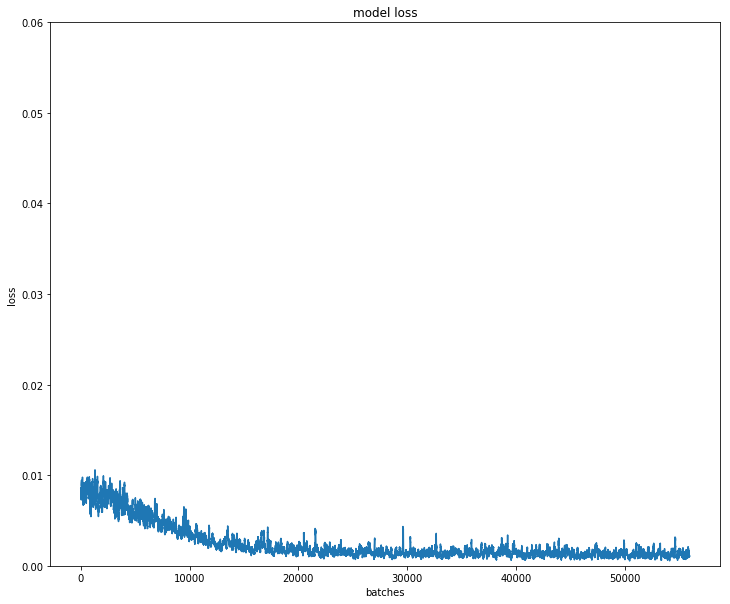

In [59]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

def plot_history(history):
    plt.plot(running_mean(history.losses, 50))
    plt.ylim(0, 0.06)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('batches')
    plt.show()
    
plot_history(batch_history)
